In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import warnings
import joblib
import os
from scipy.interpolate import interp1d
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from matplotlib import cm
import copy
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
from src.eeg_analysis.data_management import load_patient_group_labels
from src.eeg_analysis.utils.helpers import normalize_time_and_resample, get_ordered_states, weighted_pca
from src.eeg_analysis.visualization.plots import generate_greek_band_names, generate_region_acronyms
from src.eeg_analysis.visualization.plots import plot_wPLI_matrix_over_time, plot_wPLI_heatmaps, plot_wPLI_metrics, plot_transition_graph, plot_wPLI_frequency_profile, plot_wPLI_frequency_profile_separate_groups

In [2]:
def normalize_bottom_left(arr):
    """
    Normalizes the bottom-left off-diagonal values of a 4D array using
    their mean and standard deviation across all frequencies and time points.

    Parameters:
    arr (numpy.ndarray): 4D array with shape (num_regions, num_regions, num_fre, num_time_points)

    Returns:
    numpy.ndarray: Normalized 4D array
    """
    num_regions = arr.shape[0]

    # Create a mask for bottom-left off-diagonal elements
    mask = np.tril(np.ones((num_regions, num_regions)), k=-1).astype(bool)

    # Extract relevant values across all frequencies and time points
    bottom_left_values = arr[mask, :, :].reshape(-1)

    # Compute mean and standard deviation
    mean_val = np.nanmean(bottom_left_values)
    std_val = np.nanstd(bottom_left_values)

    # Avoid division by zero
    if std_val == 0:
        return arr  # No normalization needed if std is zero

    # Normalize the bottom-left off-diagonal elements
    arr[mask, :, :] = (arr[mask, :, :] - mean_val) / std_val

    return arr

NORMALIZE_WPLI = False
drug_infusion_time = 600


# Load the patient group labels
main_dir = 'E:/Caffeine_data/'

file_path = 'E:/Caffeine_data/caffeine_labels.xlsx'
groups = load_patient_group_labels(file_path)

BLUE = "#1f3b73"  # Dark Blue
RED = "#a82323"  # Dark Red

if groups is not None:
    
    epoch_names = ['preop_rest', 'pre_drug', 'post_drug', 'emergence', 'pacu_rest']
    fbands = ['delta', 'theta', 'alpha', 'beta', 'high beta', 'bb'] 

    # Initialize the arrays
    win_centers = {p_name: {epoch: [] for epoch in epoch_names} for p_name in groups['A']+groups['B']}
    conn_wpli_win_anat = {p_name: {epoch: [] for epoch in epoch_names} for p_name in groups['A']+groups['B']}
    conn_wpli_win_favg_anat = {fband: {p_name: {epoch: [] for epoch in epoch_names} for p_name in groups['A']+groups['B']} for fband in fbands}
    conn_wpli_valid_window_indices = {p_name: {epoch: [] for epoch in epoch_names} for p_name in groups['A']+groups['B']}
    group_label = {}

    # Load the data
    for p_idx, p_name in enumerate((groups['A']+groups['B'])):
        # base_results_dir = Path(f'E:/Caffeine_data/{p_name}/analysis_results')
        base_results_dir = Path(f'D:/Anesthesia_Research_Fellow/Spectral_connectivity_results/{p_name}')
        filename = base_results_dir / f'{p_name}_spectral_connectivity_wPLI_results_finer_windows.pkl'

        # filename = base_results_dir / f'{p_name}_spectral_connectivity_wPLI_results.pkl.pkl'

        if not filename.exists():
            warnings.warn(f"Warning: The file at {filename} was not found.", UserWarning)
            continue
        
        pli = joblib.load(filename)
        
        for epoch in ['preop_rest', 'emergence', 'pacu_rest']:

            if epoch == 'emergence':
                emergence_times = np.array(pli.win_centers[epoch])
                
                wPLI_wins_values = pli.conn_wpli_win_anat[epoch]

                # Eliminate time points with missing connectivity values for any channel pairs 
                all_region_names = pli.region_names
                region_names = [region for region in all_region_names if region not in {'temporal', 'occipital'}]
                region_indices = [all_region_names.index(region) for region in region_names]
                valid_window_idx = np.ones(len(emergence_times), dtype=bool)
                for reg_idx_a, orig_idx_a in enumerate(region_indices):
                    for reg_idx_b, orig_idx_b in enumerate(region_indices):
                        if reg_idx_a > reg_idx_b:    
                            summed_connectivity_each_win = np.nansum(wPLI_wins_values[orig_idx_a, orig_idx_b, :, :], axis=0)
                            valid_window_idx = valid_window_idx * (np.abs(summed_connectivity_each_win) > 0)

                if valid_window_idx.sum() == 0:
                    print(p_name)
                # emergence_times = emergence_times[valid_window_idx]
                # wPLI_wins_values = wPLI_wins_values[:, :, :, valid_window_idx]

                pre_drug_indices = np.where(emergence_times < drug_infusion_time)[0]
                post_drug_indices = np.where(emergence_times >= drug_infusion_time)[0]

                win_centers[p_name]['emergence'] = emergence_times.tolist()
                win_centers[p_name]['pre_drug'] = emergence_times[pre_drug_indices].tolist()
                win_centers[p_name]['post_drug'] = emergence_times[post_drug_indices].tolist()

                if NORMALIZE_WPLI:
                    wPLI_wins_values = normalize_bottom_left(wPLI_wins_values)

                pre_drug_values = wPLI_wins_values[:, :, :, pre_drug_indices]
                post_drug_values = wPLI_wins_values[:, :, :, post_drug_indices]

                conn_wpli_win_anat[p_name]['emergence'] = wPLI_wins_values
                conn_wpli_win_anat[p_name]['pre_drug'] = pre_drug_values
                conn_wpli_win_anat[p_name]['post_drug'] = post_drug_values

                for fband in fbands:
                    wPLI_wins_favg_values = pli.conn_wpli_win_favg_anat[epoch][fband]
                    
                    # wPLI_wins_favg_values = wPLI_wins_favg_values[:, :, valid_window_idx]
                    
                    pre_drug_favg_values = wPLI_wins_favg_values[:, :, pre_drug_indices]
                    post_drug_favg_values = wPLI_wins_favg_values[:, :, post_drug_indices]

                    conn_wpli_win_favg_anat[fband][p_name]['emergence'] = wPLI_wins_favg_values
                    conn_wpli_win_favg_anat[fband][p_name]['pre_drug'] = pre_drug_favg_values
                    conn_wpli_win_favg_anat[fband][p_name]['post_drug'] = post_drug_favg_values

                conn_wpli_valid_window_indices[p_name]['emergence'] = valid_window_idx
            
            else:
                win_centers[p_name][epoch] = pli.win_centers[epoch]
                wPLI_wins_values = pli.conn_wpli_win_anat[epoch]
                wPLI_wins_values = (wPLI_wins_values - np.nanmean(wPLI_wins_values.flatten()))/np.nanstd(wPLI_wins_values)
                conn_wpli_win_anat[p_name][epoch] = wPLI_wins_values

                for fband in fbands:
                    conn_wpli_win_favg_anat[fband][p_name][epoch] = pli.conn_wpli_win_favg_anat[epoch][fband]

        if p_idx == 0:
            region_names = pli.region_names
            freqs = pli.freqs

        if p_name in groups['A']:
            group_label[p_name] = 'A'
        elif p_name in groups['B']:
            group_label[p_name] = 'B'
        else:
            group_label[p_name] = np.nan

Excel file loaded successfully.
Column names: Index(['Patient_Label', 'Group_Number', 'Raw_Data_Available',
       'Preprocessed_Data_Available', 'Valid MAC_and_normal_closure'],
      dtype='object')
{'A': ['CA-03', 'CA-05', 'CA-07', 'CA-10', 'CA-11', 'CA-13', 'CA-15', 'CA-18', 'CA-19', 'CA-26', 'CA-27', 'CA-38', 'CA-40', 'CA-42', 'CA-52', 'CA-55', 'CA-63', 'CA-64', 'CA-66', 'CA-71'], 'B': ['CA-01', 'CA-02', 'CA-04', 'CA-06', 'CA-09', 'CA-14', 'CA-21', 'CA-24', 'CA-25', 'CA-28', 'CA-29', 'CA-34', 'CA-36', 'CA-48', 'CA-49', 'CA-53', 'CA-54', 'CA-56', 'CA-65', 'CA-69', 'CA-70']}
Group A: 20 subjects, Group B: 21 subjects


In [3]:
conn_wpli_win_anat[p_name]['post_drug'].shape

(6, 6, 70, 121)

In [4]:
# Load the patients' surgery information including the MAC level
# surgery_info_file_path = 'E:/Caffeine_data/DE-IDENTIFIED_Caffeine_Study_1-minute_medians.xlsx'
# surgery_info_file_path = 'D:/Anesthesia_Research_Fellow/DE-IDENTIFIED_Caffeine_Study_1-minute_medians.xlsx'
# df_surgery_info = pd.read_excel(surgery_info_file_path)

# Load IPWs
file_path = 'E:/Caffeine_data/caffeine_labels_ipws.xlsx'
patients_conf_vars_ipw_df = pd.read_excel(file_path)

# patients_ages = df_surgery_info.groupby('Study_ID').agg({
#     'Age': 'first',
# }).reset_index()

# print(patients_ages)

In [5]:
number_target_time_points = 100
num_regions = len(all_region_names)
epoch = 'post_drug'

conn_wpli_win_anat_resampled = {p_name: {epoch: [] for epoch in epoch_names} for p_name in groups['A']+groups['B']}
conn_wpli_win_favg_anat_resampled = {fband: {p_name: {epoch: [] for epoch in epoch_names} for p_name in groups['A']+groups['B']} for fband in fbands}

for group, group_name in zip([groups['A'], groups['B']], ["Group A", "Group B"]):
    for p_name in group:
        conn_wpli_win_anat_resampled[p_name][epoch] = np.zeros((num_regions, num_regions, len(freqs), number_target_time_points))
        peri_drug_infusion_times = np.array(win_centers[p_name][epoch])
        
        if len(peri_drug_infusion_times) > 0:

            # post_infusion_mask = peri_drug_infusion_times >= drug_infusion_time
            post_drug_infusion_times = peri_drug_infusion_times#[post_infusion_mask]
            
            # Resample the wPLI heatmaps
            post_drug_conn_array = conn_wpli_win_anat[p_name][epoch]#[:, :, :, post_infusion_mask]

            for reg_idx_a, region_a in enumerate(all_region_names):
                for reg_idx_b, region_b in enumerate(all_region_names):
                    if reg_idx_a >= reg_idx_b:    
                        conn_wpli_win_anat_resampled[p_name][epoch][reg_idx_a, reg_idx_b, :, :] = normalize_time_and_resample(
                            post_drug_conn_array[reg_idx_a, reg_idx_b, :, :], 
                            post_drug_infusion_times, 
                            start_time=drug_infusion_time,
                            end_time=None,
                            number_target_time_points=number_target_time_points)
                        
                        
            # Resample the wPLI time courses for each frequency band
            for fband in fbands:
                conn_wpli_win_favg_anat_resampled[fband][p_name][epoch] = np.zeros((num_regions, num_regions, number_target_time_points))
                post_drug_conn_array = conn_wpli_win_favg_anat[fband][p_name][epoch]#[:, :, post_infusion_mask]

                for reg_idx_a, region_a in enumerate(all_region_names):
                    for reg_idx_b, region_b in enumerate(all_region_names):
                        if reg_idx_a >= reg_idx_b:    
                            conn_wpli_win_favg_anat_resampled[fband][p_name][epoch][reg_idx_a, reg_idx_b, :] = normalize_time_and_resample(
                                post_drug_conn_array[reg_idx_a, reg_idx_b, :], 
                                post_drug_infusion_times, 
                                start_time=drug_infusion_time,
                                end_time=None,
                                number_target_time_points=number_target_time_points)                 

In [6]:
# # Calculate the average connectivity across all subjects in each group        
# p_count = {}
# conn_win_anta_group = {}
# conn_win_favg_anta_group = {}
# for group, group_name in zip([groups['A'], groups['B']], ["Group A", "Group B"]):
    
#     # Average the wPLI heatmaps acorss all subjects in the group
#     conn_win_anta_resampled_group_avg = np.zeros((num_regions, num_regions, len(freqs), number_target_time_points))
#     count = np.zeros((num_regions, num_regions))
#     for reg_idx_a, region_a in enumerate(all_region_names):
#         for reg_idx_b, region_b in enumerate(all_region_names):
#             if reg_idx_a >= reg_idx_b:
#                 # count[reg_idx_a, reg_idx_b] = 0
#                 curr_region_pair_conn_heatmap_summation = np.zeros((len(freqs), number_target_time_points))
#                 for p_name in group:
#                     if np.nansum(conn_wpli_win_anat_resampled[p_name][epoch]) > 0:
#                         curr_region_pair_conn_heatmap = conn_wpli_win_anat_resampled[p_name][epoch][reg_idx_a, reg_idx_b, :, :]
#                         if np.nansum(curr_region_pair_conn_heatmap) > 0:
#                             curr_region_pair_conn_heatmap_summation += curr_region_pair_conn_heatmap
#                             count[reg_idx_a, reg_idx_b] += 1
                        
#                 curr_region_pair_mean_conn_heatmap = curr_region_pair_conn_heatmap_summation/count[reg_idx_a, reg_idx_b]
#                 conn_win_anta_resampled_group_avg[reg_idx_a, reg_idx_b, :, :] = curr_region_pair_mean_conn_heatmap
                
#     conn_win_anta_group[group_name] = conn_win_anta_resampled_group_avg
#     p_count[group_name] = count

#     # Average the wPLI time courses for each frequency band across all subjects in the group
#     conn_wpli_win_favg_anat_resampled_group_avg = {fband: np.zeros((num_regions, num_regions, number_target_time_points)) for fband in fbands}
#     for fband in fbands:
#         # time series from all patients in the group
#         all_time_series = [conn_wpli_win_favg_anat_resampled[fband][p_name][epoch] for p_name in group]
#         all_time_series = [ts for ts in all_time_series if np.nansum(ts) > 0] # >>NOTE: temporarily exclude the patients with no data
 
#         # calculate the median at each time point
#         # for each region pair exclude the all-zero time series and calculate the median
#         for reg_idx_a, region_a in enumerate(all_region_names):
#             for reg_idx_b, region_b in enumerate(all_region_names):
#                 if reg_idx_a >= reg_idx_b:
#                     curr_region_pair_ts = [ts[reg_idx_a, reg_idx_b, :] for ts in all_time_series]
#                     curr_region_pair_ts = [ts for ts in curr_region_pair_ts if np.nansum(ts) > 0]
#                     conn_wpli_win_favg_anat_resampled_group_avg[fband][reg_idx_a, reg_idx_b, :] = np.nanmean(
#                         np.array(curr_region_pair_ts), axis=0)
                
#     conn_win_favg_anta_group[group_name] = conn_wpli_win_favg_anat_resampled_group_avg

In [6]:
def build_group_averages(groups,
                         conn_wpli_win_anat_resampled,
                         conn_wpli_win_favg_anat_resampled,
                         epoch,
                         all_region_names,
                         freqs, fbands,
                         num_regions,
                         number_target_time_points,
                         patients_conf_vars_ipw_df,
                         USE_IPW=True):
    """
    Returns
    -------
    conn_win_anta_group  : dict {group_name: 4‑D array (reg×reg×freq×time)}
    conn_win_favg_group  : dict {group_name: {fband: 3‑D array}}
    """
    # 1) weight lookup (defaults to 1.0 if USE_IPW=False or missing)
    ipw_map = (patients_conf_vars_ipw_df
               .set_index("Patient_Label")["ipw_stabilized"]
               .to_dict()) if USE_IPW else {}
    weight = lambda p: float(ipw_map.get(p, 1.0))

    conn_win_anta_group  = {}
    conn_win_favg_group  = {}

    for group_patients, g_name in zip([groups['A'], groups['B']],
                                      ["Group A", "Group B"]):

        # ---------- heat‑map average over subjects ----------
        grp_avg = np.zeros((num_regions, num_regions,
                            len(freqs), number_target_time_points))
        w_tot   = np.zeros((num_regions, num_regions))

        for ia, _ in enumerate(all_region_names):
            for ib, _ in enumerate(all_region_names):
                if ia >= ib:
                    heat_sum = np.zeros((len(freqs), number_target_time_points))
                    for p in group_patients:
                        subj_map = conn_wpli_win_anat_resampled[p][epoch]
                        if np.nansum(subj_map) == 0:
                            continue
                        h   = subj_map[ia, ib, :, :]
                        if np.nansum(h) == 0:
                            continue
                        w_i = weight(p)
                        heat_sum += w_i * h
                        w_tot[ia, ib] += w_i
                    if w_tot[ia, ib] > 0:
                        grp_avg[ia, ib] = heat_sum / w_tot[ia, ib]

        conn_win_anta_group[g_name] = grp_avg

        # ---------- frequency‑band time‑course average ----------
        band_avg = {fb: np.zeros((num_regions, num_regions,
                                  number_target_time_points))
                    for fb in fbands}

        for fb in fbands:
            for ia in range(num_regions):
                for ib in range(num_regions):
                    if ia >= ib:
                        num = np.zeros(number_target_time_points)
                        den = 0.0
                        for p in group_patients:
                            ts = conn_wpli_win_favg_anat_resampled[fb][p][epoch]
                            if np.nansum(ts) == 0:
                                continue
                            w_i = weight(p)
                            num += w_i * ts[ia, ib, :]
                            den += w_i
                        if den > 0:
                            band_avg[fb][ia, ib, :] = num / den
        conn_win_favg_group[g_name] = band_avg

    return conn_win_anta_group, conn_win_favg_group, ipw_map

conn_win_anta_group, conn_win_favg_anta_group, ipw_map = build_group_averages(
    groups,
    conn_wpli_win_anat_resampled,
    conn_wpli_win_favg_anat_resampled,
    epoch,
    all_region_names,
    freqs, fbands,
    num_regions,
    number_target_time_points,
    patients_conf_vars_ipw_df,
    USE_IPW=False
)

Group A


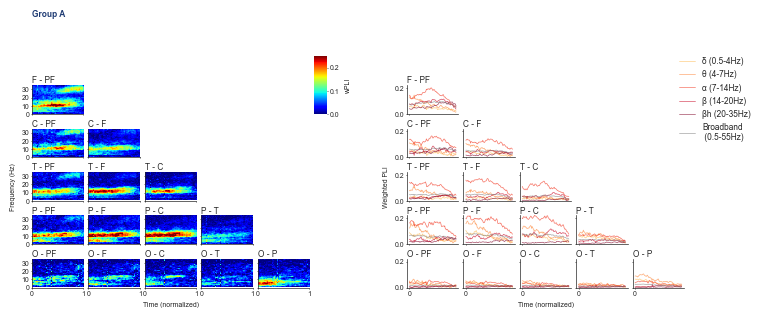

Group B


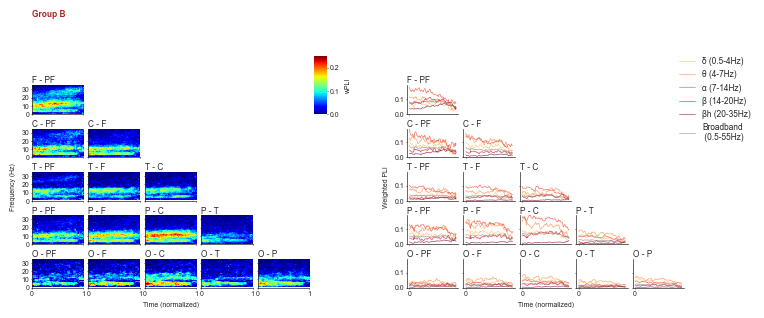

In [7]:
# Plot the average wPLI heatmaps for each group

# rows = 2
# cols = 1
# fig = plt.figure(figsize=(15, 10))
# gs = GridSpec(rows, cols, figure=fig, hspace=0.5, wspace=0.5)

for group_idx , group_name in enumerate(["Group A", "Group B"]):
    print(group_name)
    group_pli = pli
    group_pli.conn_wpli_win_anat['emergence'] = conn_win_anta_group[group_name]
    group_pli.conn_wpli_win_favg_anat['emergence'] = conn_win_favg_anta_group[group_name]
    group_pli.region_names = all_region_names
    group_pli.win_centers['emergence'] = np.linspace(0,number_target_time_points, number_target_time_points)

    # plot the wPLI heatmaps
    # ax_heatmap = fig.add_subplot(gs[group_idx, 0])
    plot_wPLI_heatmaps(group_pli, 'emergence', vmin=0, vmax=0.25, max_freq=35, colormap='jet', title=group_name, title_color=BLUE if group_name=='Group A' else RED, xlabel='Time (normalized)')

    # Save the figure
    main_dir = 'D:/Anesthesia_Research_Fellow/analysis_results'
    filename = f'{group_name}_emergence_wPLI_heatmap_time_series.pdf'
    file_path = os.path.join(main_dir, filename)

    plt.savefig(file_path, format='pdf', dpi=300)
    plt.show()

##### Changes in total connectivity (wPLI AUC) and extended alpha band (7-20 Hz) center-of-mass frequency across time

In [8]:
from typing import Optional, Tuple

# ----------------------------------------------------------------------
# CONFIG for the new summaries
# ----------------------------------------------------------------------
ALPHA_RANGE = (7, 20) # Hz
alpha_mask  = (freqs >= ALPHA_RANGE[0]) & (freqs <= ALPHA_RANGE[1])
epoch_names = ['post_drug']

# containers: [patient][epoch][ia,ib]  → scalar
auc_wpli_time_series      = {p: {e: np.full((num_regions, num_regions, number_target_time_points), np.nan)
                     for e in epoch_names}
                 for p in groups['A']+groups['B']}

com_alpha_wpli_time_series = {p: {e: np.full((num_regions, num_regions, number_target_time_points), np.nan)
                      for e in epoch_names}
                  for p in groups['A']+groups['B']}

# ----------------------------------------------------------------------
# helper
# ----------------------------------------------------------------------
def compute_center_of_mass(
    psd: np.ndarray,
    freqs: np.ndarray,
    band: Optional[Tuple[float, float]] = None,
) -> float:
    """
    Power‑weighted mean frequency (center of mass).

    Parameters
    ----------
    psd   : 1‑D np.ndarray
        Power‑spectral–density values.
    freqs : 1‑D np.ndarray
        Frequency values aligned with `psd`.
    band  : (low, high) or None, optional
        Frequency range over which to compute the COM.
        If None, use all frequencies. Default is None.

    Returns
    -------
    float
        Center of mass in the requested band, or np.nan if the band
        contains no data points or total power is zero.
    """
    # Select frequencies within the requested band (or all if band is None)
    if band is None:
        mask = np.ones_like(freqs, dtype=bool)
    else:
        low, high = band
        mask = (freqs >= low) & (freqs <= high)

    band_power = psd[mask]

    return np.sum(band_power * freqs[mask]) / np.sum(band_power)


# ----------------------------------------------------------------------
# iterate over patients / epochs / region pairs
# ----------------------------------------------------------------------
for p in groups['A'] + groups['B']:
    for epoch in epoch_names:                                # pre_drug, post_drug, ...
        array4d = conn_wpli_win_anat_resampled[p][epoch]     # shape R × R × F × T
        # if array4d == []:                                    # file missing / not resampled
        #     continue

        # integrate over freq first, then median over time  (optional)
        for ia in range(num_regions):
            for ib in range(num_regions):
                if ia < ib:                                  # keep lower triangle or use all
                    continue

                spec = array4d[ia, ib]                       # F × T
                if np.isnan(spec).all():
                    continue

                # ----- AUC across full frequency range -----------------
                # integrate (trapz) for each time point, then median across time
                auc_vals = np.trapz(spec, freqs, axis=0)     # length T
                auc_wpli_time_series[p][epoch][ia, ib] = auc_vals

                # ----- α-COM (7–14 Hz) -------------------------------
                com_vals = [compute_center_of_mass(spec[:, t], freqs, ALPHA_RANGE)
                            for t in range(spec.shape[1])]
                com_vals = [val if 7 < val <= 20 else np.nan for val in com_vals]
                
                com_alpha_wpli_time_series[p][epoch][ia, ib] = com_vals


C:\Users\Kourosh\AppData\Local\Temp\ipykernel_22396\1968005249.py:55: RuntimeWarning: invalid value encountered in scalar divide
  return np.sum(band_power * freqs[mask]) / np.sum(band_power)


Frontal – Prefrontal  auc_wpli  Wilcoxon p = 0.3821318248692478
Parietal – Frontal  auc_wpli  Wilcoxon p = 0.0039481825897382805
ranksum p = 0.09485765464069118
Frontal – Prefrontal  com_alpha_wpli  Wilcoxon p = 6.246496923267841e-06
Parietal – Frontal  com_alpha_wpli  Wilcoxon p = 7.92629271018086e-06
ranksum p = 0.6442444748572598


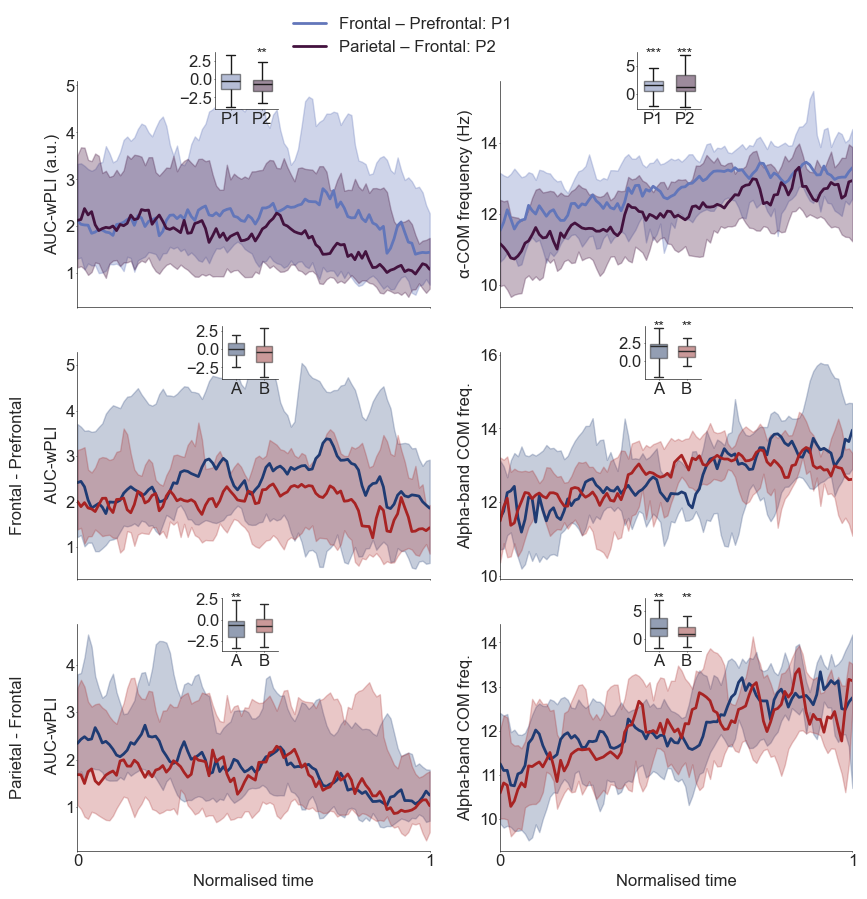


=== Between-group rank-sum + within-group Wilcoxon ===
auc_wpli     frontal–prefrontal  A med +1.48e-02  B med -4.16e-01  rank-sum p=0.361  |  Wilcoxon vs 0  A p=0.956, B p=0.191
auc_wpli     parietal–frontal  A med -6.64e-01  B med -6.93e-01  rank-sum p=0.419  |  Wilcoxon vs 0  A p=0.00944, B p=0.157
com_alpha_wpli  frontal–prefrontal  A med +2.09e+00  B med +1.33e+00  rank-sum p=0.498  |  Wilcoxon vs 0  A p=0.00143, B p=0.00137
com_alpha_wpli  parietal–frontal  A med +1.91e+00  B med +9.01e-01  rank-sum p=0.549  |  Wilcoxon vs 0  A p=0.00121, B p=0.00186


In [9]:
from scipy.stats import linregress, ranksums, wilcoxon
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib import colormaps
from scipy.ndimage import uniform_filter1d

# ───────── helpers ─────────
def median_iqr(mat):
    return (np.nanmedian(mat, axis=0),
            np.nanpercentile(mat, 25, axis=0),
            np.nanpercentile(mat, 75, axis=0))

def sig_str(p, mark='*'):
    return mark*3 if p < .001 else mark*2 if p < .01 else mark if p < .05 else ' '

# ───────── config ──────────
pair1, pair2 = (1, 0), (4, 1)        # indices into all_region_names
metric_names = ["auc_wpli", "com_alpha_wpli"]
cmap = colormaps.get_cmap("twilight")
pair_colors = {pair1: cmap(0.25), pair2: cmap(0.55)}

n_time = number_target_time_points
t_norm = np.linspace(0, 1, n_time)
SMOOTH_WIN = 1

# ───────── collect slopes (group-separated) ─────────
pair_slopes = {m: {pair: {'A': [], 'B': []} for pair in (pair1, pair2)}
               for m in metric_names}

for metric in metric_names:
    ts_dict = auc_wpli_time_series if metric == "auc_wpli" else com_alpha_wpli_time_series
    for g in ['A', 'B']:
        for p in groups[g]:
            for pair in (pair1, pair2):
                ia, ib = pair
                y = ts_dict[p]['post_drug'][ia, ib]
                ok = ~np.isnan(y)
                if ok.sum() >= 3:
                    slope, *_ = linregress(t_norm[ok], y[ok])
                    pair_slopes[metric][pair][g].append(slope)

# ───────── plot (3 rows × n_metrics) ─────────
fig, axes = plt.subplots(3, len(metric_names),
                         figsize=(5*len(metric_names), 10),
                         sharex=True)

for col, metric in enumerate(metric_names):

    ts_dict = auc_wpli_time_series if metric == "auc_wpli" else com_alpha_wpli_time_series
    y_lab   = "AUC-wPLI (a.u.)" if metric == "auc_wpli" else "α-COM frequency (Hz)"

    # ----- Row 0: pooled groups (region-pair overlay) -----------------
    ax0 = axes[0, col]
    for idx, pair in zip([1,2], (pair1, pair2)):
        ia, ib = pair
        all_ser = [uniform_filter1d(ts_dict[p]['post_drug'][ia, ib], 2*SMOOTH_WIN)
                   for g in ['A', 'B'] for p in groups[g]]
        med, q25, q75 = median_iqr(all_ser)
        ax0.fill_between(t_norm, q25, q75, color=pair_colors[pair], alpha=.3)
        ax0.plot(t_norm, med, lw=2, color=pair_colors[pair],
                 label=f'{all_region_names[ia].capitalize()} – {all_region_names[ib].capitalize()}: P{idx}')

    ax0.set_xlim(0, 1); ax0.set_xticks([0, 1]); ax0.tick_params(labelsize=12)
    ax0.set_title("Pooled", fontsize=12)
    ax0.set_ylabel(y_lab, fontsize=12)
    if col == 0:
        legend_lines, legend_labels = ax0.get_legend_handles_labels()

    inset0 = inset_axes(ax0, "45%", "28%",
                        bbox_to_anchor=(.28, .55, .4, .9),
                        bbox_transform=ax0.transAxes, loc="center")

    pooled1 = pair_slopes[metric][pair1]['A'] + pair_slopes[metric][pair1]['B']
    pooled2 = pair_slopes[metric][pair2]['A'] + pair_slopes[metric][pair2]['B']
    sns.boxplot(data=[pooled1, pooled2],
                palette=[pair_colors[pair1], pair_colors[pair2]],
                width=.6, boxprops={'alpha': 0.5}, showfliers=False, ax=inset0)
    inset0.set_xticks([0, 1], ['P1', 'P2'], fontsize=12)
    inset0.tick_params(labelsize=12)
    _, p_pair = ranksums(pooled1, pooled2)
    yl = inset0.get_ylim()
    inset0.text(.5, yl[1] + .02*(yl[1]-yl[0]), sig_str(p_pair),
                ha='center', fontsize=11)

    # annotate vs 0
    for i, box in enumerate([pooled1, pooled2]):
        if len(box):
            _, p0 = wilcoxon(box)
            inset0.text(i, yl[1] - .08*(yl[1]-yl[0]), sig_str(p0),
                        ha='center', fontsize=10)
            if i == 0:
                ia, ib = pair1
            elif i == 1:
                ia, ib = pair2
            print(f"{all_region_names[ia].capitalize()} – {all_region_names[ib].capitalize()}  {metric}  Wilcoxon p = {p0}")

    _, p_bw = wilcoxon(pooled1, pooled2, alternative='two-sided')
    print(f'ranksum p = {p_bw}')

    # ----- Rows 1 & 2: per-pair, Group A vs B -------------------------
    for row, pair in zip([1, 2], (pair1, pair2)):
        ia, ib = pair
        ax = axes[row, col]
        for g, colr in zip(['A', 'B'], [BLUE, RED]):
            ser = [uniform_filter1d(ts_dict[p]['post_drug'][ia, ib], 2*SMOOTH_WIN)
                   for p in groups[g]]
            med, q25, q75 = median_iqr(ser)
            ax.fill_between(t_norm, q25, q75, color=colr, alpha=.25)
            ax.plot(t_norm, med, lw=2, color=colr, label=f'Group {g}')

        if col == 0:
            ax.set_ylabel(f'{all_region_names[ia].capitalize()} - {all_region_names[ib].capitalize()}\n\n AUC-wPLI',fontsize=12)
        elif col == 1:
            ax.set_ylabel('Alpha-band COM freq.', fontsize=12)
            
        ax.set_xlim(0, 1); ax.set_xticks([0, 1]); ax.tick_params(labelsize=12)
        if row == 2: ax.set_xlabel("Normalised time", fontsize=12)

        inset = inset_axes(ax, "42%", "26%",
                           bbox_to_anchor=(.30, .55, .38, .9),
                           bbox_transform=ax.transAxes, loc="center")
        a_sl, b_sl = pair_slopes[metric][pair]['A'], pair_slopes[metric][pair]['B']
        sns.boxplot(data=[a_sl, b_sl], palette=[BLUE, RED],
                    width=.6, boxprops={'alpha': 0.5}, showfliers=False, ax=inset)
        inset.set_xticks([0, 1], ['A', 'B'], fontsize=12)
        inset.tick_params(labelsize=12)
        _, p_ab = ranksums(a_sl, b_sl)
        yl2 = inset.get_ylim()
        inset.text(.5, yl2[1] + .02*(yl2[1]-yl2[0]), sig_str(p_ab),
                   ha='center', fontsize=11)
        # annotate each box vs 0
        for i, box in enumerate([a_sl, b_sl]):
            if len(box):
                _, p0 = wilcoxon(box)
                inset.text(i, yl2[1] - .08*(yl2[1]-yl2[0]), sig_str(p0),
                           ha='center', fontsize=10)
                
        if (metric=="com_alpha_wpli") & (pair==pair1):
            aaa = a_sl
            bbb = b_sl

ax_legend = fig.add_subplot([0.4, 0.9, 0.1, 0.05])
ax_legend.legend(legend_lines, legend_labels, loc='center', fontsize=12, facecolor = 'black')
ax_legend.spines['bottom'].set_visible(False)
ax_legend.spines['left'].set_visible(False)
ax_legend.set_xticks([])
ax_legend.set_yticks([])
ax_legend.tick_params(bottom=False, left=False)

plt.show()

# ───────── console summary ─────────
print("\n=== Between-group rank-sum + within-group Wilcoxon ===")
for m in metric_names:
    for pair in (pair1, pair2):
        ia, ib = pair
        a = np.asarray(pair_slopes[m][pair]['A'])
        b = np.asarray(pair_slopes[m][pair]['B'])
        if len(a) and len(b):
            U, p_rs = ranksums(a, b)
            _, pA = wilcoxon(a) if len(a) else (np.nan, np.nan)
            _, pB = wilcoxon(b) if len(b) else (np.nan, np.nan)
            print(f"{m:11s}  {all_region_names[ia]}–{all_region_names[ib]}  "
                  f"A med {np.median(a):+.2e}  B med {np.median(b):+.2e}  "
                  f"rank-sum p={p_rs:.3g}  |  Wilcoxon vs 0  A p={pA:.3g}, B p={pB:.3g}")


Description of the results: 

Pooling across patient groups, total connectivity (as measured by AUC-wPLI) significantly decreases in the Parietal–Frontal region pair but not in the Frontal–Prefrontal pair, suggesting that Frontal–Prefrontal connectivity remains preserved throughout the emergence window. This preserved Frontal–Prefrontal connectivity appears more pronounced—though not statistically significant—in Group A (median: 0.015, Wilcoxon p = 0.956) compared to Group B (median: -0.416, p = 0.191; Group A vs. B ranksum p = 0.361). In contrast, Group A shows a stronger suppression of Parietal–Frontal connectivity (Group A median: -0.664, Wilcoxon p = 9.4 x 10^-3, Group B median: -0.693, p = 0.157, Group A vs B ranksum p = 0.498).

##### Median and IQR of Connectivity Spectral Profiles Across Time Segments of Emergence period 

In [10]:
# ───────────────────────── CONFIG ──────────────────────────
USE_IPW = False          # ← flip to False for the old un‑weighted stats
sigma   = 1.0           # Gaussian kernel width for optional smoothing
n_divisions = 5
# -----------------------------------------------------------

# 0)  Build one quick patient → weight lookup
ipw_lookup = (
    patients_conf_vars_ipw_df
        .set_index("Patient_Label")["ipw_stabilized"]
        .to_dict()
) if USE_IPW else {}

def w(p):           # helper – returns weight (defaults to 1.0)
    return float(ipw_lookup.get(p, 1.0))


# 1)  Helper to get weighted quantiles for a 1‑D vector
# def wquantile(values, weights, q):
#     """Tukey weighted quantile (q in 0–1)."""
#     v, wts = np.asarray(values), np.asarray(weights, float)
#     mask   = ~(np.isnan(v) | np.isnan(wts))
#     v, wts = v[mask], wts[mask]
#     if v.size == 0 or wts.sum() == 0:
#         return np.nan
#     order      = np.argsort(v)
#     v_sorted   = v[order]
#     w_sorted   = wts[order]
#     cum_w      = np.cumsum(w_sorted)
#     return v_sorted[cum_w >= q * w_sorted.sum()][0]
def wquantile(values: np.ndarray, weights: np.ndarray, q: float) -> float:
    v, w = map(np.asarray, (values, weights))
    msk  = ~(np.isnan(v) | np.isnan(w))
    v, w = v[msk], w[msk]
    if v.size == 0 or w.sum() == 0:
        return np.nan
    order = np.argsort(v)
    v_sorted, w_sorted = v[order], w[order]
    cum_w = np.cumsum(w_sorted)
    return v_sorted[cum_w >= q * w_sorted.sum()][0]

# 2)  Pre‑compute useful indices
T = number_target_time_points
time_idx_post = np.array_split(np.arange(T), n_divisions)

# containers
spectral_stats = {
    g: {
        'pre_drug':  {'median': np.zeros((num_regions, num_regions, 1, len(freqs))),
                      'iqr_low': np.zeros((num_regions, num_regions, 1, len(freqs))),
                      'iqr_high':np.zeros((num_regions, num_regions, 1, len(freqs)))},
        'post_drug': {'median': np.zeros((num_regions, num_regions, n_divisions, len(freqs))),
                      'iqr_low': np.zeros((num_regions, num_regions, n_divisions, len(freqs))),
                      'iqr_high':np.zeros((num_regions, num_regions, n_divisions, len(freqs)))}
    } for g in ["Group A", "Group B"]
}


# 3)  Main loop
for group_patients, g_name in zip([groups['A'], groups['B']], ["Group A", "Group B"]):

    for epoch in ['pre_drug', 'post_drug']:

        time_partitions = [slice(None)] if epoch == 'pre_drug' else time_idx_post
        med   = spectral_stats[g_name][epoch]['median']
        low   = spectral_stats[g_name][epoch]['iqr_low']
        high  = spectral_stats[g_name][epoch]['iqr_high']

        for ia in range(num_regions):
            for ib in range(num_regions):
                if ia < ib:
                    continue

                for div, t_idx in enumerate(time_partitions):

                    profiles, weights = [], []

                    for p in group_patients:

                        # pull subject matrix (freq × time)
                        if epoch == 'post_drug':
                            dat = conn_wpli_win_anat_resampled[p][epoch][ia, ib, :, t_idx].T
                        else:  # pre_drug
                            dat = conn_wpli_win_anat[p][epoch][ia, ib, :, :]

                        if np.nansum(dat) == 0:
                            continue

                        subj_profile = np.nanmedian(dat, axis=1)     # collapse time
                        # subj_profile = gaussian_filter1d(subj_profile, sigma)  # optional smoothing

                        profiles.append(subj_profile)
                        weights.append(w(p))

                    if profiles:          # ≥1 subject contributed
                        arr = np.vstack(profiles)          # shape (n_subj, n_freqs)
                        wts = np.asarray(weights)

                        if USE_IPW:
                            # weighted median & IQR per‑frequency
                            med_vec  = [wquantile(arr[:, f], wts, 0.50) for f in range(len(freqs))]
                            low_vec  = [wquantile(arr[:, f], wts, 0.25) for f in range(len(freqs))]
                            high_vec = [wquantile(arr[:, f], wts, 0.75) for f in range(len(freqs))]
                        else:
                            med_vec  = np.nanmedian(arr, axis=0)
                            low_vec  = np.nanpercentile(arr, 25, axis=0)
                            high_vec = np.nanpercentile(arr, 75, axis=0)

                        med [ia, ib, div, :] = med_vec
                        low [ia, ib, div, :] = low_vec
                        high[ia, ib, div, :] = high_vec
                    else:                 # no data for this pair / division
                        med [ia, ib, div, :] = np.nan
                        low [ia, ib, div, :] = np.nan
                        high[ia, ib, div, :] = np.nan

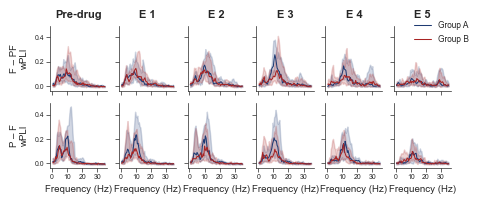

In [13]:
# ---- USER PARAMETERS ----
pairs       = [
    (1, 0), # Frontal - Prefrontal 
    (4, 1), # Parietal - Frontal
    # (4, 2) # Parietal - Central
]

colors       = {'Group A': BLUE, 'Group B': RED}
stats_A_pre  = spectral_stats['Group A']['pre_drug']
stats_B_pre  = spectral_stats['Group B']['pre_drug']
stats_A_post = spectral_stats['Group A']['post_drug']
stats_B_post = spectral_stats['Group B']['post_drug']
n_cols       = 1 + n_divisions    # one for pre_drug + n_divisions post_drug
# -------------------------

region_acrs = generate_region_acronyms(all_region_names)

plot_width = 350
plot_height = 150

fig, axes = plt.subplots(
    len(pairs), 
    n_cols,
    figsize=(plot_width/72, plot_height/72),
    sharex=True, 
    sharey=True,
    # constrained_layout=True
)

for r, (i, j) in enumerate(pairs):
    for c in range(n_cols):
        ax = axes[r, c]

        # decide which epoch & division we're plotting
        if c == 0:
            title = "Pre-drug"
            stats_list = [
                ('Group A', stats_A_pre),
                ('Group B', stats_B_pre)
            ]
            div_idx = 0
        else:
            title = f"E {c}"  # segments 1..5
            stats_list = [
                ('Group A', stats_A_post),
                ('Group B', stats_B_post)
            ]
            div_idx = c - 1

        # overlay each group
        for grp_name, stats_grp in stats_list:
            med = stats_grp['median'][i, j, div_idx, :]
            low = stats_grp['iqr_low'][i, j, div_idx, :]
            hi  = stats_grp['iqr_high'][i, j, div_idx, :]

            ax.plot(freqs, med, color=colors[grp_name], linewidth= 0.75, label=grp_name)
            ax.fill_between(freqs, low, hi, color=colors[grp_name], alpha=0.2)

        # legend only in top‐left
        if r == 0 and c == 0:
            legend_lines, legend_labels = ax.get_legend_handles_labels()

        # common styling
        ax.set_xticks(np.arange(0, 35, 10))
        ax.tick_params(labelsize=5, length=3)

        # y‐label only on first column
        if c == 0:
            lbl = f"{region_acrs[all_region_names[i]]} – " \
                  f"{region_acrs[all_region_names[j]]}\nwPLI"
            ax.set_ylabel(lbl, fontsize=7)

        # x‐label only on bottom row
        if r == len(pairs) - 1:
            ax.set_xlabel('Frequency (Hz)', fontsize=7)

        # title only on top row
        if r == 0:
            ax.set_title(title, fontsize=8, fontweight='bold')


# Add legend
ax_legend = fig.add_subplot([0.88, 0.8, 0.1, 0.1])
ax_legend.legend(legend_lines, legend_labels, frameon=False, loc='center', fontsize=6)
ax_legend.spines['bottom'].set_visible(False)
ax_legend.spines['left'].set_visible(False)
ax_legend.set_xticks([])
ax_legend.set_yticks([])
ax_legend.tick_params(bottom=False, left=False)

plt.subplots_adjust(right=0.95, bottom=0.2)

# Save the figure
main_dir = 'D:/Anesthesia_Research_Fellow/analysis_results'
filename = f'connectivity_spectral_profiles_equal_post_segments'
if USE_IPW:
    filename = filename + '_IPW'

file_path = os.path.join(main_dir, filename + '.pdf')
plt.savefig(file_path, format='pdf', dpi=300)

plt.show()

##### Split Violin Plots of wPLI Connectivity Across Frequency Bands During Pre-Drug and Emergence Segments

In [25]:
# ---- PARAMETERS ----
bands       = {
    "Delta": (0.5,  4),
    "Alpha": (7,   14),
    "Beta":  (14,  20),
    "Gamma": (20,  35)
}

n_divisions = 5
# BLUE = "#1f3b73"  # Dark Blue
# RED = "#a82323"  # Dark Red
groups_map  = {"Group A": groups['A'], "Group B": groups['B']}
# ---------------------

# 1) Precompute post‐drug time splits
time_idx_post = np.array_split(np.arange(number_target_time_points), n_divisions)

# 2) Assemble a long‐form DataFrame of one value per subject × pair × band × segment
records = []
for grp_name, subj_list in groups_map.items():
    for subj in subj_list:
        # --- Pre‐drug (entire epoch) ---
        arr_pre = np.asarray(conn_wpli_win_anat[subj]['pre_drug'])  # shape: (regions, regions, freqs, time_pre)
        for i, j in pairs:
            dat = arr_pre[i, j, :, :]
            for band_name, (fmin, fmax) in bands.items():
                idx = np.where((freqs >= fmin) & (freqs < fmax))[0]
                val = np.nanmean(dat[idx, :])
                records.append({
                    "subject":     subj,
                    "region_pair": f"{all_region_names[i]}–{all_region_names[j]}",
                    "band":        band_name,
                    "segment":     "Pre-drug",
                    "group":       grp_name,
                    "value":       val
                })
        # --- Post‐drug (split into n_divisions) ---
        arr_post = np.asarray(conn_wpli_win_anat_resampled[subj]['post_drug'])  # (regions, regions, freqs, time_post)
        for seg_idx, t_idx in enumerate(time_idx_post, start=1):
            for i, j in pairs:
                dat = arr_post[i, j, :, t_idx]         # shape: (freqs, time_segment)
                dat = dat.T
                for band_name, (fmin, fmax) in bands.items():
                    idx = np.where((freqs >= fmin) & (freqs < fmax))[0]
                    val = np.nanmean(dat[idx, :])
                    records.append({
                        "subject":     subj,
                        "region_pair": f"{all_region_names[i]}–{all_region_names[j]}",
                        "band":        band_name,
                        "segment":     f"E{seg_idx}",
                        "group":       grp_name,
                        "value":       val
                    })

df = pd.DataFrame.from_records(records)

# ── 1  merge weights ──────────────────────────────────────────────
df = (
    df
    .merge(patients_conf_vars_ipw_df, left_on="subject", right_on='Patient_Label', how="left")   # remove if weight already present
)

##### Statistical comparison with pre-drug baseline for each region pair, frequency band, and group across infusion-to-extubation segments

In [26]:
from scipy.stats import wilcoxon
from statsmodels.stats.multitest import multipletests

# ───────────────────────── CONFIG ──────────────────────────
N_PERM    = 10000        # permutations for weighted test
RNG_SEED  = 42
FDR_Q     = 0.05
# -----------------------------------------------------------

# quick IPW lookup # (defaults to 1.0 when weights off / missing)
if USE_IPW:
    try:
        ipw_map = (patients_conf_vars_ipw_df
                   .set_index("Patient_Label")["ipw_stabilized"]
                   .to_dict())
    except KeyError:
        raise ValueError("ipw_stabilized column missing – can’t apply IPWs.")

    missing = set(groups['A']).union(groups['B']) - ipw_map.keys()
    if missing:
        raise ValueError(f"no IPWs for: {sorted(missing)}")

    w = lambda p: ipw_map[p]          # weight must exist
else:
    w = lambda p: 1.0                 # unweighted


# helper: Tukey weighted quantile (for descriptive stats)
# def wquantile(values, weights, q):
#     v, wts = np.asarray(values), np.asarray(weights, float)
#     mask   = ~(np.isnan(v) | np.isnan(wts))
#     v, wts = v[mask], wts[mask]
#     if v.size == 0 or wts.sum() == 0:
#         return np.nan
#     order = np.argsort(v)
#     v, wts = v[order], wts[order]
#     cum_w  = np.cumsum(wts)
#     return v[cum_w >= q * wts.sum()][0]



# ---------- SETTINGS ----------
SEGMENTS = [f"E{n}" for n in range(1, n_divisions + 1)]
pair_names = {(i, j): f"{all_region_names[i]}–{all_region_names[j]}"
              for (i, j) in pairs}
# --------------------------------

rng      = np.random.default_rng(RNG_SEED)
records  = []

for (i, j), rp_name in pair_names.items():
    for band in bands:
        df_sub = df[(df.region_pair == rp_name) & (df.band == band)]

        for grp in ["Group A", "Group B"]:
            tbl = (df_sub[df_sub.group == grp]
                   .pivot_table(index="subject",
                                columns="segment",
                                values="value",
                                aggfunc="mean"))

            baseline = tbl["Pre-drug"]

            for seg in SEGMENTS:
                if seg not in tbl.columns:
                    continue

                post = tbl[seg]
                valid = baseline.index[baseline.notna() & post.notna()]
                N = len(valid)

                stat = p_raw = np.nan
                med = iqr_lo = iqr_hi = np.nan

                if N >= 3:

                    diffs   = (post.loc[valid] - baseline.loc[valid]).to_numpy()
                    weights = np.array([w(s) for s in valid])

                    # ------- statistical test -------
                    if USE_IPW:
                        # weighted median difference as test statistic
                        obs = wquantile(diffs, weights, 0.5)

                        # permutation null via random sign‑flips
                        perm_stats = []
                        for _ in range(N_PERM):
                            flips = rng.choice([-1, 1], size=N)
                            perm_stats.append(
                                wquantile(diffs * flips, weights, 0.5)
                            )
                        perm_stats = np.asarray(perm_stats)
                        p_raw = (np.sum(np.abs(perm_stats) >= abs(obs)) + 1) / (N_PERM + 1)
                        stat  = obs
                    else:
                        stat, p_raw = wilcoxon(post.loc[valid],
                                               baseline.loc[valid],
                                               alternative="two-sided",
                                               zero_method="wilcox")

                    # ------- descriptive stats on post values -------
                    vals = post.loc[valid].to_numpy()
                    if USE_IPW:
                        med     = wquantile(vals, weights, 0.5)
                        iqr_lo  = wquantile(vals, weights, 0.25)
                        iqr_hi  = wquantile(vals, weights, 0.75)
                    else:
                        med     = np.nanmedian(vals)
                        iqr_lo  = np.nanpercentile(vals, 25)
                        iqr_hi  = np.nanpercentile(vals, 75)

                records.append({
                    "region_pair": rp_name,
                    "band":        band,
                    "group":       grp,
                    "segment":     seg,
                    "stat":        stat,          # W (unweighted) or Δ̃ (weighted)
                    "df":          N - 1,
                    "p_raw":       p_raw,
                    "median":      med,
                    "iqr_25":      iqr_lo,
                    "iqr_75":      iqr_hi
                })

# → DataFrame
tests = pd.DataFrame.from_records(records).dropna(subset=["p_raw"])

# FDR correction within each (pair, band) family
tests["q"] = np.nan
tests["sig"] = False
for (rp, band), idx in tests.groupby(["region_pair", "band"]).groups.items():
    pvals = tests.loc[idx, "p_raw"].to_numpy()
    reject, qvals, *_ = multipletests(pvals, alpha=FDR_Q, method="fdr_bh")
    tests.loc[idx, ["q", "sig"]] = np.column_stack([qvals, reject])

# ------- Example printout -------
test_label = "Δ̃ (w‑median)" if USE_IPW else "W"
for (rp, band), grp_df in tests.groupby(["region_pair", "band"]):
    print(f"\n{rp} | {band}")
    for grp in ["Group A", "Group B"]:
        rows = grp_df[grp_df.group == grp]
        print(f"  {grp}")
        for _, r in rows.iterrows():
            star = "*" if r["sig"] else ""
            print(
                f"    {r['segment']:>5}: "
                f"{test_label}={r['stat']:7.3f}  "
                f"df={int(r['df']):2d}  "
                f"p={r['p_raw']:7.4f}  "
                f"q={r['q']:7.4f}  "
                f"median={r['median']:.3f}  "
                f"IQR=({r['iqr_25']:.3f}, {r['iqr_75']:.3f}) {star}"
            )


frontal–prefrontal | Alpha
  Group A
       E1: W= 90.000  df=19  p= 0.5958  q= 0.8512  median=0.120  IQR=(0.060, 0.173) 
       E2: W= 63.000  df=19  p= 0.1231  q= 0.2462  median=0.147  IQR=(0.087, 0.193) 
       E3: W= 46.000  df=19  p= 0.0266  q= 0.0888  median=0.175  IQR=(0.095, 0.221) 
       E4: W=100.000  df=19  p= 0.8695  q= 0.9457  median=0.124  IQR=(0.045, 0.194) 
       E5: W= 41.000  df=19  p= 0.0153  q= 0.0766  median=0.047  IQR=(0.029, 0.124) 
  Group B
       E1: W=113.000  df=20  p= 0.9457  q= 0.9457  median=0.154  IQR=(0.069, 0.184) 
       E2: W=103.000  df=20  p= 0.6827  q= 0.8534  median=0.131  IQR=(0.098, 0.182) 
       E3: W= 94.000  df=20  p= 0.4733  q= 0.7889  median=0.104  IQR=(0.063, 0.160) 
       E4: W= 62.000  df=20  p= 0.0646  q= 0.1616  median=0.091  IQR=(0.035, 0.160) 
       E5: W= 40.000  df=20  p= 0.0071  q= 0.0710  median=0.079  IQR=(0.031, 0.101) 

frontal–prefrontal | Beta
  Group A
       E1: W= 84.000  df=19  p= 0.4524  q= 0.6463  median=0.026  

C:\Users\Kourosh\AppData\Local\Temp\ipykernel_22396\1765219735.py:134: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  tests.loc[idx, ["q", "sig"]] = np.column_stack([qvals, reject])


In [27]:
# Format the results for an Excel Spreadsheet

# ----------------------- tidy strings -----------------------
tests["Median (IQR)"] = tests.apply(
    lambda r: f"{r['median']:.3f} ({r['iqr_25']:.3f}–{r['iqr_75']:.3f})", axis=1)

#  ★ star for uncorrected p < 0.05
#  † dagger for FDR‑significant (q < FDR_Q)
tests["p (q)"] = tests.apply(
    lambda r: (
        f"{r['p_raw']:.4f}" +
        f" ({r['q']:.4f})" +
        ("★" if r['p_raw'] < 0.05 else "") +
        ("†" if r['sig'] else "")
    ),
    axis=1
)

tests = tests.rename(columns={
    "stat": "Weighted median change (post − pre)" if USE_IPW
            else "Wilcoxon W",
    "df":   "df"
})

# ---------------- widen: Group A | Group B -------------------
nice = tests[["region_pair","band","segment","group",
              "Weighted median change (post − pre)" if USE_IPW else "Wilcoxon W",
              "df","Median (IQR)","p (q)"]]

wide = (nice
        .set_index(["region_pair","band","segment","group"])
        .unstack("group")
        .swaplevel(axis=1)
        .sort_index(axis=1, level=0))

wide.columns = [" ".join(c).strip() for c in wide.columns.to_flat_index()]
flat = wide.reset_index()

##### Statistical comparison between groups for each region pair and frequency band within each emergence segment

In [28]:
from scipy.stats import ranksums
from statsmodels.stats.multitest import multipletests

# ──────────────────────────── CONFIG ──────────────────────────────
n_divisions   = 5                         # <-- your “En” count
SEG_POST      = [f"E{n}" for n in range(1, n_divisions + 1)]
SUBTRACT_PRE  = True     # True = post‑minus‑pre, False = raw values incl. Pre
FDR_Q         = 0.05
N_PERM        = 10_000
RNG_SEED      = 42
# ────────────────────────────────────────────────────────────────────

# 0) choose segments & build metric ─────────────────────────────────
if SUBTRACT_PRE:
    METRIC_LABEL = "ΔwPLI"
    SEGMENTS     = SEG_POST                       # only post segments
    pre_lookup = (
        df[df.segment == "Pre-drug"]
          .set_index(["subject", "region_pair", "band"])["value"]
    )
    rows = []
    for seg in SEG_POST:
        tmp = df[df.segment == seg].copy()
        tmp["metric"] = (tmp["value"]
                        - tmp.set_index(["subject", "region_pair", "band"])
                              .index.map(pre_lookup))
        rows.append(tmp)
    analysis_df = pd.concat(rows, ignore_index=True)

else:
    METRIC_LABEL = "wPLI"
    SEGMENTS     = ["Pre-drug"] + SEG_POST       # include baseline segment
    analysis_df  = df[df.segment.isin(SEGMENTS)].copy()
    analysis_df["metric"] = analysis_df["value"]

# explicit order helper for later printing
SEG_ORDER = {seg: i for i, seg in enumerate(SEGMENTS)}

# 1) IPW column  ────────────────────────────────────────────────────
if USE_IPW and "ipw_stabilized" in df.columns:
    ipw_lookup = (
        df[["subject", "ipw_stabilized"]]
          .drop_duplicates("subject")
          .set_index("subject")["ipw_stabilized"]
    )
    analysis_df["ipw"] = analysis_df["subject"].map(ipw_lookup)
else:
    analysis_df["ipw"] = 1.0

# 2) weighted quantile  ─────────────────────────────────────────────
# def wquantile(values: np.ndarray, weights: np.ndarray, q: float) -> float:
#     v, w = map(np.asarray, (values, weights))
#     msk  = ~(np.isnan(v) | np.isnan(w))
#     v, w = v[msk], w[msk]
#     if v.size == 0 or w.sum() == 0:
#         return np.nan
#     order = np.argsort(v)
#     v_sorted, w_sorted = v[order], w[order]
#     cum_w = np.cumsum(w_sorted)
#     return v_sorted[cum_w >= q * w_sorted.sum()][0]

# 3) main stats loop  ───────────────────────────────────────────────
rng, recs = np.random.default_rng(RNG_SEED), []

for (rp, band), block in analysis_df.groupby(["region_pair", "band"]):
    for seg in SEGMENTS:
        seg_df        = block[block.segment == seg]
        A, B          = seg_df[seg_df.group == "Group A"], seg_df[seg_df.group == "Group B"]
        nA, nB        = len(A), len(B)

        # ─ weighted pathway ───────────────────────────────────────
        if USE_IPW:
            med_A   = wquantile(A.metric, A.ipw, 0.5)
            med_B   = wquantile(B.metric, B.ipw, 0.5)
            iqr25_A = wquantile(A.metric, A.ipw, 0.25)
            iqr75_A = wquantile(A.metric, A.ipw, 0.75)
            iqr25_B = wquantile(B.metric, B.ipw, 0.25)
            iqr75_B = wquantile(B.metric, B.ipw, 0.75)

            if nA and nB:
                obs_diff  = med_A - med_B
                null_diff = []
                for _ in range(N_PERM):
                    shuffle = rng.permutation(seg_df.group.values)
                    A_mask  = shuffle == "Group A"
                    diff    = (wquantile(seg_df[A_mask].metric,
                                         seg_df[A_mask].ipw, 0.5)
                              - wquantile(seg_df[~A_mask].metric,
                                          seg_df[~A_mask].ipw, 0.5))
                    null_diff.append(diff)
                null_diff = np.asarray(null_diff)
                p_raw = (np.abs(null_diff) >= abs(obs_diff)).sum() + 1
                p_raw = p_raw / (N_PERM + 1)
            else:
                obs_diff = p_raw = np.nan

            stat_col, stat_val = f"{METRIC_LABEL}_wt", obs_diff

        # ─ unweighted rank‑sum pathway ────────────────────────────
        else:
            A_vals, B_vals = A.metric.dropna(), B.metric.dropna()

            med_A   = np.nanmedian(A_vals) if nA else np.nan
            med_B   = np.nanmedian(B_vals) if nB else np.nan
            iqr25_A = np.nanpercentile(A_vals, 25) if nA else np.nan
            iqr75_A = np.nanpercentile(A_vals, 75) if nA else np.nan
            iqr25_B = np.nanpercentile(B_vals, 25) if nB else np.nan
            iqr75_B = np.nanpercentile(B_vals, 75) if nB else np.nan

            if nA and nB:
                U, p_raw = ranksums(A_vals, B_vals)
            else:
                U = p_raw = np.nan

            stat_col, stat_val = "U", U

        recs.append({
            "region_pair": rp,
            "band":        band,
            "segment":     seg,
            stat_col:      stat_val,
            "p_raw":       p_raw,
            "nA":          nA,
            "nB":          nB,
            "med_A":       med_A,
            "iqr25_A":     iqr25_A,
            "iqr75_A":     iqr75_A,
            "med_B":       med_B,
            "iqr25_B":     iqr25_B,
            "iqr75_B":     iqr75_B,
        })

stats_df = pd.DataFrame.from_records(recs)

# 4) FDR within (pair, band) families ──────────────────────────────
stats_df["q"]  = np.nan
stats_df["sig"] = False

for (rp, band), idx in stats_df.groupby(["region_pair", "band"]).groups.items():
    mask = ~stats_df.loc[idx, "p_raw"].isna()
    if mask.sum():
        rej, q_vals, *_ = multipletests(stats_df.loc[idx[mask], "p_raw"],
                                        alpha=FDR_Q, method="fdr_bh")
        stats_df.loc[idx[mask], ["q", "sig"]] = np.column_stack([q_vals, rej])

# 5) summary print‑out (ordered by SEG_ORDER) ──────────────────────
header   = f"{METRIC_LABEL} = post − pre" if SUBTRACT_PRE else METRIC_LABEL
stat_col = f"{METRIC_LABEL}_wt" if USE_IPW else "U"

for (rp, band), sub in stats_df.groupby(["region_pair", "band"]):
    print(f"\n{rp} | {band}   ({header})")
    sub = sub.assign(_ord=sub.segment.map(SEG_ORDER))      # <— enforce order
    for _, row in sub.sort_values("_ord").iterrows():
        mark = "*" if row.sig else ""
        print(
            f"  {row.segment:<9} "
            f"{stat_col}={row[stat_col]:7.2f}  "
            f"p={row.p_raw:7.4f}  q={row.q:7.4f} {mark} | "
            f"A med={row.med_A:+.2f} (IQR {row.iqr25_A:+.2f}–{row.iqr75_A:+.2f}, n={row.nA})  ||  "
            f"B med={row.med_B:+.2f} (IQR {row.iqr25_B:+.2f}–{row.iqr75_B:+.2f}, n={row.nB})"
        )


frontal–prefrontal | Alpha   (ΔwPLI = post − pre)
  E1        U=   0.18  p= 0.8551  q= 0.8551  | A med=+0.00 (IQR -0.01–+0.02, n=20)  ||  B med=-0.01 (IQR -0.02–+0.03, n=21)
  E2        U=   1.04  p= 0.2968  q= 0.4947  | A med=+0.03 (IQR -0.02–+0.06, n=20)  ||  B med=+0.01 (IQR -0.02–+0.04, n=21)
  E3        U=   2.01  p= 0.0446  q= 0.2230  | A med=+0.02 (IQR -0.01–+0.12, n=20)  ||  B med=+0.01 (IQR -0.05–+0.02, n=21)
  E4        U=   1.28  p= 0.2012  q= 0.4947  | A med=-0.01 (IQR -0.03–+0.07, n=20)  ||  B med=-0.02 (IQR -0.10–+0.01, n=21)
  E5        U=   0.26  p= 0.7942  q= 0.8551  | A med=-0.03 (IQR -0.10–-0.01, n=20)  ||  B med=-0.03 (IQR -0.16–-0.00, n=21)

frontal–prefrontal | Beta   (ΔwPLI = post − pre)
  E1        U=  -0.08  p= 0.9376  q= 0.9584  | A med=+0.01 (IQR -0.01–+0.01, n=20)  ||  B med=+0.00 (IQR -0.01–+0.01, n=21)
  E2        U=   0.42  p= 0.6764  q= 0.9584  | A med=+0.01 (IQR +0.00–+0.04, n=20)  ||  B med=+0.02 (IQR -0.00–+0.04, n=21)
  E3        U=   0.44  p= 0.657

C:\Users\Kourosh\AppData\Local\Temp\ipykernel_22396\4092438005.py:144: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0. 0. 0. 0. 0.]' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  stats_df.loc[idx[mask], ["q", "sig"]] = np.column_stack([q_vals, rej])


In [29]:
# Format the results in an Excel spreadsheet

# ============================================================
#  A)  tidy, labelled BETWEEN‑GROUP columns
# ============================================================
diff_label = ("Weighted median diff (Group A − B)"
              if USE_IPW else "U statistic (Group A vs B)")

stats_df["A Median (IQR)"] = (
    stats_df.apply(lambda r: f"{r.med_A:.2f} "
                             f"({r.iqr25_A:.2f}–{r.iqr75_A:.2f})", axis=1))
stats_df["B Median (IQR)"] = (
    stats_df.apply(lambda r: f"{r.med_B:.2f} "
                             f"({r.iqr25_B:.2f}–{r.iqr75_B:.2f})", axis=1))

stats_df["p (q)"] = stats_df.apply(
    lambda r: (f"{r.p_raw:.4f}"
               + f" ({r.q:.4f})"
               + ("★" if r.p_raw < 0.05 else "")
               + ("†" if r.sig else "")),
    axis=1
)

# Which column in stats_df holds the effect size?
effect_col = f"{METRIC_LABEL}_wt" if USE_IPW else "U"

# Human‑readable title for the final sheet
effect_label = ("Weighted median diff (Group A − B)"
                if USE_IPW else "U statistic (Group A vs B)")

between = (
    stats_df[["region_pair", "band", "segment",
              effect_col, "nA", "nB",
              "A Median (IQR)", "B Median (IQR)", "p (q)"]]
    .rename(columns={effect_col: effect_label,
                     "nA": "n_A", "nB": "n_B"})
)

# ============================================================
#  B)  COMBINE within‑ and between‑group tables
#      (flat = within‑group table from the previous section)
# ============================================================
combined = pd.merge(flat, between,
                    on=["region_pair","band","segment"],
                    how="left")

# re‑blank repeated labels (region_pair, band)
dup_rp   = combined["region_pair"].duplicated()
dup_band = combined.duplicated(subset=["region_pair","band"])
combined.loc[dup_rp,   "region_pair"] = ""
combined.loc[dup_band, "band"]        = ""

# ============================================================
#  C)  Export ONE sheet with auto‑width columns
# ============================================================
out = "baseline_vs_segment_IPW.xlsx" if USE_IPW else "baseline_vs_segment.xlsx"

import math, xlsxwriter
with pd.ExcelWriter(out, engine="xlsxwriter") as xw:
    combined.to_excel(xw, sheet_name="Results", index=False)
    ws = xw.sheets["Results"]
    for i, col in enumerate(combined.columns):
        max_len = max(combined[col].astype(str).str.len().max(), len(col)) + 2
        ws.set_column(i, i, min(max_len, 50))  # cap width at 50

print(f"Saved combined table to {out}")

Saved combined table to baseline_vs_segment.xlsx


##### Violin plots

##### The violinplot version below works only for the unweighted
##### The boxplot, coming second, is more straightforward when ploting the IPW-weighted distributions 

In [ ]:
# ------------------------------------------------------------------
# 0)  Build quick‑lookup dictionaries for significant results
# ------------------------------------------------------------------
# Between‑group *, keyed by (pair, band, segment)
sig_bw = {
    (row.region_pair, row.band, row.segment): True
    for _, row in stats_df.iterrows() if row.sig
}

# Within‑group # for Group A and Group B
sig_A = {
    (row.region_pair, row.band, row.segment): True
    for _, row in tests.iterrows()
    if row.group == "Group A" and row.sig
}
sig_B = {
    (row.region_pair, row.band, row.segment): True
    for _, row in tests.iterrows()
    if row.group == "Group B" and row.sig
}

# ------------------------------------------------------------------
# 1)  Plot & annotate
# ------------------------------------------------------------------
n_rows, n_cols = len(pairs), len(bands)
fig, axes = plt.subplots(
    n_rows, n_cols,
    figsize=(3*n_cols, 2*n_rows),
    sharex=True
)

for r, (i, j) in enumerate(pairs):
    rp = f"{all_region_names[i]}–{all_region_names[j]}"
    for c, band_name in enumerate(bands):
        ax  = axes[r, c]
        dat = df[(df.region_pair == rp) & (df.band == band_name)]

        sns.violinplot(
            data=dat, density_norm="width",
            x="segment", y="value", hue="group",
            split=True, inner="quartile",
            palette=[BLUE, RED], linewidth=1,
            cut=0, width=0.7, alpha=0.65,
            edgecolor="white", ax=ax
        )

        # tidy legend, axis labels
        if r == 0 and c == 0:
            ax.legend(frameon=False, fontsize=10)
        else:
            lg = ax.get_legend()
            if lg:
                lg.remove()
        
        ax.set_xlabel("")

        if c == 0:
            ax.set_ylabel("wPLI", fontsize=14)
        else:
            ax.set_ylabel("")

        if r == 0:
            ax.set_title(band_name, fontsize=14, fontweight="bold")
        plt.setp(ax.get_xticklabels(), rotation=45,
                 ha="right", va="top")
        ax.tick_params(labelsize=12, length=3)

        # ----------------------------------------------------------
        # annotate * (between‑group) and # (within‑group) p‑values
        # ----------------------------------------------------------
        y_max = ax.get_ylim()[1]
        for idx, seg in enumerate(["Pre-drug"] +
                                  [f"E{n}" for n in range(1, n_divisions+1)]):
            # star for Group A vs B
            if sig_bw.get((rp, band_name, seg)):
                ax.text(idx, y_max * 1.03, "*",
                        ha="center", va="bottom",
                        fontsize=13, fontweight="bold")

            # hash for Group A baseline difference
            if sig_A.get((rp, band_name, seg)):
                ax.text(idx - 0.18, y_max * 0.95, "#",
                        ha="center", va="bottom",
                        fontsize=11, color=BLUE)

            # hash for Group B baseline difference
            if sig_B.get((rp, band_name, seg)):
                ax.text(idx + 0.18, y_max * 0.95, "#",
                        ha="center", va="bottom",
                        fontsize=11, color=RED)

# keep y‑limits aligned by column (unchanged)
for c in range(n_cols):
    ymin = min(axes[r, c].get_ylim()[0] for r in range(n_rows))
    ymax = max(axes[r, c].get_ylim()[1] for r in range(n_rows))
    for r in range(n_rows):
        axes[r, c].set_ylim(ymin, ymax)

plt.show()

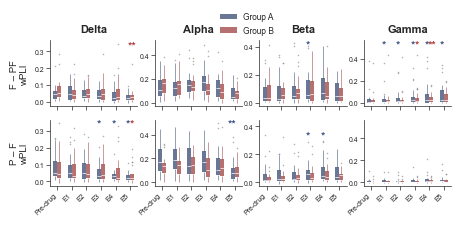

In [35]:
# ---------------------------------------------------------------
# CONFIG ─────────────────────────────────────────────────────────
# BLUE = "#1f3b73"  # Dark Blue
# RED = "#a82323"  # Dark Red
# ---------------------------------------------------------------

# ------------------------------------------------------------------
# 0)  Significant‑result look‑ups  (unchanged)
# ------------------------------------------------------------------

sig_bw = {(r.region_pair, r.band, r.segment): True
          for _, r in stats_df.iterrows() if r.sig}
q_bw = {(r.region_pair, r.band, r.segment): r.q for _, r in stats_df.iterrows()}


sig_A  = {(r.region_pair, r.band, r.segment): True
          for _, r in tests.iterrows()
          if r.group == "Group A" and r.sig}
q_A = {(r.region_pair, r.band, r.segment): r.q
          for _, r in tests.iterrows()
          if r.group == "Group A" }

sig_B  = {(r.region_pair, r.band, r.segment): True
          for _, r in tests.iterrows()
          if r.group == "Group B" and r.sig}
q_B = {(r.region_pair, r.band, r.segment): r.q
          for _, r in tests.iterrows()
          if r.group == "Group B" }
# ------------------------------------------------------------------
# 1)  Weight helper  +  weighted quantile
# ------------------------------------------------------------------
if USE_IPW:
    if "ipw_stabilized" not in df.columns:
        raise ValueError("USE_IPW=True but ‘ipw_stabilized’ not in df")

# def wquantile(v, w, q):
#     v, w = np.asarray(v), np.asarray(w, float)
#     m    = ~(np.isnan(v) | np.isnan(w))
#     v, w = v[m], w[m]
#     if v.size == 0 or w.sum() == 0: return np.nan
#     idx  = np.argsort(v)
#     v, w = v[idx], w[idx]
#     cdf  = np.cumsum(w) / w.sum()

#     return v[np.searchsorted(cdf, q)]

def gen_significance_string(p_value, marker='*'):
    if p_value < 0.001:
        return marker * 3
    elif p_value < 0.01:
        return marker * 2
    elif p_value < 0.05:
        return marker
    else:
        return ' '

# ------------------------------------------------------------------
# 2)  Plot
# ------------------------------------------------------------------
n_rows, n_cols = len(pairs), len(bands)

plot_width = 350
plot_height = 150

fig, axes = plt.subplots(n_rows, n_cols,
                        #  figsize=(3*n_cols, 2*n_rows),
                        figsize = (plot_width/72, plot_height/72),
                        sharex=True)

for r, (ia, ib) in enumerate(pairs):
    rp = f"{all_region_names[ia]}–{all_region_names[ib]}"
    for c, band in enumerate(bands):
        ax   = axes[r, c]
        dat0 = df[(df.region_pair == rp) & (df.band == band)]
        seg_list = ["Pre-drug"] + SEGMENTS
        
        if USE_IPW:  # -------- weighted boxes drawn manually --------
            
            for s_idx, seg in enumerate(seg_list):
                boxwidth = 0.32
                for g_idx, grp, color in [(0, "Group A", BLUE),
                                          (1, "Group B", RED)]:
                    vals = dat0.loc[(dat0.segment==seg)&(dat0.group==grp),"value"]
                    wts  = dat0.loc[(dat0.segment==seg)&(dat0.group==grp),"ipw_stabilized"]
                    if vals.empty: continue
                    q1  = wquantile(vals, wts, .25)
                    med = wquantile(vals, wts, .50)
                    q3  = wquantile(vals, wts, .75)
                    lo  = wquantile(vals, wts, .05)
                    hi  = wquantile(vals, wts, .95)
                    x   = s_idx - .18 + .36*g_idx         # dodge groups
                    ax.add_patch(plt.Rectangle((x-boxwidth/2, q1), boxwidth, q3-q1,
                                               facecolor=color, alpha=0.7,
                                               lw=0))
                    ax.plot([x-(boxwidth*0.9)/2, x+(boxwidth*0.9)/2],[med,med], color='w', lw=0.5)

                    # Whiskers
                    ax.vlines(x, lo, q1, color=color, lw=0.5, alpha=0.7)
                    ax.vlines(x, q3, hi, color=color, lw=0.5, alpha=0.7)

        else:        # -------- simple seaborn boxplot ---------------
            sns.boxplot(
                data=dat0,
                x="segment", y="value", hue="group",
                palette=[BLUE, RED],
                width=.55,
                showcaps=False,
                boxprops=dict(alpha=.7, linewidth=0),
                medianprops=dict(color='white', linewidth=0.5),
                whiskerprops=dict(linewidth=0.5, linestyle='--'),
                flierprops=dict(marker='x', 
                                markersize=0.5,  # ← smaller outliers
                                markerfacecolor='gray', 
                                markeredgecolor='gray', 
                                alpha=.6),
                ax=ax
            )

            # ── Match whisker colour to its box’s fill ────────────────────────────────
            whiskers = [l for l in ax.lines
            if l.get_linestyle() == '--' and l.get_marker() == '']

            # There are exactly two whiskers per box, so pair them up
            for patch, w1, w2 in zip(ax.patches, whiskers[::2], whiskers[1::2]):
                colour = patch.get_facecolor()
                w1.set_color(colour)
                w1.set_linestyle('-')
                w2.set_color(colour)
                w2.set_linestyle('-')

            if r == 0 and c == 0:
                legend_lines, legend_labels = ax.get_legend_handles_labels()

            ax.get_legend().remove()

        ax.set_xticks(range(len(seg_list)))
        ax.set_xticklabels(seg_list, rotation=45, ha="right")

        # labels / titles
        if c == 0:
            lbl = f"{region_acrs[all_region_names[ia]]} – " \
                  f"{region_acrs[all_region_names[ib]]}\nwPLI"
            ax.set_ylabel(lbl, fontsize=7)
        else:       
            ax.set_ylabel("")
        
        if r == 0:  ax.set_title(band, fontsize=8, fontweight="bold")
        ax.set_xlabel("")
        ax.tick_params(labelsize=5, length=3)

        # --------------- significance markers ------------------
        y_max = ax.get_ylim()[1]
        for s_idx, seg in enumerate(["Pre-drug"]+SEGMENTS): 
            if sig_bw.get((rp, band, seg)):
                ax.text(s_idx, y_max*1.03, '#' , ha="center",
                        va="bottom", fontsize=5, fontweight="bold") #gen_significance_string(q_bw.get((rp, band, seg)), '#')
            if sig_A.get((rp, band, seg)):
                ax.text(s_idx-.15, y_max*.85, gen_significance_string(q_A.get((rp, band, seg)), '*'), color=BLUE,
                        ha="center", va="bottom", fontsize=8) # gen_significance_string(q_A.get((rp, band, seg)), '*')
            if sig_B.get((rp, band, seg)):
                ax.text(s_idx+.15, y_max*.85, gen_significance_string(q_B.get((rp, band, seg)), '*'), color=RED,
                        ha="center", va="bottom", fontsize=8) # gen_significance_string(q_B.get((rp, band, seg)), '*')


# align Y‑ranges per column
for c in range(n_cols):
    ymin = min(axes[r, c].get_ylim()[0] for r in range(n_rows))
    ymax = max(axes[r, c].get_ylim()[1] for r in range(n_rows))
    for r in range(n_rows):
        axes[r, c].set_ylim(ymin, ymax)


plt.subplots_adjust(right=0.95, bottom=0.15, top=0.85)

# Add legend
ax_legend = fig.add_subplot([0.48, 0.88, 0.1, 0.1])
ax_legend.legend(legend_lines, legend_labels, frameon=False, title='', loc='center', fontsize=6)
ax_legend.spines['bottom'].set_visible(False)
ax_legend.spines['left'].set_visible(False)
ax_legend.set_xticks([])
ax_legend.set_yticks([])
ax_legend.tick_params(bottom=False, left=False)


# Save the figure
main_dir = 'D:/Anesthesia_Research_Fellow/analysis_results'
filename = 'connectivity_in_frequency_bands_equal_post_segments'
if USE_IPW:
    filename += '_IPW'
file_path = os.path.join(main_dir, filename + '.pdf')

plt.savefig(file_path, format='pdf', dpi=300)

# plt.tight_layout()
plt.show()

##### Shift in Center-of-Mass Frequency (7–20 Hz) Relative to Pre-Drug Baseline Across Emergence Segments

In [20]:
from scipy.stats import wilcoxon, ranksums
from statsmodels.stats.multitest import multipletests

# ─────────────────────────── USER FLAGS ────────────────────────────
COM_RANGE      = (7, 20)     # Hz
SUBTRACT_PRE   = True        # between‑group: use Δf (post‑pre) if True
FDR_Q          = 0.05
N_PERM         = 10_000
RNG_SEED       = 42
OUTFILE        = "COM_results.xlsx"
# ───────────────────────────────────────────────────────────────────

# 0) ------------ build centre‑of‑mass table ------------------------
records = []
for grp, subj_list in groups_map.items():
    for subj in subj_list:
        # pre‑drug
        arr_pre = np.asarray(conn_wpli_win_anat[subj]['pre_drug'])
        for i, j in pairs:
            spec = np.nanmean(arr_pre[i, j, :, :], axis=1)
            idx  = (freqs>=COM_RANGE[0]) & (freqs<=COM_RANGE[1])
            fcom = (np.nansum(spec[idx]*freqs[idx]) /
                    np.nansum(spec[idx])) if np.nansum(spec[idx])>0 else np.nan
            records.append({"subject":subj,"region_pair":f"{all_region_names[i]}–{all_region_names[j]}",
                            "segment":"Pre-drug","group":grp,"f_com":fcom})
        # post segments
        arr_post = np.asarray(conn_wpli_win_anat_resampled[subj]['post_drug'])
        for seg_idx,t_idx in enumerate(time_idx_post,1):
            for i,j in pairs:
                spec = np.nanmean(arr_post[i,j,:,t_idx],axis=0)
                idx  = (freqs>=COM_RANGE[0]) & (freqs<=COM_RANGE[1])
                fcom = (np.nansum(spec[idx]*freqs[idx]) /
                        np.nansum(spec[idx])) if np.nansum(spec[idx])>0 else np.nan
                records.append({"subject":subj,"region_pair":f"{all_region_names[i]}–{all_region_names[j]}",
                                "segment":f"E{seg_idx}","group":grp,"f_com":fcom})

df_com = pd.DataFrame(records)
SEGMENTS = [c for c in df_com.segment.unique() if c!="Pre-drug"]

# 1) ------------ attach IPWs (optional) ----------------------------
if USE_IPW:
    df_com = df_com.merge(patients_conf_vars_ipw_df,
                          left_on="subject",
                          right_on="Patient_Label",
                          how="left")
    if df_com["ipw_stabilized"].isna().any():
        raise ValueError("Missing IPW for some subjects.")
    ipw_lookup = (df_com[["subject","ipw_stabilized"]]
                  .drop_duplicates("subject")
                  .set_index("subject")["ipw_stabilized"])
else:
    ipw_lookup = pd.Series(1.0,
                           index=df_com["subject"].unique(),
                           name="ipw")

# helper to fetch a numpy vector of weights
get_w = lambda idx: ipw_lookup.loc[idx].to_numpy()

def wquant(v,w,q):
    v,w = np.asarray(v),np.asarray(w,float)
    m=~(np.isnan(v)|np.isnan(w)); v,w=v[m],w[m]
    if v.size==0 or w.sum()==0: return np.nan
    order=np.argsort(v); v,w=v[order],w[order]; c=np.cumsum(w)/w.sum()
    return v[np.searchsorted(c,q)]

rng = np.random.default_rng(RNG_SEED)
rows=[]

for rp, sub in df_com.groupby("region_pair"):
    for seg in SEGMENTS:
        seg_sub = sub[sub.segment.isin(["Pre-drug", seg])]


        # ------ within‑group tests --------------------------------
        within={}
        for grp in ["Group A","Group B"]:
            piv = (seg_sub[seg_sub.group==grp]
                   .pivot(index="subject",columns="segment",values="f_com"))
            if "Pre-drug" not in piv or seg not in piv: continue
            base,post = piv["Pre-drug"],piv[seg]
            idx = base.index[base.notna() & post.notna()]
            n=len(idx)

            if n<3: continue
            
            diffs = post[idx]-base[idx]
            wts = get_w(idx)

            if USE_IPW:
                obs = wquant(diffs,wts,0.5)
                null=[wquant(diffs*rng.choice([-1,1],n),wts,0.5)
                      for _ in range(N_PERM)]
                p_w = ((np.abs(null)>=abs(obs)).sum()+1)/(N_PERM+1)
            else:
                obs,p_w = wilcoxon(post[idx],base[idx])

            med  = wquant(post[idx],wts,0.5) if USE_IPW else np.nanmedian(post[idx])
            i25  = wquant(post[idx],wts,0.25) if USE_IPW else np.nanpercentile(post[idx],25)
            i75  = wquant(post[idx],wts,0.75) if USE_IPW else np.nanpercentile(post[idx],75)
            within[grp]=dict(med=med,i25=i25,i75=i75,n=n,p=p_w)
        
        if len(within)<2: continue


        # ------ between‑group -------------------------------------
        pivA = (seg_sub[seg_sub.group=="Group A"]
                .pivot(index="subject",columns="segment",values="f_com"))
        pivB = (seg_sub[seg_sub.group=="Group B"]
                .pivot(index="subject",columns="segment",values="f_com"))
        if "Pre-drug" not in pivA or seg not in pivA or "Pre-drug" not in pivB or seg not in pivB:
            continue
        valA = pivA[seg]; valB=pivB[seg]
        if SUBTRACT_PRE:
            valA = valA - pivA["Pre-drug"]
            valB = valB - pivB["Pre-drug"]
        valA = valA.dropna(); valB=valB.dropna()
        if len(valA)<1 or len(valB)<1: continue

        wA = get_w(valA.index)
        wB = get_w(valB.index)

        if USE_IPW:
            # weighted Δ median for each group
            A_dmed  = wquant(valA, wA, 0.50)
            A_di25  = wquant(valA, wA, 0.25)
            A_di75  = wquant(valA, wA, 0.75)
            B_dmed  = wquant(valB, wB, 0.50)
            B_di25  = wquant(valB, wB, 0.25)
            B_di75  = wquant(valB, wB, 0.75)

            # keep the permutation p‑value (or rank‑sum U if USE_IPW=False)
            diff_obs = A_dmed - B_dmed
            pool  = pd.concat([valA, valB])
            w_pool = np.concatenate([wA, wB])
            labels = np.array([0]*len(valA) + [1]*len(valB))
            null = []
            for _ in range(N_PERM):
                rng.shuffle(labels)
                m = labels == 0
                null.append(wquant(pool[m], w_pool[m], 0.5) -
                            wquant(pool[~m], w_pool[~m], 0.5))
            p_bt = ((np.abs(null) >= abs(diff_obs)).sum() + 1) / (N_PERM + 1)
            stat_bt = diff_obs
        else:
            A_dmed  = np.nanmedian(valA); A_di25 = np.nanpercentile(valA, 25); A_di75 = np.nanpercentile(valA, 75)
            B_dmed  = np.nanmedian(valB); B_di25 = np.nanpercentile(valB, 25); B_di75 = np.nanpercentile(valB, 75)
            diff_obs, p_bt = ranksums(valA, valB)
            stat_bt = diff_obs


        rows.append({
            "region_pair": rp,
            "segment": seg,
            #----------within_group columns-----------
            "A_median": within["Group A"]["med"],
            "A_iqr25": within["Group A"]["i25"],
            "A_iqr75": within["Group A"]["i75"],
            "A_n": within["Group A"]["n"],
            "A_p_within": within["Group A"]["p"],
            "B_median": within["Group B"]["med"],
            "B_iqr25": within["Group B"]["i25"],
            "B_iqr75": within["Group B"]["i75"],
            "B_n": within["Group B"]["n"],
            "B_p_within": within["Group B"]["p"],
            #-----------baseline-corrected medians and between_group_columns-----
            "A_dmed": A_dmed, "A_di25": A_di25, "A_di75": A_di75,
            "B_dmed": B_dmed, "B_di25": B_di25, "B_di75": B_di75,
            "Diff": stat_bt,
            "p_between": p_bt
        })

res = pd.DataFrame(rows)
res["q_between"] = multipletests(res["p_between"], alpha=FDR_Q, method="fdr_bh")[1]

# ------------------------------------------------------------------
# 1)  Compute within‑group q‑values (per region‑pair)
# ------------------------------------------------------------------
res["A_q_within"] = np.nan
res["B_q_within"] = np.nan

for rp, sub in res.groupby("region_pair"):
    # Group A
    qA = multipletests(sub["A_p_within"], alpha=FDR_Q, method="fdr_bh")[1]
    res.loc[sub.index, "A_q_within"] = qA
    # Group B
    qB = multipletests(sub["B_p_within"], alpha=FDR_Q, method="fdr_bh")[1]
    res.loc[sub.index, "B_q_within"] = qB

# ------------------------------------------------------------------
# 2)  Build compact columns
# ------------------------------------------------------------------
def pq_string(p, q):
    return f"{p:.4f} ({q:.4f})"

def flag(p, q):
    return ("★" if p < 0.05 else "") + ("†" if q < FDR_Q else "")

# Within stats
res["Group A median (IQR)"] = res.apply(
    lambda r: f"{r.A_median:.2f} ({r.A_iqr25:.2f}–{r.A_iqr75:.2f})", axis=1)
res["Group B median (IQR)"] = res.apply(
    lambda r: f"{r.B_median:.2f} ({r.B_iqr25:.2f}–{r.B_iqr75:.2f})", axis=1)

res["Group A p(q)"] = res.apply(
    lambda r: pq_string(r.A_p_within, r.A_q_within) + " " + flag(r.A_p_within, r.A_q_within),
    axis=1)
res["Group B p(q)"] = res.apply(
    lambda r: pq_string(r.B_p_within, r.B_q_within) + " " + flag(r.B_p_within, r.B_q_within),
    axis=1)

# baseline_corrected between stats
res["Group A Δmedian (IQR)"] = res.apply(
    lambda r: f"{r.A_dmed:.2f} ({r.A_di25:.2f}–{r.A_di75:.2f})", axis=1)
res["Group B Δmedian (IQR)"] = res.apply(
    lambda r: f"{r.B_dmed:.2f} ({r.B_di25:.2f}–{r.B_di75:.2f})", axis=1)

res["p(q) between"] = res.apply(
    lambda r: pq_string(r.p_between, r.q_between) + " " + flag(r.p_between, r.q_between),
    axis=1)

# df columns
res["df_A"] = res["A_n"] - 1
res["df_B"] = res["B_n"] - 1

# descriptive label for between‑group statistic
diff_label = ("Weighted median Δf (A − B) (Hz)" if USE_IPW
              else "Wilcoxon U (A vs B)")

# ------------------------------------------------------------------
# 3)  Assemble final table
# ------------------------------------------------------------------
table = (res[["region_pair","segment",
              "Group A median (IQR)","df_A","Group A p(q)",
              "Group B median (IQR)","df_B","Group B p(q)",
              "Group A Δmedian (IQR)","Group B Δmedian (IQR)",
              "Diff","p(q) between"]]
         .rename(columns={
             "df_A":"df_A",
             "df_B":"df_B",
             "Diff": diff_label
         })
         .sort_values(["region_pair","segment"])
         .reset_index(drop=True))

# blank repeated region‑pair labels
table.loc[table["region_pair"].duplicated(), "region_pair"] = ""

# ------------------------------------------------------------------
# 4)  Export to Excel with auto‑width columns
# ------------------------------------------------------------------
import xlsxwriter
with pd.ExcelWriter("COM_results.xlsx", engine="xlsxwriter") as xw:
    table.to_excel(xw, sheet_name="COM", index=False)
    ws = xw.sheets["COM"]
    for c, col in enumerate(table.columns):
        width = min(max(table[col].astype(str).str.len().max(), len(col)) + 2, 50)
        ws.set_column(c, c, width)

print("Saved COM_results.xlsx - within & between stats, compact columns")

Saved COM_results.xlsx - within & between stats, compact columns


##### Connectivity AUC and alpha band COM frequency- Across Post-drug segments and Pre-drug 

In [36]:
# ----------------------------------------------------------------------
# NEW containers for AUC and α-COM (median / IQR)  ─────────────────────
# shape: (num_regions, num_regions, n_divisions_or_1)
auc_stats = {
    g: {
        'pre_drug':  {'median': np.zeros((num_regions, num_regions, 1)),
                      'iqr_low': np.zeros((num_regions, num_regions, 1)),
                      'iqr_high':np.zeros((num_regions, num_regions, 1))},
        'post_drug': {'median': np.zeros((num_regions, num_regions, n_divisions)),
                      'iqr_low': np.zeros((num_regions, num_regions, n_divisions)),
                      'iqr_high':np.zeros((num_regions, num_regions, n_divisions))}
    } for g in ["Group A", "Group B"]
}

com_alpha_stats = {
    g: {
        'pre_drug':  {'median': np.zeros((num_regions, num_regions, 1)),
                      'iqr_low': np.zeros((num_regions, num_regions, 1)),
                      'iqr_high':np.zeros((num_regions, num_regions, 1))},
        'post_drug': {'median': np.zeros((num_regions, num_regions, n_divisions)),
                      'iqr_low': np.zeros((num_regions, num_regions, n_divisions)),
                      'iqr_high':np.zeros((num_regions, num_regions, n_divisions))}
    } for g in ["Group A", "Group B"]
}

ALPHA_BAND = (7, 20)
alpha_mask = (freqs >= ALPHA_BAND[0]) & (freqs <= ALPHA_BAND[1])

# ----------------------------------------------------------------------
# MAIN loop (insert inside your existing loop; replaces nothing) ───────
# ----------------------------------------------------------------------
for group_patients, g_name in zip([groups['A'], groups['B']], ["Group A", "Group B"]):
    for epoch in ['pre_drug', 'post_drug']:

        time_partitions = [slice(None)] if epoch == 'pre_drug' else time_idx_post

        # shorter aliases
        med_sp = spectral_stats[g_name][epoch]['median']
        low_sp = spectral_stats[g_name][epoch]['iqr_low']
        hi_sp  = spectral_stats[g_name][epoch]['iqr_high']

        med_auc = auc_stats[g_name][epoch]['median']
        low_auc = auc_stats[g_name][epoch]['iqr_low']
        hi_auc  = auc_stats[g_name][epoch]['iqr_high']

        med_com = com_alpha_stats[g_name][epoch]['median']
        low_com = com_alpha_stats[g_name][epoch]['iqr_low']
        hi_com  = com_alpha_stats[g_name][epoch]['iqr_high']

        for ia in range(num_regions):
            for ib in range(num_regions):
                if ia < ib:
                    continue

                for div, t_idx in enumerate(time_partitions):

                    profiles, weights = [], []

                    for p in group_patients:

                        # pull subject matrix (freq × time)
                        if epoch=='pre_drug':
                            dat = conn_wpli_win_anat[p][epoch][ia, ib, :, t_idx]
                        elif epoch=='post_drug':
                            dat = conn_wpli_win_anat_resampled[p][epoch][ia, ib, :, t_idx].T
                        
                        # dat = (conn_wpli_win_anat_resampled if epoch == 'post_drug'
                        #        else conn_wpli_win_anat)[p][epoch][ia, ib, :, t_idx]

                        if np.nansum(dat) == 0:
                            continue

                        subj_profile = np.nanmedian(dat, axis=1)  # time-collapse
                        profiles.append(subj_profile)
                        weights.append(w(p))

                    if not profiles:          # no contributing subject
                        med_sp[ia, ib, div, :] = np.nan
                        low_sp[ia, ib, div, :] = np.nan
                        hi_sp [ia, ib, div, :] = np.nan
                        med_auc[ia, ib, div]   = np.nan
                        low_auc[ia, ib, div]   = np.nan
                        hi_auc [ia, ib, div]   = np.nan
                        med_com[ia, ib, div]   = np.nan
                        low_com[ia, ib, div]   = np.nan
                        hi_com [ia, ib, div]   = np.nan
                        continue

                    arr = np.vstack(profiles)               # (n_subj × n_freq)
                    wts = np.asarray(weights)

                    # -------- per-frequency stats (unchanged) -------------
                    if USE_IPW:
                        med_vec  = [wquantile(arr[:, f], wts, 0.50) for f in range(len(freqs))]
                        low_vec  = [wquantile(arr[:, f], wts, 0.25) for f in range(len(freqs))]
                        hi_vec   = [wquantile(arr[:, f], wts, 0.75) for f in range(len(freqs))]
                    else:
                        med_vec  = np.nanmedian(arr, axis=0)
                        low_vec  = np.nanpercentile(arr, 25, axis=0)
                        hi_vec   = np.nanpercentile(arr, 75, axis=0)

                    med_sp[ia, ib, div, :] = med_vec
                    low_sp[ia, ib, div, :] = low_vec
                    hi_sp [ia, ib, div, :] = hi_vec

                    # -------- NEW: AUC per subject ------------------------
                    auc_vals = np.trapz(arr, freqs, axis=1)          # (n_subj,)

                    # -------- NEW: α-COM per subject ---------------------
                    alpha_pow = arr[:, alpha_mask]
                    num = np.sum(alpha_pow * freqs[alpha_mask], axis=1)
                    den = np.sum(alpha_pow, axis=1)
                    com_vals = np.where(den > 0, num / den, np.nan)

                    # -------- aggregate with or without IPW --------------
                    def agg(x, q):
                        return wquantile(x, wts, q) if USE_IPW else np.nanpercentile(x, q*100)

                    med_auc[ia, ib, div] = agg(auc_vals, 0.50)
                    low_auc[ia, ib, div] = agg(auc_vals, 0.25)
                    hi_auc [ia, ib, div] = agg(auc_vals, 0.75)

                    med_com[ia, ib, div] = agg(com_vals, 0.50)
                    low_com[ia, ib, div] = agg(com_vals, 0.25)
                    hi_com [ia, ib, div] = agg(com_vals, 0.75)


Group A


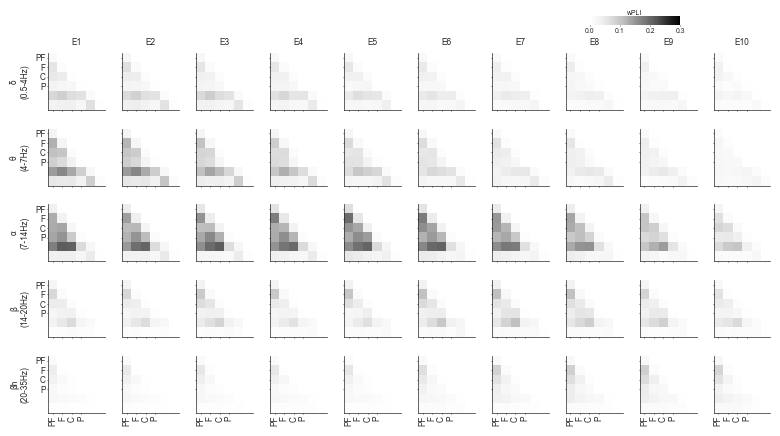

Group B


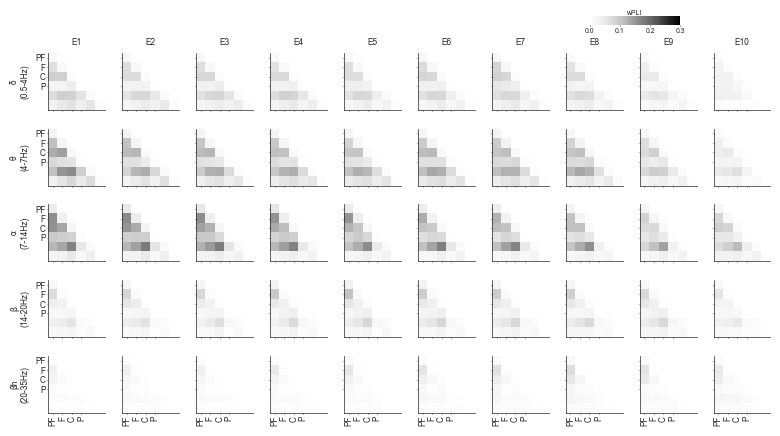

In [17]:
# Plot the wPLI matrices over time for each group
for group_idx , group_name in enumerate(["Group A", "Group B"]):
    print(group_name)
    group_pli = copy.deepcopy(pli)
    group_pli.conn_wpli_win_anat['emergence'] = conn_win_anta_group[group_name]
    group_pli.conn_wpli_win_favg_anat['emergence'] = conn_win_favg_anta_group[group_name]

    group_pli.region_names = region_names
    group_pli.win_centers['emergence'] = np.linspace(0,number_target_time_points, number_target_time_points)

    # plot the wPLI heatmaps
    plot_wPLI_matrix_over_time(group_pli, 'emergence', fbands, num_windows=10, colormap='Greys')

    # Save the figure
    main_dir = 'D:/Anesthesia_Research_Fellow/analysis_results'
    filename = f'{group_name}_emergence_wPLI_matrix_over_time.pdf'
    file_path = os.path.join(main_dir, filename)

    plt.savefig(file_path, format='pdf', dpi=300)
    plt.show()

Group A


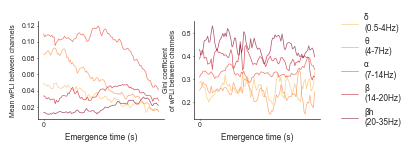

Group B


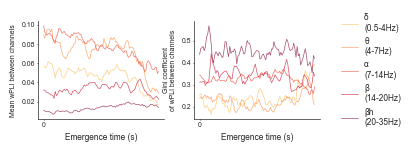

In [18]:
for group_idx , group_name in enumerate(["Group A", "Group B"]):
    print(group_name)
    group_pli = copy.deepcopy(pli)
    group_pli.conn_wpli_win_anat['emergence'] = conn_win_anta_group[group_name]
    group_pli.conn_wpli_win_favg_anat['emergence'] = conn_win_favg_anta_group[group_name]

    group_pli.region_names = region_names
    group_pli.win_centers['emergence'] = np.linspace(0, number_target_time_points, number_target_time_points)

    # plot the wPLI heatmaps
    plot_wPLI_metrics(group_pli, 'emergence', fbands)

    # Save the figure
    main_dir = 'D:/Anesthesia_Research_Fellow/analysis_results'
    filename = f'{group_name}_emergence_wPLI_metrics.pdf'
    file_path = os.path.join(main_dir, filename)

    plt.savefig(file_path, format='pdf', dpi=300)
    plt.show()

### PCA and K-Means Clustering Analysis on Connectivity Data

In [21]:
# Exclude occipital region, as it is missing in some patients.  
# Including it could lead to K-Means clustering inconsistencies,  
# where clusters might split based on the presence or absence of occipital EEG.

region_names = [region for region in all_region_names if region not in {'occipital', 'temporal' }] 

# Get indices of selected regions in the original data
region_indices = [all_region_names.index(region) for region in region_names]

num_regions = len(region_names)

In [22]:
epoch = 'emergence'

# Initialize an empty list to hold the flattened data along with patient and group names
patient_data_list = []

# Decrease the frequency resolution of the wPLI matrices
# filter to only frequencies below 35 Hz
number_resmapled_freqs = 70
freqs_low_res = np.linspace(0.5, 35, number_resmapled_freqs)

# Process each patient separately
for group, group_name in zip([groups['A'], groups['B']], ["Group A", "Group B"]):
    for p_name in group:
        current_conn_win_anta = conn_wpli_win_anat[p_name][epoch]

        valid_window_idx = conn_wpli_valid_window_indices[p_name][epoch]
        num_valid_windows = valid_window_idx.sum()
        # if len(valid_window_idx) > 0:
        #     current_conn_win_anta = current_conn_win_anta[:, :, :, valid_window_idx]

        if len(current_conn_win_anta) == 0:
            continue
        
        # Generate the low-frequency resolution data for the patient
        number_of_time_points = current_conn_win_anta.shape[-1]
        conn_win_anta_patient_low_freq_res = np.zeros((num_regions, num_regions, number_resmapled_freqs, number_of_time_points))
                
         # Interpolate the data for each selected region pair and time point
        for reg_idx_a, orig_idx_a in enumerate(region_indices):
            for reg_idx_b, orig_idx_b in enumerate(region_indices):
                if reg_idx_a >= reg_idx_b:
                    for time_idx in range(number_of_time_points):
                        conn_win_anta_patient_low_freq_res[reg_idx_a, reg_idx_b, :, time_idx] = np.interp(
                            freqs_low_res, freqs, current_conn_win_anta[orig_idx_a, orig_idx_b, :, time_idx])

        # Flatten the data and store along with patient name and group
        flattened_data = []
        for reg_idx_a in range(num_regions):
            for reg_idx_b in range(num_regions):
                if reg_idx_a > reg_idx_b:
                    flattened_data.append(conn_win_anta_patient_low_freq_res[reg_idx_a, reg_idx_b, :, :])

        # Convert flattened data into a single array
        flattened_data = np.concatenate(flattened_data, axis=0)
        
        # Create a dictionary to hold the data and related info
        patient_data_list.append({
            'patient_name': p_name,
            'group_name': group_name,
            'data': conn_win_anta_patient_low_freq_res,
            'flatten_data': flattened_data,
            'win_centers': win_centers[p_name][epoch],
            'valid_window_idx': valid_window_idx,
            'num_valid_windows': num_valid_windows
        })

# Convert the list into a DataFrame for easier access and manipulation
df_patient_data = pd.DataFrame(patient_data_list)
# NOTE: In df_patient_data, missing time points are inlcuded in (and have not been removed from) the data arrays corresponding to each patient 

In [62]:
# Remove the patients lacking clean temporal data from the rest of the analysis
# patients_to_exlucde = {
#     'CA-05',
#     'CA-15',
#     'CA-19',
#     'CA-14',
#     'CA-48',
#     'CA-56',
#     'CA-69'
# }

patients_to_exlucde = {}
df_patient_data = df_patient_data[~df_patient_data['patient_name'].isin(patients_to_exlucde)]

In [24]:
# Merge patient age information into df_patient_data
df_patient_data = df_patient_data.merge(patients_conf_vars_ipw_df, left_on='patient_name', right_on='Patient_Label', how='left')

In [25]:
### Preparing data for PCA/Kmeans analysis

# Function to filter flatten_data using valid_window_idx
def filter_valid_data(row):
    # return np.array(row['flatten_data_w'])[:, row['valid_window_idx']]
    return np.array(row['flatten_data'])[:, row['valid_window_idx']]

# concatenate the data for each group
group_a_data = (
    df_patient_data[df_patient_data['group_name'] == "Group A"]
    .apply(filter_valid_data, axis=1)
    .to_numpy()
)
group_b_data = (
    df_patient_data[df_patient_data['group_name'] == "Group B"]
    .apply(filter_valid_data, axis=1)
    .to_numpy()
)

conn_win_anat_low_freq_res_group = {}
conn_win_anat_low_freq_res_group['Group A'] = np.concatenate(group_a_data, axis=1)
conn_win_anat_low_freq_res_group['Group B'] = np.concatenate(group_b_data, axis=1)

# Concatenate the data from both groups
conn_win_anat_low_freq_res_concatenated_all_groups = np.concatenate([conn_win_anat_low_freq_res_group['Group A'], conn_win_anat_low_freq_res_group['Group B']], axis=1)

# Verify the shape of the concatenated data
print(f"The shape of the concatenated data (number of features, number of time windows) is: {conn_win_anat_low_freq_res_concatenated_all_groups.shape}")

The shape of the concatenated data (number of features, number of time windows) is: (420, 4879)


In [26]:
# --- helper to replicate each patient’s weight ---
def expand_ipw(row):
    """
    Build a 1-D array filled with the patient's stabilized IPW.
    Its length equals the number of **valid** time-windows
    that were kept for this patient.
    """
    n_valid = np.count_nonzero(row["valid_window_idx"])
    return np.full(n_valid, row["ipw_stabilized"], dtype=float)

# --- build the per-group lists in the *same* order used for the data arrays ---
group_a_ipw_expanded = (
    df_patient_data[df_patient_data['group_name'] == "Group A"]
    .apply(expand_ipw, axis=1)
    .to_numpy()      # gives an object array of 1-D np.arrays
)

group_b_ipw_expanded = (
    df_patient_data[df_patient_data['group_name'] == "Group B"]
    .apply(expand_ipw, axis=1)
    .to_numpy()
)

# --- concatenate exactly the way you did for the data ---
ipw_per_timepoint = np.concatenate(
    [np.concatenate(group_a_ipw_expanded), np.concatenate(group_b_ipw_expanded)],
    axis=0
)

print(f"The length of concatenated IPWs for the corresponding time windows is: {len(ipw_per_timepoint)}")

assert (
    ipw_per_timepoint.shape[0]
    == conn_win_anat_low_freq_res_concatenated_all_groups.shape[1]
), "Mismatch between IPW vector length and data's time-point dimension."

The length of concatenated IPWs for the corresponding time windows is: 4879


##### Covariance Matrix of the raw data, prior to any transformation

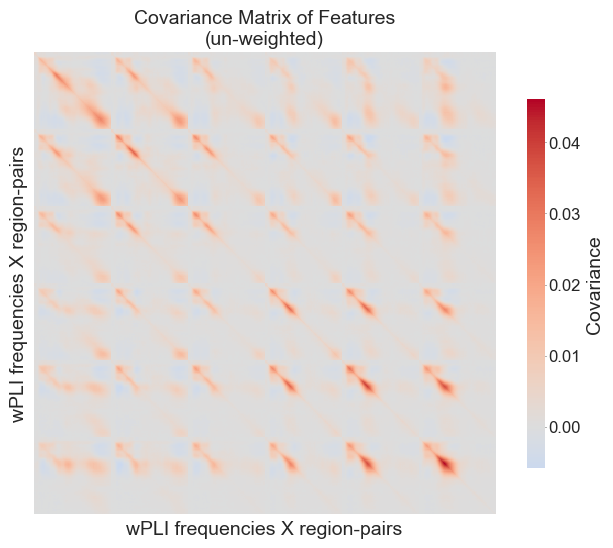

In [63]:
# ----------------------------------------------------------------
# Toggle here
# ----------------------------------------------------------------
USE_IPW = False

# ----------------------------------------------------------------
# Helper functions 
# ----------------------------------------------------------------
def weighted_cov(X, weights):
    """
    Weighted covariance of a matrix whose rows are variables and columns are samples.
    Returns an (n_var × n_var) array.
    """
    w   = np.asarray(weights, dtype=float)
    w   = w / w.sum()                       # normalise for numerical stability
    Xc  = X - (X * w).sum(axis=1, keepdims=True)   # weighted centering
    return (Xc * w) @ Xc.T                  # Σ = Xc · diag(w) · Xcᵀ

# ----------------------------------------------------------------------
# Prepare data
# ----------------------------------------------------------------------
X_raw = conn_win_anat_low_freq_res_concatenated_all_groups      # (features, windows)
X_nan = np.where(X_raw == 0, np.nan, X_raw)                     # treat zeros as missing

# ----------------------------------------------------------------------
# Covariance in the original feature space
# -----------------------------------------------------------------------
if USE_IPW:
   cov_matrix = weighted_cov(X_raw, ipw_per_timepoint)
else:
    # ordinary: centre (nan-aware) then un-weighted covariance
    X_centered = X_raw - np.nanmean(X_nan, axis=1, keepdims=True)
    cov_matrix = np.cov(X_centered)

# -----------------------------------------------------------------------
# Visualize
#------------------------------------------------------------------------
plt.figure(figsize=(8, 6))
ax = sns.heatmap(
    cov_matrix, 
    cmap="coolwarm",
    center=0, 
    square=True, 
    xticklabels=False,
    yticklabels=False, 
    cbar_kws={"shrink": 0.8, "label": "Covariance"}
)

cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=12)
cbar.set_label("Covariance", size=14)  

plt.title(
    "Covariance Matrix of Features\n"
    + ("(IPW-weighted)" if USE_IPW else "(un-weighted)"),
    fontsize=14,
)
plt.xlabel("wPLI frequencies X region-pairs", fontsize=14)
plt.ylabel("wPLI frequencies X region-pairs", fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.show()

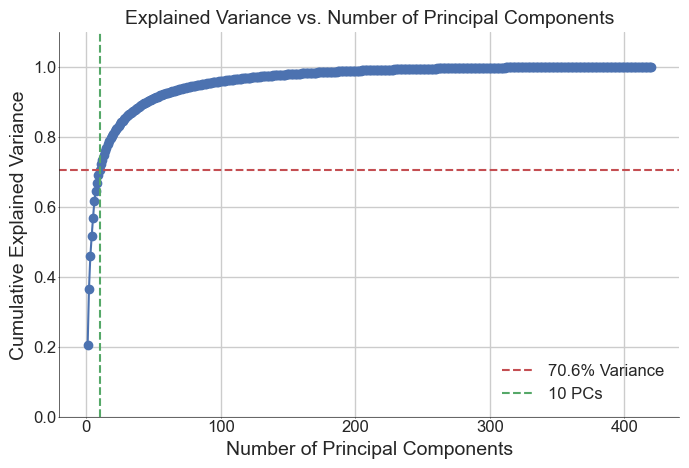

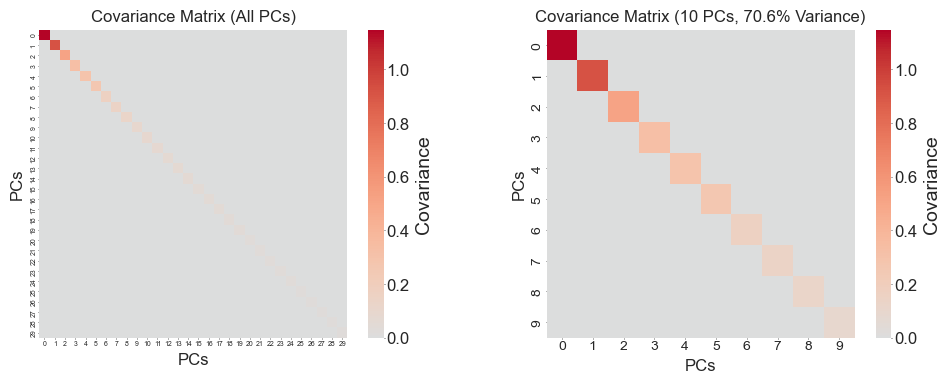

In [64]:
# Perform PCA on the concatenated wPLI matrices

# ---------------------------------------------------------------------
# 1.  Data matrix:  features (rows) × time-windows (cols)
# --------------------------------------------------------------------- 
X = conn_win_anat_low_freq_res_concatenated_all_groups # verify X is of shape (num_features, num_time_points)
num_features, num_time_points = X.shape

# ----------------------------------------------------------------------
# 2. Choose PCA flavor 
# ----------------------------------------------------------------------
if USE_IPW:
    # ------- weighted PCA ---------------------------------------------
    (X_pca_transformed, 
     components,
     varr, 
     evr) = weighted_pca(
         X,
         weights = ipw_per_timepoint
     )
else:
    # ------- Ordinary PCA ---------------------------------------------
    X_centered = X - np.mean(X, axis=1, keepdims=True)
    pca = PCA()
    X_pca_transformed = pca.fit_transform(X_centered.T)  # PCA expects observations as rows, so transpose X
    components = pca.components_
    evr = pca.explained_variance_ratio_


# ----------------------------------------------------------------------
# 3. Pick PCs explaining >= 70 % variance 
# -----------------------------------------------------------------------
explained_variance_ratio = np.cumsum(evr)  # Cumulative sum
num_pc_subset = np.argmax(explained_variance_ratio >= 0.70) + 1  # First index where cumulative variance exceeds 70%

# -----------------------------------------------------------------------
# 4. Explained-variance plot
# -----------------------------------------------------------------------
plt.figure(figsize=(8, 5))
plt.plot(
    range(1, len(explained_variance_ratio) + 1), 
    explained_variance_ratio, 
    marker='o', 
    linestyle='-'
)
plt.axhline(
    y=explained_variance_ratio[num_pc_subset-1], 
    color='r', 
    linestyle='--', 
    label=f"{explained_variance_ratio[num_pc_subset-1]*100:.1f}% Variance"
)
plt.axvline(
    x=num_pc_subset, 
    color='g', 
    linestyle='--', 
    label=f"{num_pc_subset} PCs"
)
plt.xlabel("Number of Principal Components", fontsize=14)
plt.ylabel("Cumulative Explained Variance", fontsize=14)
plt.ylim([0, 1.1])
plt.tick_params(labelsize=12) 
plt.title("Explained Variance vs. Number of Principal Components",  fontsize=14)
plt.legend(fontsize=12)
plt.grid()
plt.show()

# ----------------------------------------------------------------------
# 5. Covariance of PC time series 
# ----------------------------------------------------------------------
if USE_IPW:
    cov_all_pcs = weighted_cov(
        X_pca_transformed.T, 
        ipw_per_timepoint
    )   # all PCs
    cov_subset  = weighted_cov(
        X_pca_transformed[:, :num_pc_subset].T, 
        ipw_per_timepoint
    )  # first k PCs
else:
    cov_all_pcs = np.cov(
        X_pca_transformed.T
    )                              # all PCs
    cov_subset  = np.cov(
        X_pca_transformed[:, :num_pc_subset].T
    )           # first k PCs

# -----------------------------------------------------------------------
# 6. Visualize covariance matrices 
# -----------------------------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

cbar_ax= sns.heatmap(
    cov_all_pcs[:30, :30], 
    cmap="coolwarm", 
    center=0, 
    ax=axes[0]
).collections[0].colorbar

axes[0].set_title("Covariance Matrix (All PCs)", fontsize=12)
axes[0].set_xlabel('PCs', fontsize=12)
axes[0].set_ylabel('PCs', fontsize=12)
axes[0].set_aspect('equal', adjustable='box')
cbar_ax.set_label('Covariance', fontsize=14)
cbar_ax.ax.tick_params(labelsize=12)

cbar_ax = sns.heatmap(
    cov_subset, 
    cmap="coolwarm", 
    center=0, 
    ax=axes[1]
).collections[0].colorbar

axes[1].set_title(
    f"Covariance Matrix ({num_pc_subset} PCs, " 
    f"{explained_variance_ratio[num_pc_subset-1]*100:.1f}% Variance)", 
    fontsize=12
)

axes[1].set_xlabel('PCs', fontsize=12)
axes[1].set_ylabel('PCs', fontsize=12)
axes[1].set_aspect('equal', adjustable='box')
cbar_ax.set_label('Covariance', fontsize=14)
cbar_ax.ax.tick_params(labelsize=12)

plt.tick_params(axis='both', labelsize=10)
plt.show()

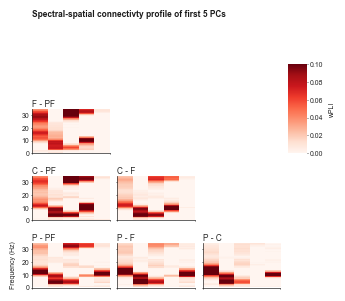

In [65]:
# Plot the top 3 principal components as heatmaps
number_of_pcs_to_plot = 5# num_pc_subset
pc_matrix = np.zeros((len(region_names), len(region_names), freqs_low_res.shape[0], number_of_pcs_to_plot))
for pc_idx in range(number_of_pcs_to_plot):
    pc = components[pc_idx, :]
    t = 0
    for reg_idx_a, region_a in enumerate(region_names):
        for reg_idx_b, region_b in enumerate(region_names):
            if reg_idx_a > reg_idx_b:
                pc_matrix[reg_idx_a, reg_idx_b, :, pc_idx] = pc[t:t+number_resmapled_freqs]
                t += number_resmapled_freqs

# prepare pli object
pc_pli = copy.deepcopy(pli)
pc_pli.conn_wpli_win_anat['emergence'] = pc_matrix
del pc_pli.conn_wpli_win_favg_anat
pc_pli.region_names = region_names
pli.freqs = freqs_low_res
pc_pli.win_centers['emergence'] = np.linspace(0, number_of_pcs_to_plot, number_of_pcs_to_plot)
plot_wPLI_heatmaps(pc_pli, 'emergence', vmax=0.1, max_freq=35, colormap='Reds', xlabel='PCs', title=f'Spectral-spatial connectivty profile of first {number_of_pcs_to_plot} PCs')

main_dir = 'D:/Anesthesia_Research_Fellow/analysis_results'
filename = f'PCs_spectral_spatial_connectivity_profile.pdf'
file_path = os.path.join(main_dir, filename)

plt.savefig(file_path, format='pdf', dpi=300)
plt.show()

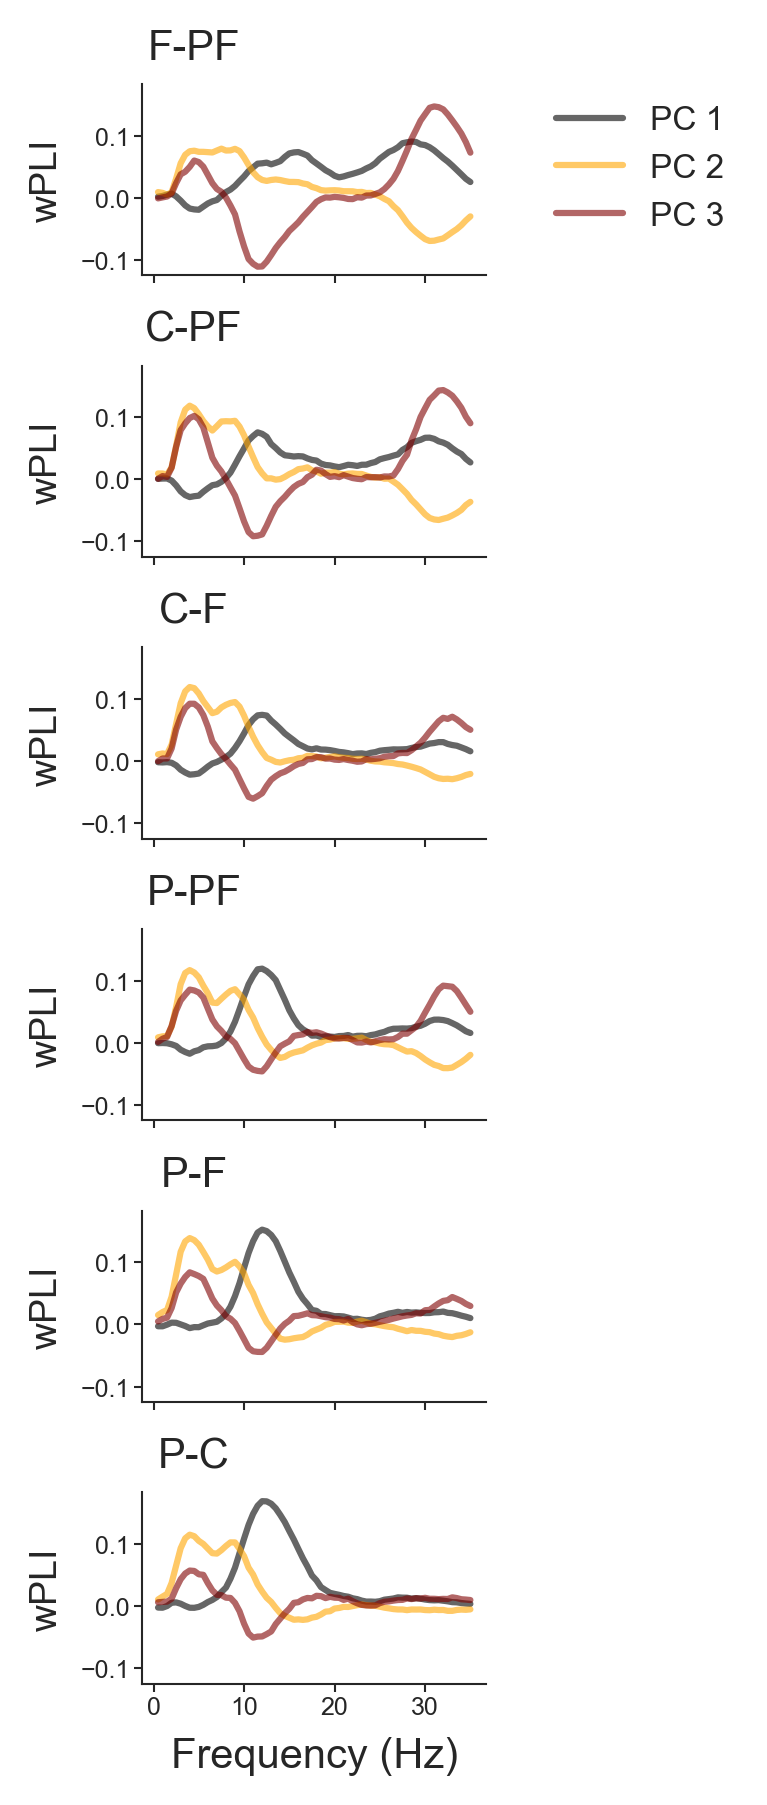

In [66]:
region_acrs =  generate_region_acronyms(region_names)

def plot_pc_profiles(panel_matrix, region_names, freqs):
    """
    Plot the first 3 PCs of each specified region-pair as a 6×1 panel figure,
    with a single legend outside next to the first panel, and custom colors.
    """
    pairs = [(1, 0), (2, 0), (2, 1), (3, 0), (3, 1), (3, 2)]
    colors = ['black', 'orange', 'maroon', 'navy', 'forestgreen']
    n_panels = len(pairs)

    fig, axes = plt.subplots(n_panels, 1, figsize=(2, 1 * n_panels), sharex=True, sharey=True, dpi=300)
    
    for ax, (i, j) in zip(axes, pairs):
        for pc in range(3):  # only first 3 PCs
            ax.plot(freqs, panel_matrix[i, j, :, pc], label=f'PC {pc+1}', color=colors[pc], alpha=0.6)
        ax.set_title(f'{region_acrs[region_names[i]]}-{region_acrs[region_names[j]]}', fontsize=10, x=.15)
        ax.set_ylabel('wPLI', fontsize=9)
        ax.tick_params(labelsize=6, length=2)

    
    axes[-1].set_xlabel('Frequency (Hz)', fontsize=10)

    # Single legend outside next to the first panel
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels,
               loc='upper left',
               bbox_to_anchor=(0.9, 0.95),
               borderaxespad=0.,
               fontsize=8,
               title=None)

    plt.tight_layout(rect=[0, 0, 0.85, 1])
    return fig

fig = plot_pc_profiles(pc_matrix, region_names, freqs)
plt.show()

### Plot the datapoints in the 3D PC space

C:\Users\Kourosh\AppData\Local\Temp\ipykernel_14048\798909996.py:35: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(fontsize=12, markerscale=2.5, loc='upper right')


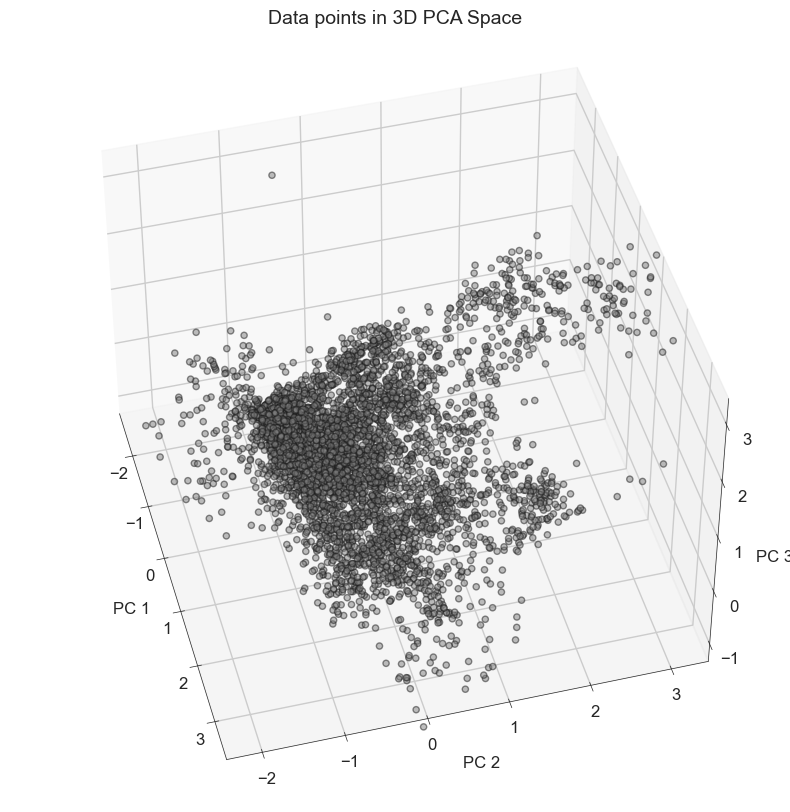

In [67]:
# 3D Visualization with Ellipsoidal Boundaries

X_pca_transformed_select_pcs = X_pca_transformed[:, :num_pc_subset]
if num_pc_subset >= 3:  # Ensure we have at least 3 PCs for 3D visualization
    
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Scatter plot for individual points (with consistent colors)
    ax.scatter(
        X_pca_transformed_select_pcs[:, 0], 
        X_pca_transformed_select_pcs[:, 1], 
        X_pca_transformed_select_pcs[:, 2], 
        color='Gray', alpha=0.5, edgecolor='k'
    )

    # Dynamically set axis limits for better visibility
    margin = -.5
    x_min, x_max = X_pca_transformed_select_pcs[:, 0].min(), X_pca_transformed_select_pcs[:, 0].max()
    y_min, y_max = X_pca_transformed_select_pcs[:, 1].min(), X_pca_transformed_select_pcs[:, 1].max()
    z_min, z_max = X_pca_transformed_select_pcs[:, 2].min(), X_pca_transformed_select_pcs[:, 2].max()

    ax.set_xlim(x_min - margin, x_max + margin)
    ax.set_ylim(y_min - margin, y_max + margin)
    ax.set_zlim(z_min - margin, z_max + margin)

    # Labels and formatting
    ax.set_xlabel("PC 1", fontsize=12)
    ax.set_ylabel("PC 2", fontsize=12)
    ax.set_zlabel("PC 3", fontsize=12)
    ax.set_title(f"Data points in 3D PCA Space", fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=12)

    # Legend for clusters
    ax.legend(fontsize=12, markerscale=2.5, loc='upper right')
    # ax.view_init(elev=45, azim=60)
    ax.view_init(elev=45, azim=-15)

    # plt.show()

# ax.view_init(elev=45, azim=135)
plt.show(block=True)

## K-means clustering 

#### Calculate the optinal number of clusters

In [68]:
from scipy.spatial.distance import pdist

# Function to compute within-cluster distances

# Step 2: Define the function to calculate within-cluster distances
def within_cluster_distance(X, labels, metric='correlation'):
    unique_clusters = np.unique(labels)
    cluster_distances = []
    
    for cluster in unique_clusters:
        cluster_points = X[labels == cluster]
        if len(cluster_points) > 1:
            # Compute pairwise distances for the given cluster
            distances = pdist(cluster_points, metric=metric)  # 'correlation' or 'cosine'
            avg_distance = np.mean(distances)  # Average distance within the cluster
        else:
            avg_distance = np.nan  # Skip if only one point in the cluster
            
        cluster_distances.append(avg_distance)
    
    return np.nanmean(cluster_distances)

# Function to compute group-specific centroids
def compute_group_centroids(X, labels, group_mask, n_clusters):
    centroids = {}
    for i in range(n_clusters):
        cluster_points = X[(labels == i) & group_mask]
        if cluster_points.size == 0:
            centroids[f'cluster_{i}'] = None
        else:
            centroids[f'cluster_{i}'] = np.mean(cluster_points, axis=0)
    return centroids

# Step 1: Ensure X is already PCA-transformed
X_pca_transformed_select_pcs = X_pca_transformed[:, :num_pc_subset]  # Select first 'num_pc_subset' PCs

# Store cluster labels for each group (for consistency evaluation)
cluster_labels_group_A = []
cluster_labels_group_B = []

# Mapping group labels to each data point included in the clustering
group_labels_expanded = np.repeat(df_patient_data['group_name'].values, [num_valid_windows for num_valid_windows in df_patient_data['num_valid_windows']])
group_A_indices = (group_labels_expanded == 'Group A')
group_B_indices = (group_labels_expanded == 'Group B')

# Step 2: Determine the optimal number of clusters using Elbow method
inertia_values = []
silhouette_scores = []
davies_bouldin_scores = []
calinski_harabasz_scores = []
pearson_distances = []
cosine_distances = []
centroid_distances = []

K_range = range(2, 20)  # Test from 2 to 19 clusters

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=100)
    
    if USE_IPW: 
        cluster_labels = kmeans.fit_predict(
            X_pca_transformed_select_pcs, 
            sample_weight=ipw_per_timepoint
        )
    else:
        cluster_labels = kmeans.fit_predict(
            X_pca_transformed_select_pcs
        )
    
    # Compute evaluation metrics
    inertia_values.append(kmeans.inertia_)
    silhouette_scores.append(
        silhouette_score(
            X_pca_transformed_select_pcs, 
            cluster_labels
        )
    )
    davies_bouldin_scores.append(
        davies_bouldin_score(
            X_pca_transformed_select_pcs, 
            cluster_labels
        )
    )
    calinski_harabasz_scores.append(
        calinski_harabasz_score(
            X_pca_transformed_select_pcs, 
            cluster_labels
        )
    )
    pearson_distances.append(
        within_cluster_distance(
            X_pca_transformed_select_pcs, 
            cluster_labels, 
            metric='correlation'
        )
    )
    cosine_distances.append(
        within_cluster_distance(
            X_pca_transformed_select_pcs, 
            cluster_labels, 
            metric='cosine'
        )
    )

    # calculate the consistency of clustering solution between the two patient groups 
    group_A_centroids = compute_group_centroids(
        X_pca_transformed_select_pcs, 
        cluster_labels, 
        group_A_indices, 
        n_clusters=k
    )
    group_B_centroids = compute_group_centroids(
        X_pca_transformed_select_pcs, 
        cluster_labels, 
        group_B_indices, 
        n_clusters=k
    )

    centroid_distance = []
    for i in range(k):
        g_a_centroid = group_A_centroids[f'cluster_{i}']
        g_b_centroid = group_B_centroids[f'cluster_{i}']

        if g_a_centroid is not None and g_b_centroid is not None:
            centroid_distance.append(
                np.linalg.norm(
                    g_a_centroid - g_b_centroid
                )
            )
    centroid_distances.append(
        np.mean(centroid_distance)
    )

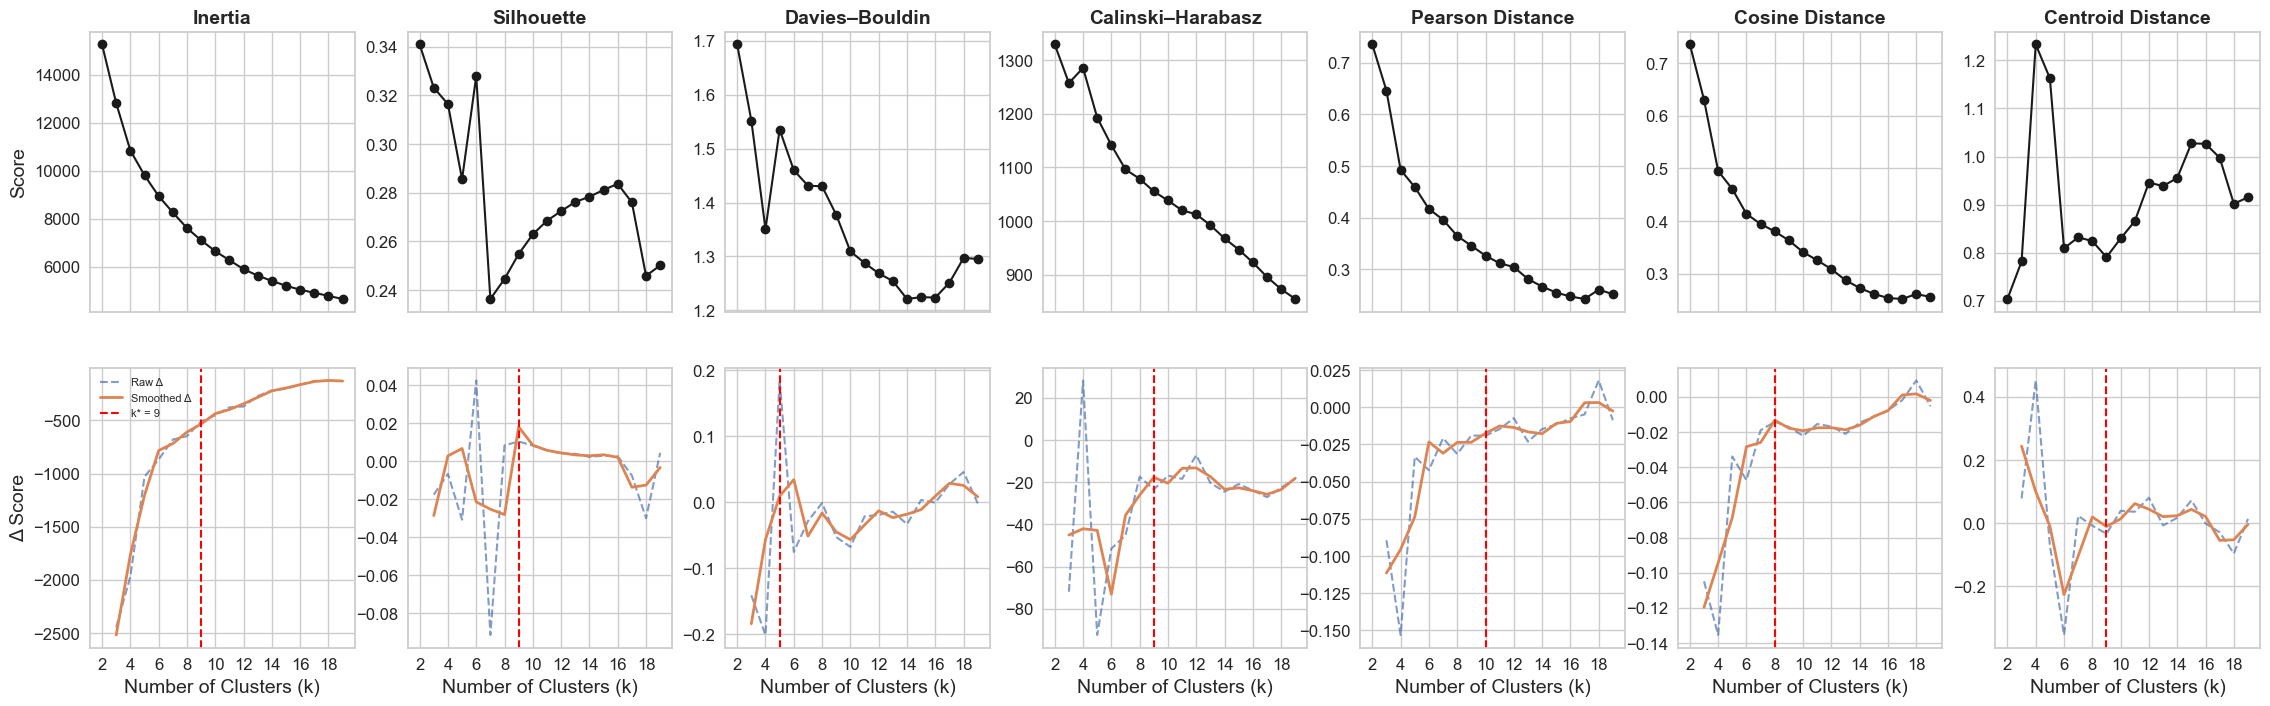

Optimal k per criterion:
  Inertia              → k = 9
  Silhouette           → k = 9
  Davies–Bouldin       → k = 5
  Calinski–Harabasz    → k = 9
  Pearson Distance     → k = 10
  Cosine Distance      → k = 8
  Centroid Distance    → k = 9


In [69]:
from scipy.signal import savgol_filter

# 1) Bundle your metrics
criteria_scores = {
    'Inertia':              inertia_values,
    'Silhouette':           silhouette_scores,
    'Davies–Bouldin':       davies_bouldin_scores,
    'Calinski–Harabasz':    calinski_harabasz_scores,
    'Pearson Distance':     pearson_distances,
    'Cosine Distance':      cosine_distances,
    'Centroid Distance':    centroid_distances,
}
criteria_names = list(criteria_scores.keys())

# 2) Compute optimal k for each criterion with the 80%-threshold on smoothed diffs
optimal_ks = {}
for crit in criteria_names:
    if crit == 'Centroid Distance':
        # pick the k > 5 with minimal centroid distance
        arr = np.array(criteria_scores[crit])
        Ks  = np.array(K_range)
        mask = Ks > 5
        valid_K = Ks[mask]
        valid_vals = arr[mask]
        optimal_ks[crit] = valid_K[np.nanargmin(valid_vals)]
    else:
        scores = np.array(criteria_scores[crit])
        diffs = np.diff(scores)
        diffs_smooth = savgol_filter(diffs, window_length=5, polyorder=2)
        thr = 0.80 * (diffs_smooth.max() - diffs_smooth.min()) + diffs_smooth.min()
        sat_idx = np.where(diffs_smooth > thr)[0][0]
        optimal_ks[crit] = K_range[sat_idx + 1]  # +1 to correct index shift


# 3) Plot metrics (row 1) and their raw & smoothed diffs + optimal‐k (row 2)
n = len(criteria_names)
sns.set_theme(style="whitegrid")
fig, axes = plt.subplots(2, n, figsize=(4*n, 8), 
                         sharex='col', 
                        #  constrained_layout=True
                        )

for col, crit in enumerate(criteria_names):
    # Row 1: the metric curve
    ax = axes[0, col]
    ax.plot(K_range, criteria_scores[crit], marker='o', linestyle='-', color='k')
    ax.set_title(crit, fontsize=14, fontweight='bold')
    if col == 0:
        ax.set_ylabel("Score", fontsize=14)
    # ax.set_xlabel("k", fontsize=10)
    ax.tick_params(labelsize=12)
    
    # Row 2: raw diffs, smoothed diffs, and optimal‐k line
    ax2 = axes[1, col]
    scores       = np.array(criteria_scores[crit])
    diffs        = np.diff(scores)
    diffs_smooth = savgol_filter(diffs, window_length=5, polyorder=2)
    
    ax2.plot(K_range[1:], diffs,        linestyle='--', label='Raw Δ',    alpha=0.7)
    ax2.plot(K_range[1:], diffs_smooth, linestyle='-',  label='Smoothed Δ', linewidth=2)
    
    opt_k = optimal_ks[crit]
    ax2.axvline(opt_k, color='red', linestyle='--', label=f"k* = {opt_k}")
    
    if col == 0:
        ax2.set_ylabel("Δ Score", fontsize=14)
        ax2.legend(frameon=False, fontsize=8)
    ax2.set_xticks(np.arange(2, 20, 2))
    ax2.set_xlabel("Number of Clusters (k)", fontsize=14)
    ax2.tick_params(labelsize=12)
    
plt.show()

# Optionally, print the optimal ks:
print("Optimal k per criterion:")
for crit, k in optimal_ks.items():
    print(f"  {crit:20s} → k = {k}")

### Perform K-Means with the optimal number of clusters

In [70]:
optimal_k = 9  # Or np.argmax(silhouette_scores) + 2  
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=100)

if USE_IPW: 
    cluster_labels = kmeans.fit_predict(
        X_pca_transformed_select_pcs, 
        sample_weight=ipw_per_timepoint
    )
else:
    cluster_labels = kmeans.fit_predict(
        X_pca_transformed_select_pcs, 
    )

# Compute cluster-specific radii along each PCA axis
centroids = kmeans.cluster_centers_
radii_pc = np.zeros((optimal_k, num_pc_subset))  # Store separate radii for PC1, PC2, and PC3

uniq_cluster_labels = np.unique(cluster_labels)
num_clusters = len(uniq_cluster_labels)

for i, cl in enumerate(uniq_cluster_labels):
    cluster_points = X_pca_transformed_select_pcs[cluster_labels == cl]  # Get points in the cluster
    radii_pc[i, :] = np.percentile(np.abs(cluster_points-centroids[i]), 95, axis=0) #np.std(cluster_points, axis=0)*2  # Compute standard deviation for each PC

Text(70.72222222222221, 0.5, 'Cluster')

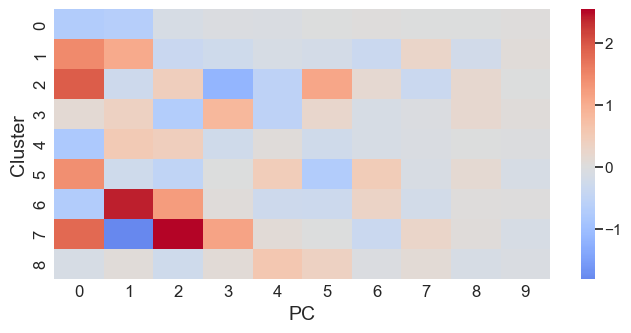

In [71]:
plt.figure(figsize=(8,3.5))
sns.heatmap(centroids, cmap='coolwarm', center=0)
plt.tick_params(labelsize=12, length=3)
plt.xlabel('PC', fontsize=14)
plt.ylabel('Cluster', fontsize=14)

### Alternatively use Gaussian Mixture Models 

#### Akaike Information Criterion (AIC)

The AIC is defined as:

$$
AIC = 2k - 2 \log(\hat{L})
$$

Where:  
- \( k \) = Number of parameters in the model  
- \( \hat{L} \) = Maximum likelihood of the model  

#### Bayesian Information Criterion (BIC)

The Bayesian Information Criterion (BIC) is given by:

$$
BIC = \log(n) \cdot k - 2 \cdot \log(\hat{L})
$$

Where:  
- \( n \) = Sample size  
- \( k \) = Number of parameters in the model  
- \( \hat{L} \) = Maximum likelihood of the model  


In [ ]:
# bic_scores = []
# aic_scores = []
# silhouette_scores = []

# n_components_range = range(2, 25)  # Try from 2 to 14 clusters

# for k in n_components_range:
#     gmm = GaussianMixture(n_components=k, random_state=42, n_init=10)
#     gmm.fit(X_pca_transformed_select_pcs)
#     aic_scores.append(gmm.aic(X_pca_transformed_select_pcs))
#     bic_scores.append(gmm.bic(X_pca_transformed_select_pcs))

#     cluster_labels = gmm.fit_predict(X_pca_transformed_select_pcs)
#     score = silhouette_score(X_pca_transformed_select_pcs, cluster_labels)
#     silhouette_scores.append(score)

In [ ]:
# sns.set(style="whitegrid")
# fig, axes = plt.subplots(1, 3, figsize=(10, 3.5))

# # Inertia plot
# axes[0].plot(n_components_range, aic_scores, marker='o', linestyle='-', color='k')
# axes[0].set_title("AIC")
# axes[0].set_xlabel("Number of Clusters (k)")
# axes[0].set_ylabel("score")

# # Silhouette Score plot
# axes[1].plot(n_components_range, bic_scores, marker='o', linestyle='-', color='k')
# axes[1].set_title("BIC")
# axes[1].set_xlabel("Number of Clusters (k)")
# axes[1].set_ylabel("Score")

# # Davies-Bouldin Score plot (lower is better)
# axes[2].plot(n_components_range, silhouette_scores, marker='o', linestyle='-', color='k')
# axes[2].set_title("Silhouette")
# axes[2].set_xlabel("Number of Clusters (k)")
# axes[2].set_ylabel("Score")

In [ ]:
# from scipy.signal import savgol_filter

# # Compute BIC differences
# bic_diffs = np.diff(bic_scores)

# # Smooth the curve using Savitzky-Golay filter
# bic_diffs_smooth = savgol_filter(bic_diffs, window_length=10, polyorder=2)

# # Find the first point where the difference falls below a small threshold
# # threshold = np.percentile(bic_diffs, 90)  # You may tweak this threshold
# saturation_idx = np.where(bic_diffs_smooth > (0.95 * (np.max(bic_diffs_smooth)-np.min(bic_diffs_smooth))+np.min(bic_diffs_smooth)))[0][0]

# # Get the optimal number of components
# optimal_k = n_components_range[saturation_idx + 1]  # +1 because bic_diffs is one step shorter

# # Plot the results
# plt.figure()
# plt.plot(n_components_range[1:], bic_diffs, label="Raw BIC Differences", linestyle="dashed", alpha=0.7)
# plt.plot(n_components_range[1:], bic_diffs_smooth, label="Smoothed Curve", linewidth=2)
# plt.axvline(optimal_k, color="red", linestyle="--", label=f"Optimal k = {optimal_k}")
# plt.xlabel("Number of Components (k)")
# plt.ylabel("BIC Difference")
# plt.legend()
# plt.show()

# # print(f"Saturation Threshold: {threshold}, Optimal k: {optimal_k}")

In [ ]:
# optimal_k = 12  # Previously determined optimal number of clusters

# # Fit Gaussian Mixture Model
# gmm = GaussianMixture(n_components=optimal_k, random_state=42, n_init=100)
# cluster_labels = gmm.fit_predict(X_pca_transformed_select_pcs)

# # Compute the probability of each cluster at each time point
# cluster_probabilities = gmm.predict_proba(X_pca_transformed_select_pcs)  # Shape: (num_samples, num_clusters)

# # Compute cluster-specific radii along each PCA axis
# centroids = gmm.means_  # Cluster centers in GMM
# num_pc_subset = X_pca_transformed_select_pcs.shape[1]  # Number of PCA components
# radii_pc = np.zeros((optimal_k, num_pc_subset))  # Store separate radii for each PC axis

# uniq_cluster_labels = np.unique(cluster_labels)
# num_clusters = len(uniq_cluster_labels)

# for i, cl in enumerate(uniq_cluster_labels):
#     cluster_points = X_pca_transformed_select_pcs[cluster_labels == cl]  # Get points in the cluster
#     radii_pc[i, :] = np.percentile(np.abs(cluster_points - centroids[i]), 95, axis=0)  # Compute 95th percentile spread

# # Print probabilities for the first few time points
# print("Cluster probabilities for the first few time points:")
# print(cluster_probabilities[:5])  # Show probabilities for the first 5 points

In [ ]:
# # Collect the max probability for each time point
# max_probabilities = np.max(cluster_probabilities, axis=1)  # Shape: (num_samples,)

# plt.figure()
# plt.hist(max_probabilities, bins=20)
# plt.tick_params(labelsize=12)
# print(np.percentile(max_probabilities, 15))

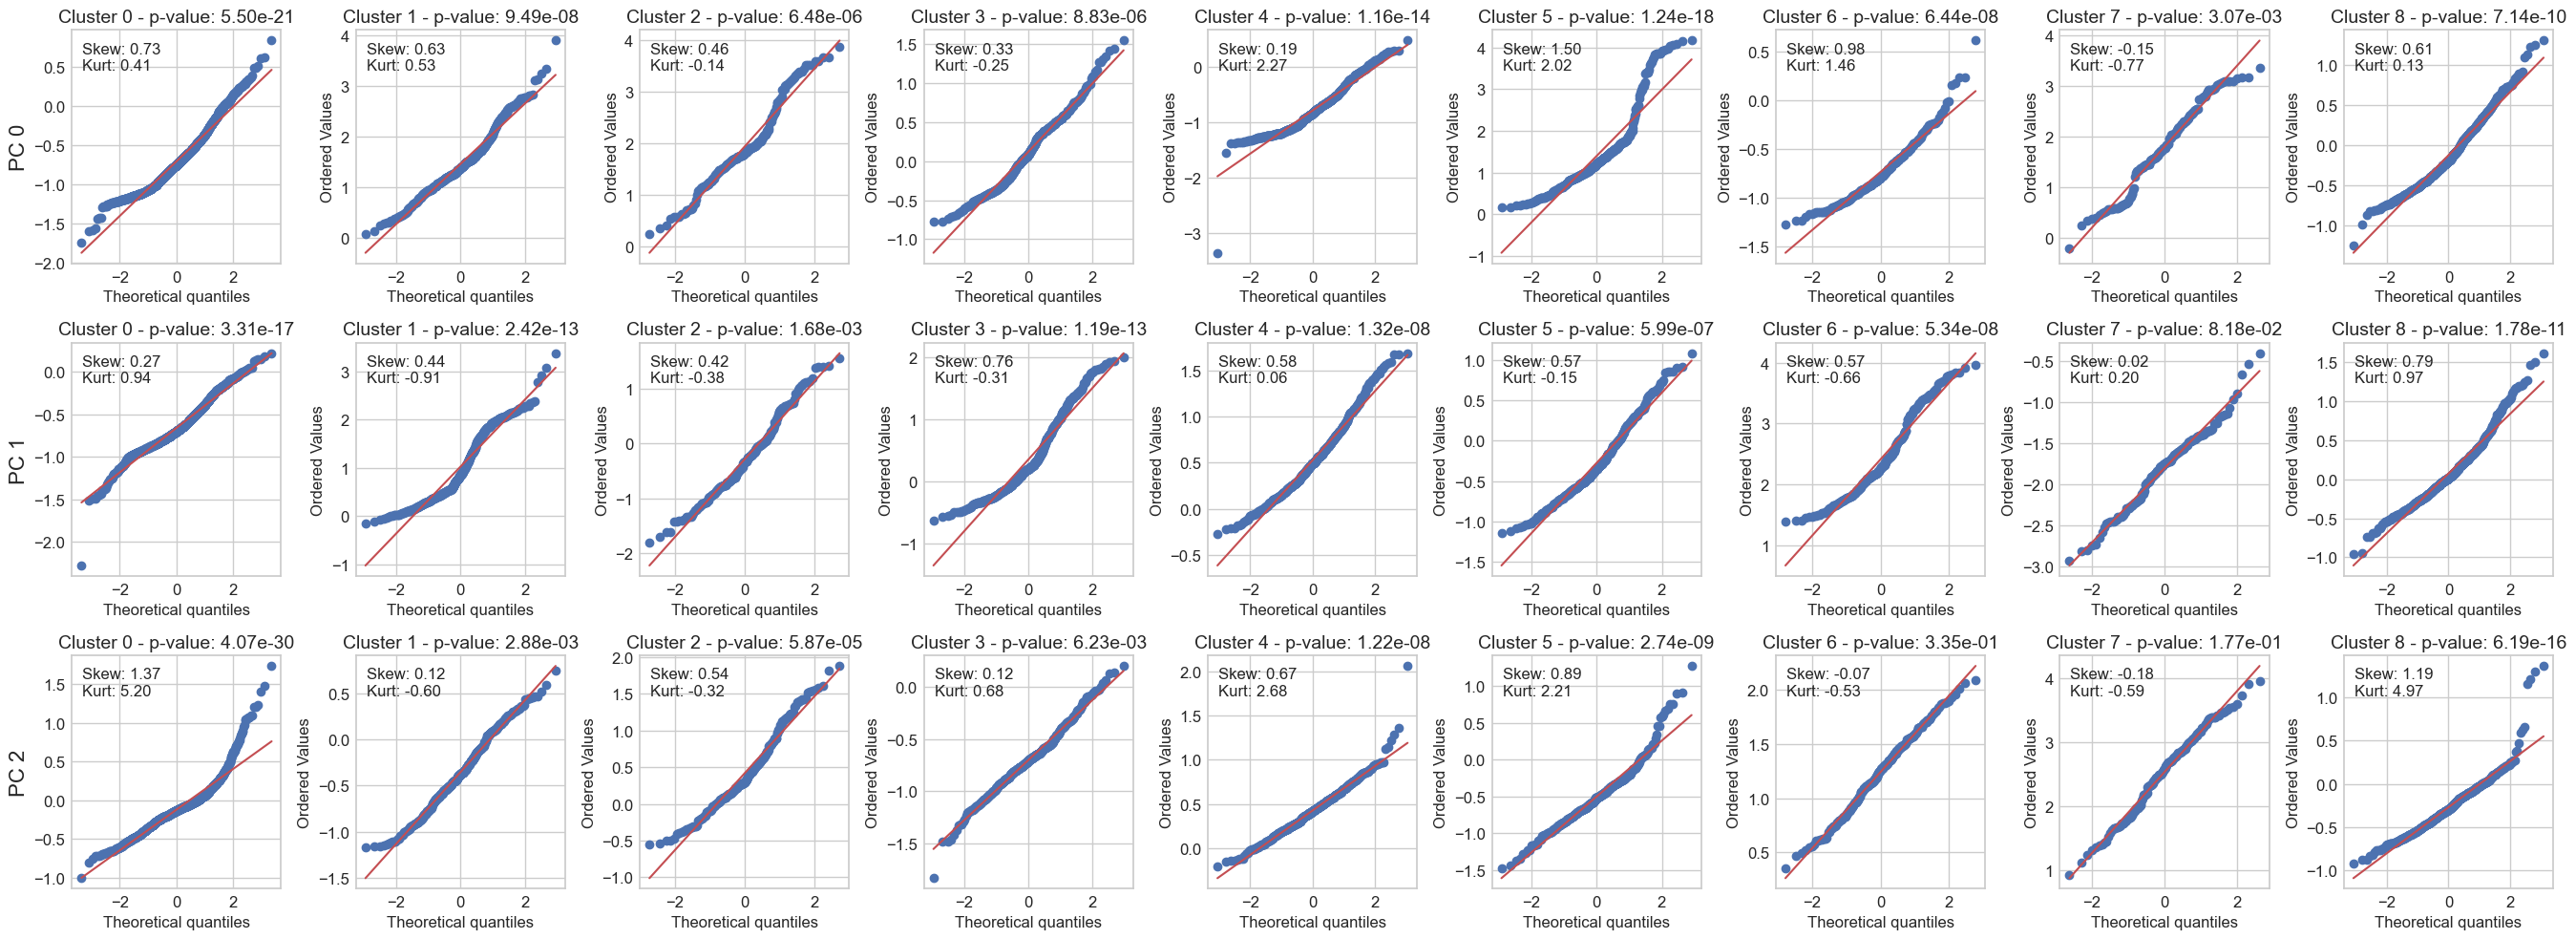

In [72]:
import scipy.stats as stats
from scipy.stats import skew, kurtosis

# Set the number of PCs to check (the first 3 PCs)
num_pcs_to_check = 3

# Create a figure with 3 rows (for the 3 PCs) and 'optimal_k' columns (for the clusters)
plt.figure(figsize=(optimal_k * 3, 10))  # Adjust figure size as needed

for j in range(num_pcs_to_check):  # Loop through the first 3 PCs (rows)
    for i in range(optimal_k):  # Loop through clusters (columns)
        plt.subplot(num_pcs_to_check, optimal_k, j * optimal_k + i + 1)  # Position in grid
        
        # Extract the points for the i-th cluster
        cluster_points = X_pca_transformed_select_pcs[cluster_labels == i]

        # Q-Q plot for the j-th PC of the i-th cluster
        stats.probplot(cluster_points[:, j], dist="norm", plot=plt)

        # Get current axis
        ax = plt.gca()

        # Calculate skewness and kurtosis
        sk = skew(cluster_points[:, j]) # How symmetric the distribution is (sk=0, symmetric)
        ku = kurtosis(cluster_points[:, j]) # How light tailed (ku < 0) or heavy-tailed (ku > 0) the distribution is

        # Add text with skewness and kurtosis
        ax.text(0.05, 0.95, f"Skew: {sk:.2f}\nKurt: {ku:.2f}",
                transform=ax.transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left', 
                bbox=dict(facecolor='none', alpha=0.8, edgecolor='none', boxstyle='round,pad=0.5'))

        # Perform the Shapiro-Wilk test for normality
        _, p_value = stats.shapiro(cluster_points[:, j])  # Shapiro-Wilk test
        #P_value < 0.05 means that we can reject the numl hypothesis that the data come from a normal distribution. P>0.05 means that the data likely follow a normal distribution.
        # >>NOTE: the p_value depends on the sample sizes, so don't use it for comparisons between the clusters. Use subsampling or permuations. 

        # Add the p-value to the plot
        ax.set_title(f"Cluster {i} - p-value: {p_value:.2e}", fontsize=14)
        

        if i == 0:  # Only add PC title on the first column
            ax.set_ylabel(f"PC {j}", fontsize=16)

        ax.tick_params(labelsize=12, length=4)

plt.tight_layout()
plt.show()


# ### Only for Gaussian Mixture
# from sklearn.mixture import GaussianMixture
# gmm = GaussianMixture(n_components=optimal_k, random_state=42)

# for cl in uniq_cluster_labels:
#     cluster_points = X_pca_transformed_select_pcs[cluster_labels == cl]
#     gmm.fit(cluster_points)
#     print(f"Cluster {cl}: Log-likelihood = {gmm.score(cluster_points)}")
#     print(f"Cluster {cl}: AIC = {gmm.aic(cluster_points)}, BIC = {gmm.bic(cluster_points)}")
#     # >>NOTE: BIC depends on the sample size, don't use it for between cluster comparisons. 


#### Merging Clusters

In [73]:
MERGE_CLUSTERS = False

merge_map = {
    0: 'M1',  7: 'M1',  # Merge clusters 0 and 7 into a new cluster 0
    6: 'M2',  8: 'M2',  9: 'M2',  # Merge clusters 6, 8, 9 into a new cluster 1
    4: 'M3',  5: 'M3'  # Merge clusters 4 and 5 into a new cluster 2
}

if MERGE_CLUSTERS is True:
    # Assign new labels while keeping unmerged clusters the same
    new_cluster_labels = np.array([merge_map.get(label, label) for label in cluster_labels])
    uniq_cluster_labels = np.unique(new_cluster_labels)
    num_clusters = len(uniq_cluster_labels)

    # Recalculate the centroids
    new_centroids = np.zeros((num_clusters, num_pc_subset)) 
    new_radii_pc = np.zeros((num_clusters, num_pc_subset))

    for i, cl in enumerate(uniq_cluster_labels):
        # Get the points in the current merged cluster
        cluster_points = X_pca_transformed_select_pcs[new_cluster_labels == cl]
        
        # Calculate new centroid (mean of the points in the cluster)
        new_centroids[i, :] = np.nanmean(cluster_points, axis=0)

        new_radii_pc[i, :] = np.percentile(np.abs(cluster_points - new_centroids[i, :]), 95, axis=0)
        
        # # Calculate the radii (max distance from the centroid)
        # distances = np.linalg.norm(cluster_points - new_centroid, axis=1)
        # new_radii_pc.append(np.max(distances))

    cluster_labels = new_cluster_labels
    centroids = new_centroids
    radii_pc = new_radii_pc

# Print the new cluster labels
print("cluster labels:", uniq_cluster_labels)

cluster labels: [0 1 2 3 4 5 6 7 8]


#### Calculate the time series of cluster labels during post-drug infusion period for each patient

In [74]:
# Initialize an empty list to store the cluster labels for each patient
patient_labels = []

# Start from the first time point in the concatenated data
current_label_idx = 0

# Iterate through each patient's data in the DataFrame
for idx, row in df_patient_data.iterrows():
    # Get the number of time points for this patient
    num_time_points = row['data'].shape[-1]

    valid_window_idx = row['valid_window_idx']
    num_valid_windows = row['num_valid_windows']
    
    # Extract the cluster labels for this patient (slice the global cluster labels based on the number of time points)
    curr_labels = np.full((num_time_points,), -1)
    
    idx = np.where(valid_window_idx)[0]
    curr_labels[idx] = cluster_labels[current_label_idx:current_label_idx+num_valid_windows]
    
    # Append the cluster labels to the list
    patient_labels.append(curr_labels)
    
    # Update the index to point to the next patient
    current_label_idx += num_valid_windows

# Now, add the cluster labels as a new column in the original DataFrame
df_patient_data['cluster_labels'] = [labels for labels in patient_labels]

#### Plot the clusters within the state space comprised of the first 3 PCs

C:\Users\Kourosh\AppData\Local\Temp\ipykernel_14048\220224518.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab10', num_clusters)  # Extract fixed colors


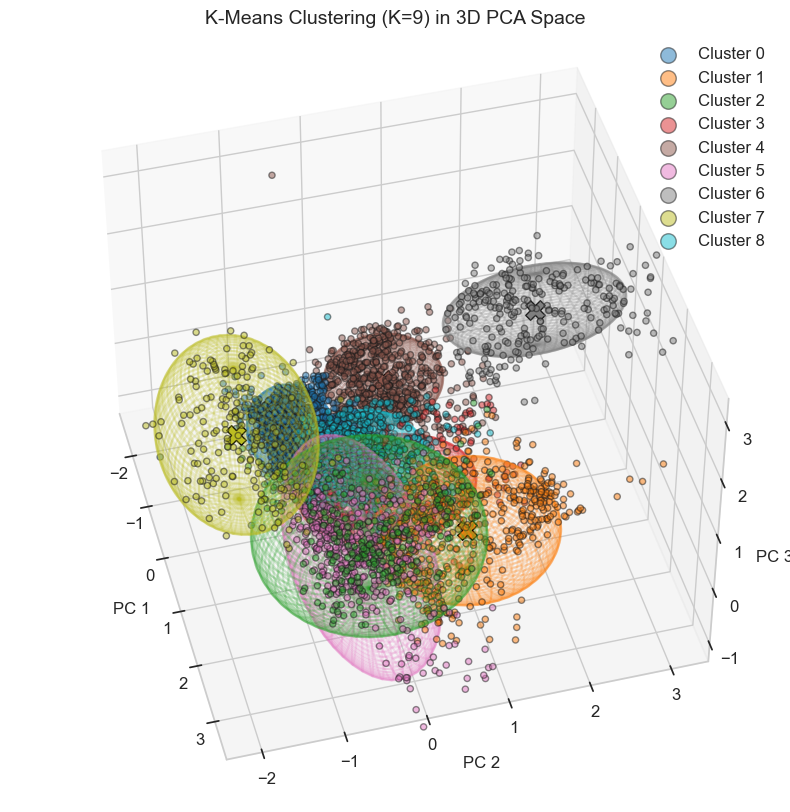

In [75]:
# Get consistent colors for clusters
cmap = cm.get_cmap('tab10', num_clusters)  # Extract fixed colors
cluster_colors = [cmap(i) for i in range(num_clusters)]  # Get consistent colors for each cluster

# 3D Visualization with Ellipsoidal Boundaries
if num_pc_subset >= 3:  # Ensure we have at least 3 PCs for 3D visualization
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Scatter plot for individual points (with consistent colors)
    for i, cl in enumerate(uniq_cluster_labels):
        ax.scatter(
            X_pca_transformed_select_pcs[cluster_labels == cl, 0], 
            X_pca_transformed_select_pcs[cluster_labels == cl, 1], 
            X_pca_transformed_select_pcs[cluster_labels == cl, 2], 
            color=cluster_colors[i], label=f"Cluster {cl}", alpha=0.5, edgecolor='k'
        )

    # Scatter plot for centroids (same color as cluster points)
    for i in range(num_clusters):
        ax.scatter(
            centroids[i, 0], centroids[i, 1], centroids[i, 2], 
            color=cluster_colors[i], marker='X', s=200, edgecolor='black'
        )
        # ax.text(centroids[i, 0], centroids[i, 1], centroids[i, 2], f'Cluster {i}', fontsize=12, color='black')

    # Draw ellipsoids around clusters (same color as cluster points)
    u = np.linspace(0, 2 * np.pi, 50)  # Angular grid for sphere
    v = np.linspace(0, np.pi, 50)  # Elevation grid for sphere

    for i in range(num_clusters):
        # Create a unit sphere
        x_sphere = np.outer(np.cos(u), np.sin(v))
        y_sphere = np.outer(np.sin(u), np.sin(v))
        z_sphere = np.outer(np.ones(np.size(u)), np.cos(v))

        # Scale the sphere into an ellipsoid using cluster-specific standard deviations
        x_ellipsoid = radii_pc[i, 0] * x_sphere + centroids[i, 0]
        y_ellipsoid = radii_pc[i, 1] * y_sphere + centroids[i, 1]
        z_ellipsoid = radii_pc[i, 2] * z_sphere + centroids[i, 2]

        ax.plot_wireframe(x_ellipsoid, y_ellipsoid, z_ellipsoid, color=cluster_colors[i], alpha=0.2)

    # Dynamically set axis limits for better visibility
    margin = -.5
    x_min, x_max = X_pca_transformed_select_pcs[:, 0].min(), X_pca_transformed_select_pcs[:, 0].max()
    y_min, y_max = X_pca_transformed_select_pcs[:, 1].min(), X_pca_transformed_select_pcs[:, 1].max()
    z_min, z_max = X_pca_transformed_select_pcs[:, 2].min(), X_pca_transformed_select_pcs[:, 2].max()

    ax.set_xlim(x_min - margin, x_max + margin)
    ax.set_ylim(y_min - margin, y_max + margin)
    ax.set_zlim(z_min - margin, z_max + margin)

    # Labels and formatting
    ax.set_xlabel("PC 1", fontsize=12)
    ax.set_ylabel("PC 2", fontsize=12)
    ax.set_zlabel("PC 3", fontsize=12)
    ax.set_title(f"K-Means Clustering (K={num_clusters}) in 3D PCA Space", fontsize=14)
    ax.tick_params(axis='both', which='major', labelsize=12)

    # Legend for clusters
    ax.legend(fontsize=12, markerscale=2.5, loc='upper right')
    ax.view_init(elev=45, azim=-15)

    # plt.show()

# ax.view_init(elev=45, azim=135)
plt.show(block=True)

#### Investigate the separability of each cluster pair along the two principal components that maximize their separation

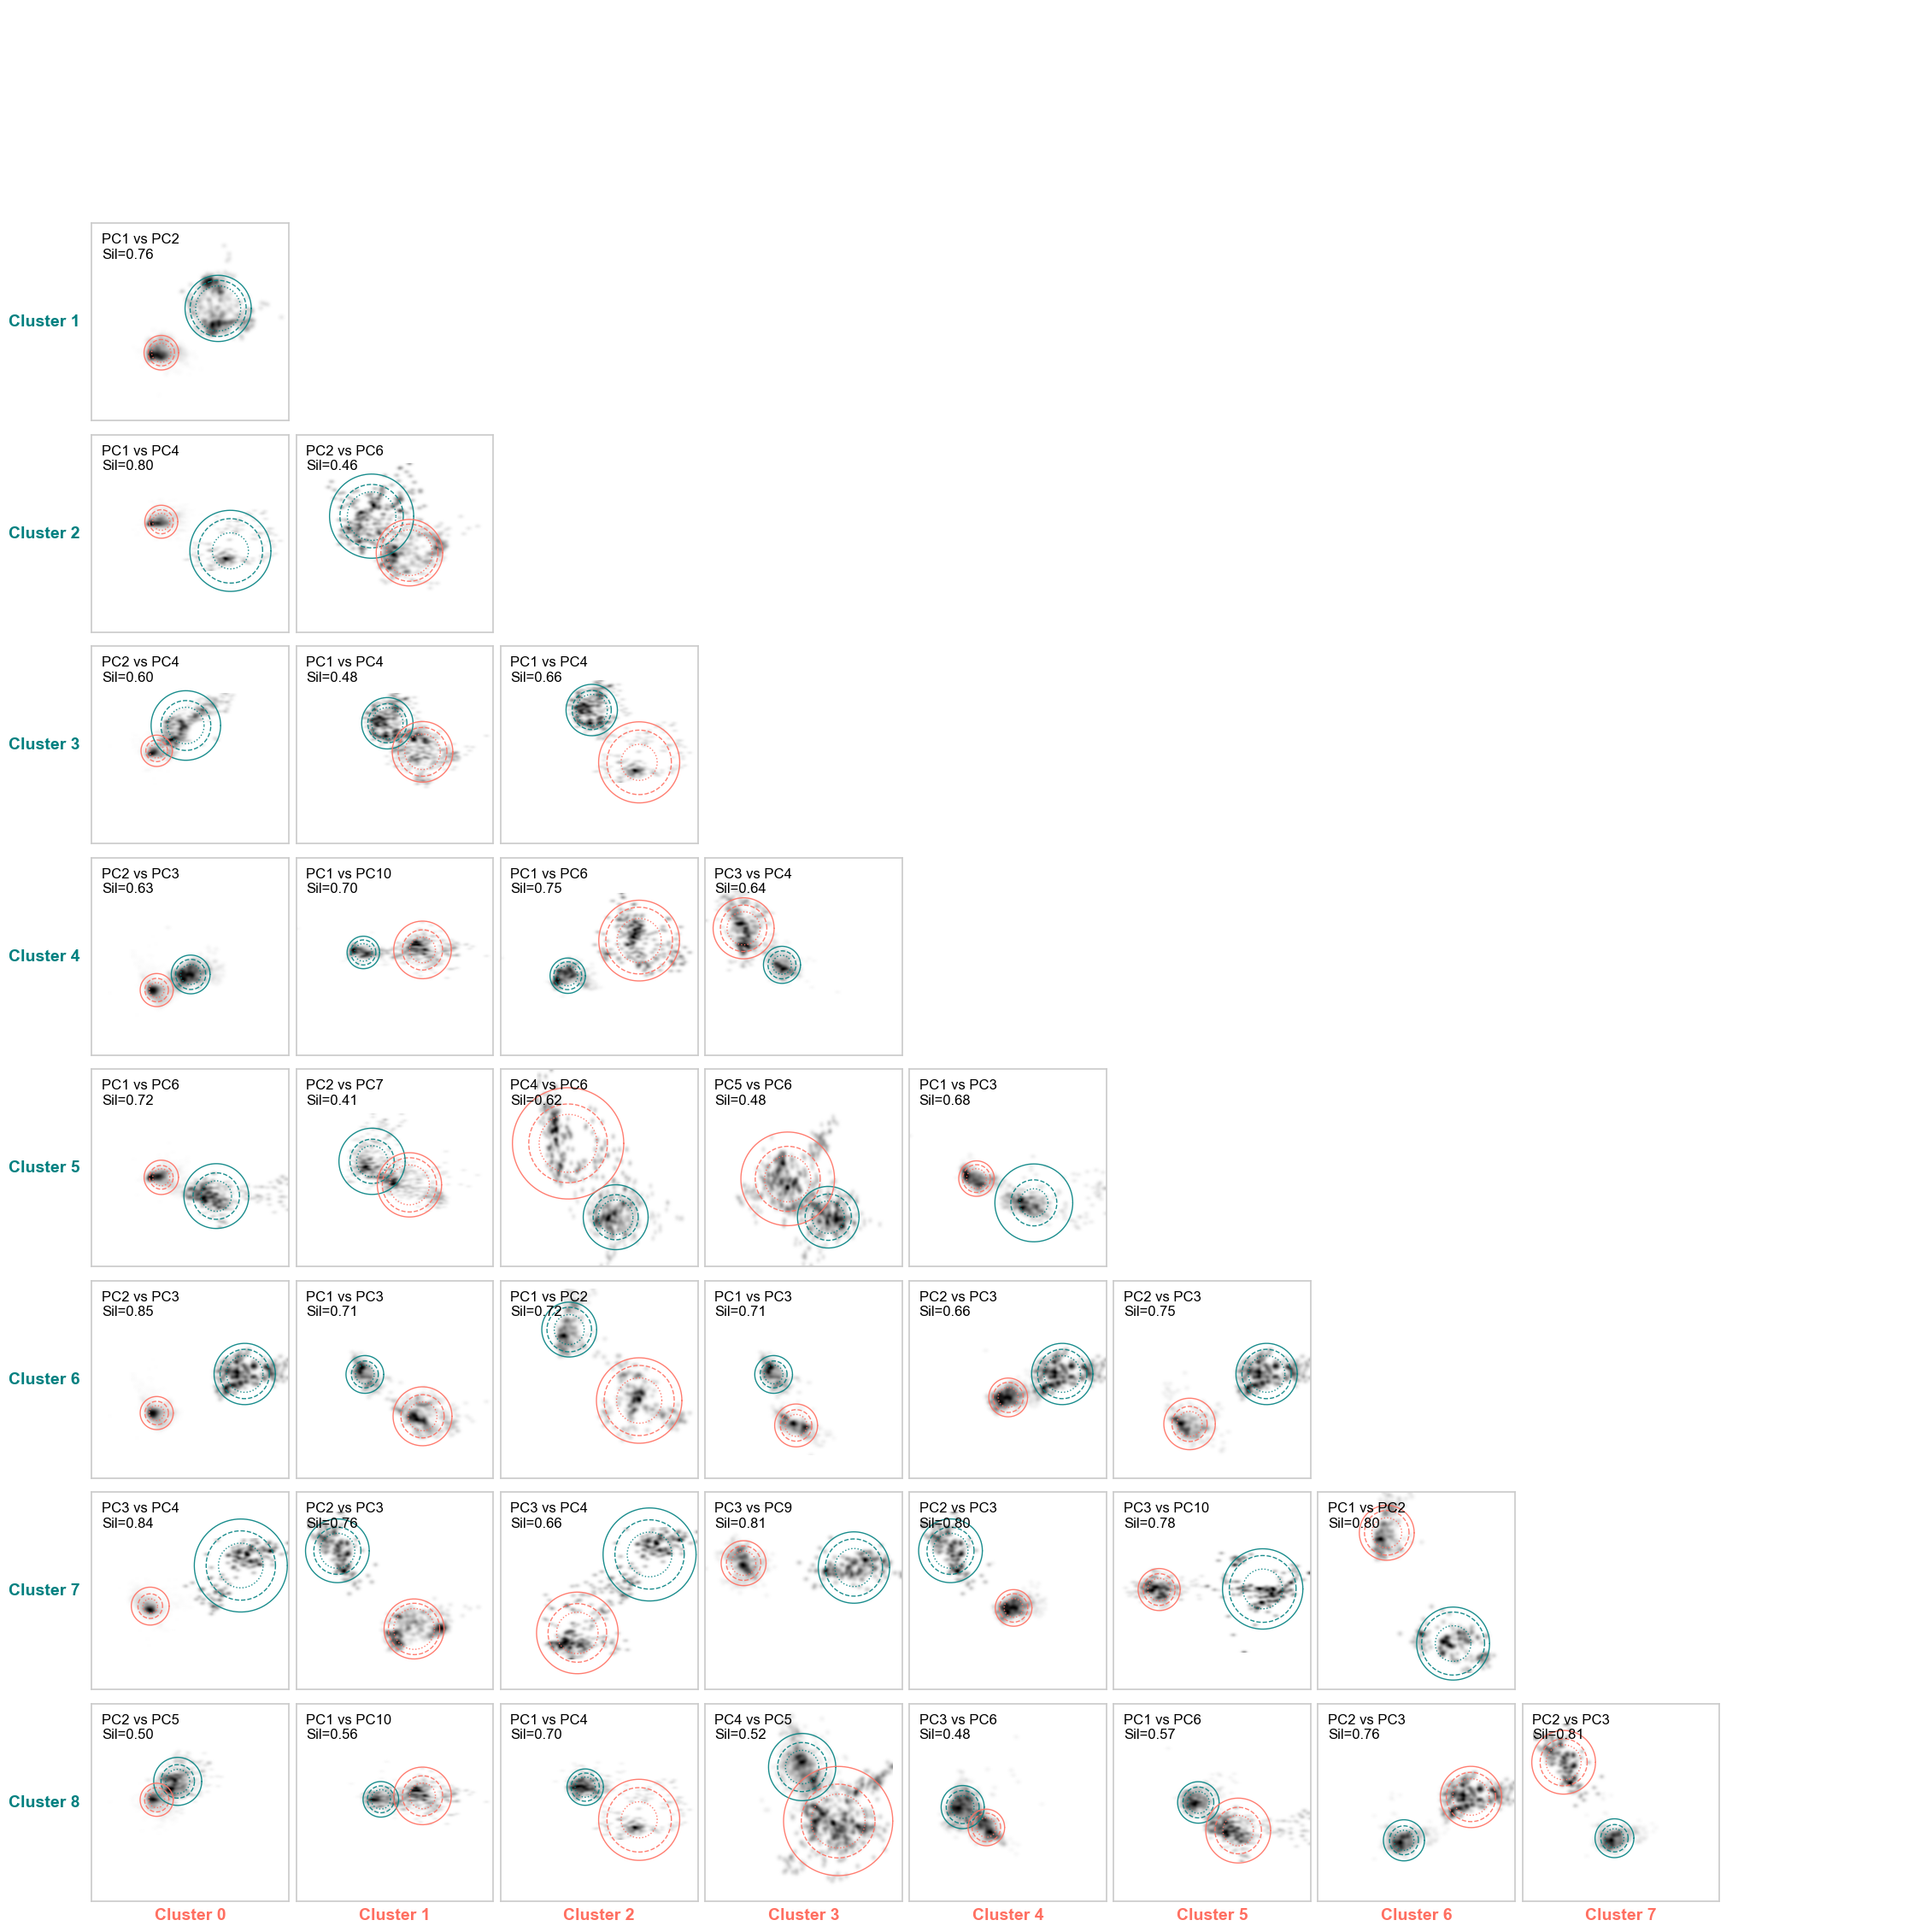

In [76]:
from scipy.ndimage import gaussian_filter
from sklearn.metrics import silhouette_score
import itertools

K = len(uniq_cluster_labels)

# params
nbins, sigma = 200, 2

percentiles = [50, 75, 90]
linestyles  = [':', '--', '-']
linewidths  = [1, 1, 1]

# 1) find best 2‐PC dims for each cluster‐pair
best_dims = {}
for a, b in itertools.combinations(uniq_cluster_labels, 2):
    idx = np.where((cluster_labels==a)|(cluster_labels==b))[0]
    X_ab, y_ab = X_pca_transformed_select_pcs[idx], cluster_labels[idx]
    best_score, best_pair = -1, None
    for i, j in itertools.combinations(range(X_pca_transformed_select_pcs.shape[1]), 2):
        sc = silhouette_score(X_ab[:, [i, j]], y_ab)
        if sc > best_score:
            best_score, best_pair = sc, (i, j)
    best_dims[(a, b)] = (*best_pair, best_score)

# 2) set up square grid
fig, axes = plt.subplots(K, K, figsize=(2.5*K, 2.5*K), constrained_layout=True)

# 3) fill only lower triangle (row > col)
for ra in range(K):
    for ca in range(ra):
        a = uniq_cluster_labels[ra]
        b = uniq_cluster_labels[ca]
        # look up best (i,j,score)
        i,j,score = best_dims[(min(a,b), max(a,b))]

        ax = axes[ra, ca]
        Xi, Yi = X_pca_transformed_select_pcs[:, i], X_pca_transformed_select_pcs[:, j]
        xa, ya = Xi[cluster_labels==a], Yi[cluster_labels==a]
        xb, yb = Xi[cluster_labels==b], Yi[cluster_labels==b]

        # common bins
        xedges = np.linspace(Xi.min(), Xi.max(), nbins+1)
        yedges = np.linspace(Yi.min(), Yi.max(), nbins+1)

        # build & smooth
        Ha, _, _ = np.histogram2d(xa, ya, bins=[xedges, yedges])
        Hb, _, _ = np.histogram2d(xb, yb, bins=[xedges, yedges])
        Ha = gaussian_filter(Ha, sigma)
        Hb = gaussian_filter(Hb, sigma)
        Ha /= Ha.max() or 1
        Hb /= Hb.max() or 1
        Hsum = Ha + Hb

        # draw merged heatmap
        ax.imshow(
            Hsum.T,
            origin='lower',
            extent=(xedges[0], xedges[-1], yedges[0], yedges[-1]),
            aspect='equal',
            cmap='gray_r'
        )

        # enforce the axes box to be square too:
        ax.set_aspect('equal')
        if hasattr(ax, 'set_box_aspect'):
            ax.set_box_aspect(1)

        # contour around each centroid
        ca_xy = centroids[ra, [i, j]]
        cb_xy = centroids[ca, [i, j]]
        da = np.linalg.norm(np.stack([xa, ya], axis=1) - ca_xy, axis=1)
        db = np.linalg.norm(np.stack([xb, yb], axis=1) - cb_xy, axis=1)

        theta = np.linspace(0, 2*np.pi, 200)
        for perc, ls, lw in zip(percentiles, linestyles, linewidths):
            rA = np.percentile(np.hypot(xa - ca_xy[0], ya - ca_xy[1]), perc)
            rB = np.percentile(np.hypot(xb - cb_xy[0], yb - cb_xy[1]), perc)

            # draw A’s ring
            ax.plot(ca_xy[0] + rA*np.cos(theta),
                    ca_xy[1] + rA*np.sin(theta),
                    linestyle=ls, linewidth=lw,
                    color='#008080', alpha=0.9)

            # draw B’s ring
            ax.plot(cb_xy[0] + rB*np.cos(theta),
                    cb_xy[1] + rB*np.sin(theta),
                    linestyle=ls, linewidth=lw,
                    color='#ff6f61', alpha=0.9)
        # r75a, r75b = percentile(da, 75), percentile(db, 75)
        # theta = np.linspace(0, 2*np.pi, 200)
        # ax.plot(ca_xy[0] + r75a*np.cos(theta),
        #         ca_xy[1] + r75a*np.sin(theta),
        #         '-', color='gray', linewidth=1)
        # ax.plot(cb_xy[0] + r75b*np.cos(theta),
        #         cb_xy[1] + r75b*np.sin(theta),
        #         '-', color='gray', linewidth=1)

        # annotate PCs & silhouette
        ax.text(0.05, 0.95,
                f"PC{i+1} vs PC{j+1}\nSil={score:.2f}",
                transform=ax.transAxes,
                va='top', ha='left',
                color='black', fontsize=12,
                # bbox=dict(facecolor='black', alpha=0.3, pad=2)
                )

        ax.set_xticks([]); ax.set_yticks([])

# 4) turn off diagonal & upper‐triangle
for r in range(K):
    for c in range(K):
        if r <= c:
            axes[r, c].axis('off')

# 5) label first row & first column
for idx, c in enumerate(uniq_cluster_labels):
    axes[idx, 0].set_ylabel(f"Cluster {c}",
                            rotation=0, labelpad=40,
                            va='center', fontsize=14, color='#008080', fontweight='bold')
    
for col, c in enumerate(uniq_cluster_labels):
    ax_bot = axes[K-1, col]
    ax_bot.set_xlabel(f"Cluster {c}", fontsize=14, labelpad=6, color='#ff6f61', fontweight='bold')

plt.show()

#### Spectral and spatial profile of each cluster

In [77]:
# Calculate the average wPLI matrices for each cluster label
# Concatenate the data for each group
def filter_valid_data(row):
    return np.array(row['data'])[..., row['valid_window_idx']]

group_a_data = (
    df_patient_data[df_patient_data['group_name'] == "Group A"]
    .apply(filter_valid_data, axis = 1)
    .to_numpy()
)
group_b_data = (
    df_patient_data[df_patient_data['group_name'] == "Group B"]
    .apply(filter_valid_data, axis = 1)
    .to_numpy()
)
group_a_data = np.concatenate(group_a_data, axis=3)
group_b_data = np.concatenate(group_b_data, axis=3)
wpli_concatenated_all = np.concatenate([group_a_data, group_b_data], axis=3)


# Concatenated cluster labels, including the missing time points
def filter_valid_data(row):
    return np.array(row['cluster_labels'])[row['valid_window_idx']]

group_a_cluster_labels = (
    df_patient_data[df_patient_data['group_name'] == "Group A"]
    .apply(filter_valid_data, axis = 1)
    .to_numpy()
)

group_b_cluster_labels = (
    df_patient_data[df_patient_data['group_name'] == "Group B"]
    .apply(filter_valid_data, axis = 1)
    .to_numpy()
)

group_a_cluster_labels = np.concatenate(group_a_cluster_labels, axis=0)
group_b_cluster_labels = np.concatenate(group_b_cluster_labels, axis=0)
cluster_labels_all = np.concatenate([group_a_cluster_labels, group_b_cluster_labels], axis=0)

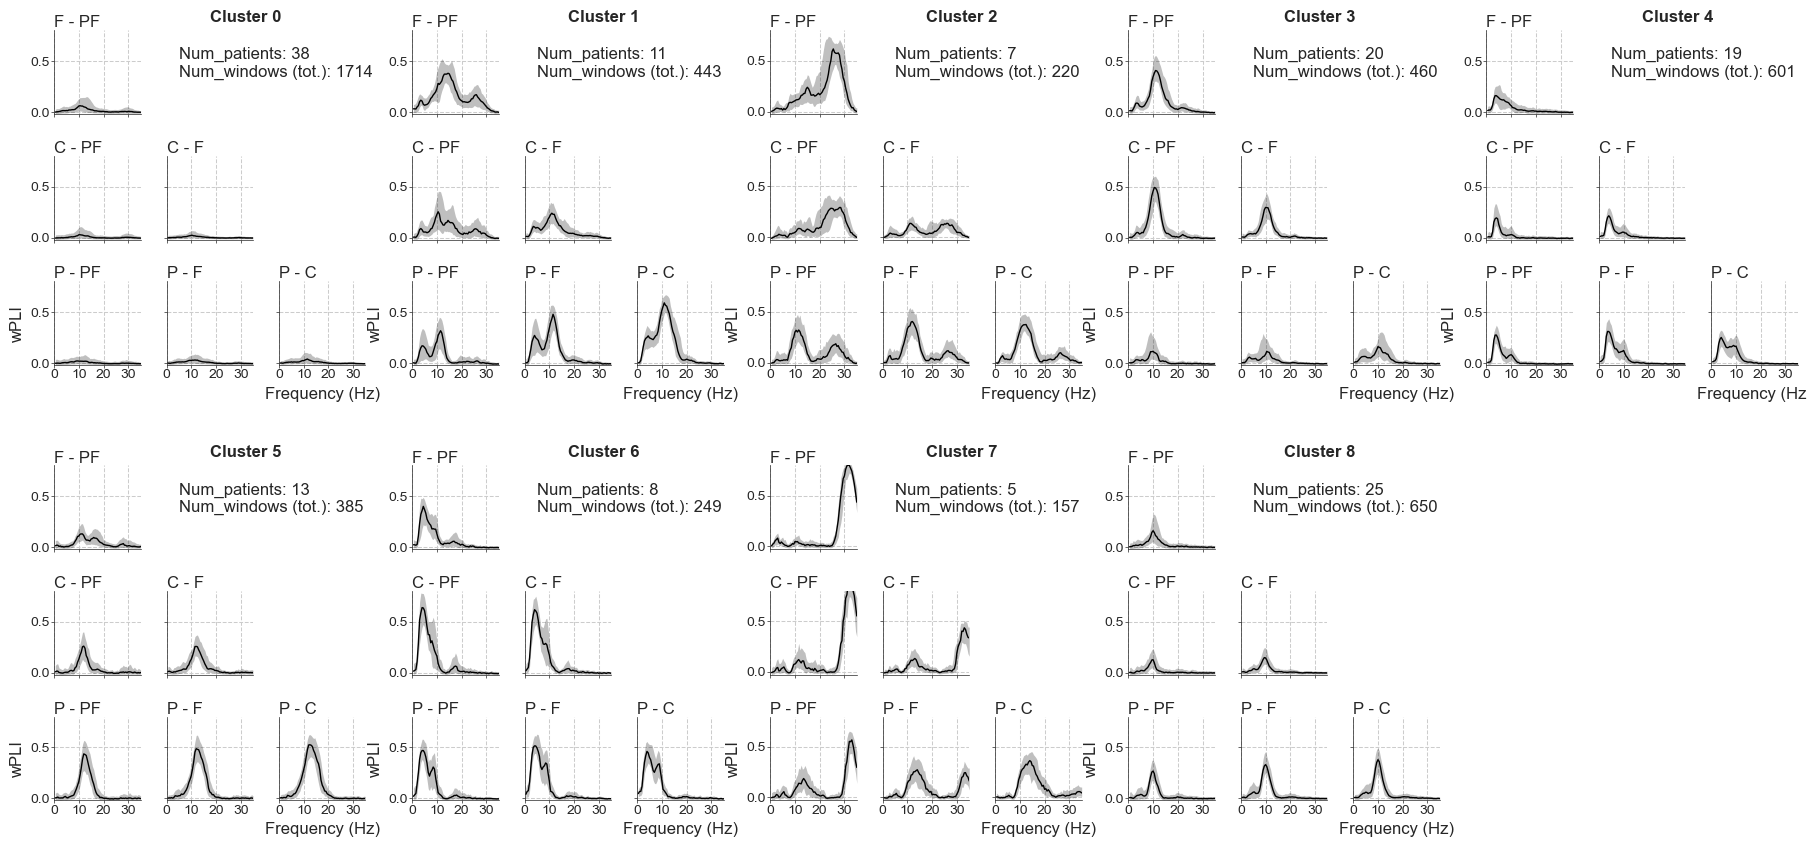

In [ ]:
rows = 2
cols = int(np.ceil(num_clusters/2))
fig = plt.figure(figsize=(cols*4.5, 10))
gs = GridSpec(rows, cols, figure=fig, hspace=0.3, wspace=0.15)
# USE_IPW = True
for idx, cl in enumerate(uniq_cluster_labels):
    row, col = divmod(idx, cols) # calculate the row and column index for the current cluster label

    # Get the corresponding grid axis
    ax = fig.add_subplot(gs[row, col])
    # remove the axis
    ax.axis('off')

    cluster_active_num_windows = 0
    cluster_active_patients = 0

    for idx, row in df_patient_data.iterrows():
        cluster_activation_idx = row['cluster_labels'] == cl
        num_cluster_activated_windows = len(np.where(cluster_activation_idx)[0])
        
        cluster_active_num_windows += num_cluster_activated_windows
        
        if num_cluster_activated_windows > 0:
            cluster_active_patients += 1

    # Extract the data for the current cluster
    cluster_activation_idx = cluster_labels_all == cl
    cluster_wpli_data = wpli_concatenated_all[:, :, :, cluster_activation_idx]
    cluster_ws = ipw_per_timepoint[cluster_activation_idx]

    if USE_IPW: # It doesn't make a big differnece here, feel free to use unweighted anyways
        P, _, F, _ = cluster_wpli_data.shape
        cluster_median = np.empty((P, P, F))
        lower_iqr      = np.empty((P, P, F))
        upper_iqr      = np.empty((P, P, F))

        for i, j, f in np.ndindex(P, P, F):
            vals = cluster_wpli_data[i, j, f, :]          # (n_win,) values across windows
            cluster_median[i, j, f] = wquantile(vals, cluster_ws, 0.50)
            lower_iqr[i, j, f]      = wquantile(vals, cluster_ws, 0.25)
            upper_iqr[i, j, f]      = wquantile(vals, cluster_ws, 0.75)
    else:
        cluster_median = np.median(cluster_wpli_data, axis=3)
        lower_iqr = np.percentile(cluster_wpli_data, 25, axis=3)
        upper_iqr = np.percentile(cluster_wpli_data, 75, axis=3)

    # Prepare the pli object
    dummy_pli = copy.deepcopy(pli)
    dummy_pli.freqs = freqs_low_res
    dummy_pli.region_names = region_names
    dummy_pli.conn_wpli_median = cluster_median
    dummy_pli.conn_wpli_iqr = (lower_iqr, upper_iqr)

    # Plot the wPLI frequency profile
    plot_wPLI_frequency_profile(
        dummy_pli, 
        vmax=0.8, 
        ax=ax, 
        suptitle=f'Cluster {cl}'
    )

     # Add the number of patients and time points as text in the panel
    ax.text(
        0.4, 0.95, 
        f'Num_patients: {cluster_active_patients}\n'
        f'Num_windows (tot.): {cluster_active_num_windows}', 
        transform=ax.transAxes, 
        ha='left', va='top', fontsize=12, 
        bbox=dict(facecolor='white', alpha=0.7)
    )

plt.show()

## Characterize Each State/Cluster

### Objective
Characterize each state/cluster in terms of spectral and spatial profiles. Identify which frequency bands and pairs of brain regions make each cluster different from others. 

C:\Users\Kourosh\AppData\Local\Temp\ipykernel_14048\3303229088.py:84: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('twilight')


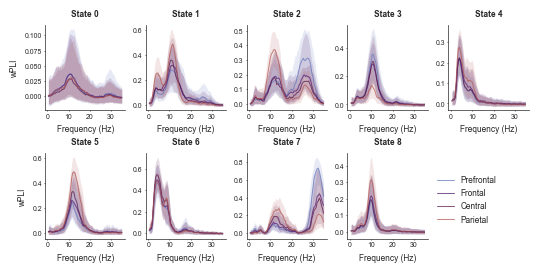

In [79]:
# 1. Compute Region-Wise Mean Connectivity with All Other Regions 
# 2. Compute Mean Connectivity Across All Region Pairs
# 3. Compute Connectivity Variability (Heterogeneity)

# Stats for each region's connectivity with other regions for each cluster
mean_connectivities = {}
iqr_connectivities = {}
connectivity_variabilities = {}

# Stats summarizing all inter-region connectivties, giving a sense of overall connectivtiy between the regions for each cluster
global_means = {}
global_iqrs = {}
global_CVs = {}

# Iterate over each cluster label
for cluster_label in uniq_cluster_labels:
    cluster_idx = cluster_labels_all == cluster_label
    cluster_wpli_data = wpli_concatenated_all[:, :, :, cluster_idx]
    
    mean_connectivities[cluster_label] = {}
    iqr_connectivities[cluster_label] = {}

    connectivity_variabilities[cluster_label] = {}

    list_of_global_plis = []
    list_of_global_mean_wplis = []
    
    # Iterate over each brain region
    for region_idx, region_name in enumerate(region_names):
        list_of_wplis_current_region = []
        list_of_mean_wplis_current_region = []
        
        # Compute connectivity with all other regions
        for alt_region_idx in range(num_regions):
            if alt_region_idx > region_idx:
                list_of_wplis_current_region.append(cluster_wpli_data[alt_region_idx, region_idx])
                list_of_mean_wplis_current_region.append(np.nanmedian(cluster_wpli_data[alt_region_idx, region_idx], axis=-1).reshape(-1,1))
            elif alt_region_idx < region_idx:
                list_of_wplis_current_region.append(cluster_wpli_data[region_idx, alt_region_idx])
                list_of_mean_wplis_current_region.append(np.nanmedian(cluster_wpli_data[region_idx, alt_region_idx], axis=-1).reshape(-1,1))
        
        # Concatenate connectivity values across all regions
        concatenated_wpli = np.concatenate(list_of_wplis_current_region, axis=1)
        concatenated_mean_wpli = np.concatenate(list_of_mean_wplis_current_region, axis=1)
        
        # Compute median and IQR connectivity for current region
        mean_connectivities[cluster_label][region_name] = np.nanmedian(concatenated_wpli, axis=-1)
        iqr_connectivities[cluster_label][region_name] = (np.nanpercentile(concatenated_wpli, 25, axis=-1), np.nanpercentile(concatenated_wpli, 75, axis=-1))

        # Calculate the Connectivity Variability (CV) for the current region
        means = np.nanmean(concatenated_mean_wpli, axis=1)
        CV = np.nanstd(concatenated_mean_wpli, axis=1) / means
        CV[means < 0.02] = np.nan
        connectivity_variabilities[cluster_label][region_name] = CV
        
        list_of_global_plis.append(concatenated_wpli)
        list_of_global_mean_wplis.append(concatenated_mean_wpli)
    
    # Compute global connectivity metrics
    global_wpli = np.concatenate(list_of_global_plis, axis=1)
    global_mean_wpli = np.concatenate(list_of_global_mean_wplis, axis=1)
    
    global_means[cluster_label] = np.nanmedian(global_wpli, axis=-1)
    global_iqrs[cluster_label] = np.nanpercentile(global_wpli, 25, axis=-1), np.nanpercentile(global_wpli, 75, axis=-1)
    
    # Calculate the global Connectivity Variability (CV)
    means = np.nanmean(global_mean_wpli, axis=1)
    CV = np.nanstd(global_mean_wpli, axis=1) / means
    CV[means < 0.01] = np.nan
    global_CVs[cluster_label] = CV

# Plot Mean Connectivity
rows = 2
cols = int(np.ceil(num_clusters / 2))

plot_width = 450
plot_height = 200

# fig1, axes1 = plt.subplots(rows, cols, figsize=(4*cols, 7.5))
fig1, axes1 = plt.subplots(rows, cols, figsize=(plot_width/72, plot_height/72))
axes1 = axes1.flatten()

# Generate colors for regions
cmap = cm.get_cmap('twilight')
region_colors = [cmap(i) for i in np.linspace(0.25, 0.75, num_regions)]

for idx, cluster_label in enumerate(uniq_cluster_labels):
    ax = axes1[idx]
    for region_idx, region_name in enumerate(region_names):
        ax.plot(freqs_low_res, mean_connectivities[cluster_label][region_name], color=region_colors[region_idx], label=region_name.capitalize(), linewidth=0.75, alpha=0.7)
        ax.fill_between(freqs_low_res, iqr_connectivities[cluster_label][region_name][0], iqr_connectivities[cluster_label][region_name][1], color=region_colors[region_idx], alpha=0.15, linewidth=0)

    # ax.plot(freqs_low_res, global_means[cluster_label], color='k', label='Global', alpha=0.7, linewidth=0.75)
    # ax.fill_between(freqs_low_res, global_iqrs[cluster_label][0], global_iqrs[cluster_label][1], color='k', alpha=0.15, linewidth=0)

    # if idx == 0:
    #     ax.legend(fontsize=12)
    # ax.set_ylim([0, 0.8])

    ax.set_xticks(np.arange(0, 35, 10))
    ax.set_xlabel('Frequency (Hz)', fontsize=6)
    if idx == 0 or idx == 5:
        ax.set_ylabel('wPLI', fontsize=6)

    ax.set_title(f'State {cluster_label}', fontsize=6, fontweight='bold')
    ax.tick_params(axis='both', which='major', labelsize=5)

for idx in range(num_clusters, len(axes1)):
    fig1.delaxes(axes1[idx])


# Add legend
ax_legend = fig1.add_subplot([0.75, 0.2, 0.1, 0.1])
legend_lines, legend_labels = ax.get_legend_handles_labels()
ax_legend.legend(legend_lines, legend_labels, loc='center', fontsize=6)
ax_legend.spines['bottom'].set_visible(False)
ax_legend.spines['left'].set_visible(False)
ax_legend.set_xticks([])
ax_legend.set_yticks([])
ax_legend.tick_params(bottom=False, left=False)


plt.subplots_adjust(hspace=0.5, wspace=0.25)

# Save the figure
main_dir = 'D:/Anesthesia_Research_Fellow/analysis_results'
filename = 'Connectivity_states_spatial_spectral_profiles_averages.pdf'
file_path = os.path.join(main_dir, filename)

plt.savefig(file_path, format='pdf', dpi=300)

plt.show()

# # Plot Connectivity Variability
# fig2, axes2 = plt.subplots(rows, cols, figsize=(4.5*cols, 7.5))
# axes2 = axes2.flatten()

# for idx, cluster_label in enumerate(uniq_cluster_labels):
#     ax = axes2[idx]
#     for region_idx, region_name in enumerate(region_names):
#         ax.plot(freqs_low_res, connectivity_variabilities[cluster_label][region_name], color=region_colors[region_idx], label=region_name.capitalize(), alpha=0.7)
#     ax.plot(freqs_low_res, global_CVs[cluster_label], color='k', label='Global CV', alpha=0.7, linewidth=2)
#     # ax.set_ylim([0, 2])
#     if idx == 0:
#         ax.legend(fontsize=12)
#     ax.set_xlim([freqs_low_res[0], freqs_low_res[-1]])
#     ax.set_xlabel('Frequency (Hz)', fontsize=12)
#     ax.set_ylabel('Connectivity Variability (CV)', fontsize=12)
#     ax.set_title(f'Cluster {cluster_label} - Connectivity Variability', fontsize=12, fontweight='bold')
#     ax.tick_params(axis='both', which='major', labelsize=12)

# for idx in range(num_clusters, len(axes2)):
#     fig2.delaxes(axes2[idx])

# plt.subplots_adjust(hspace=0.3, wspace=0.1)
# # plt.tight_layout()
# plt.show()

C:\Users\Kourosh\AppData\Local\Temp\ipykernel_14048\1265100424.py:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


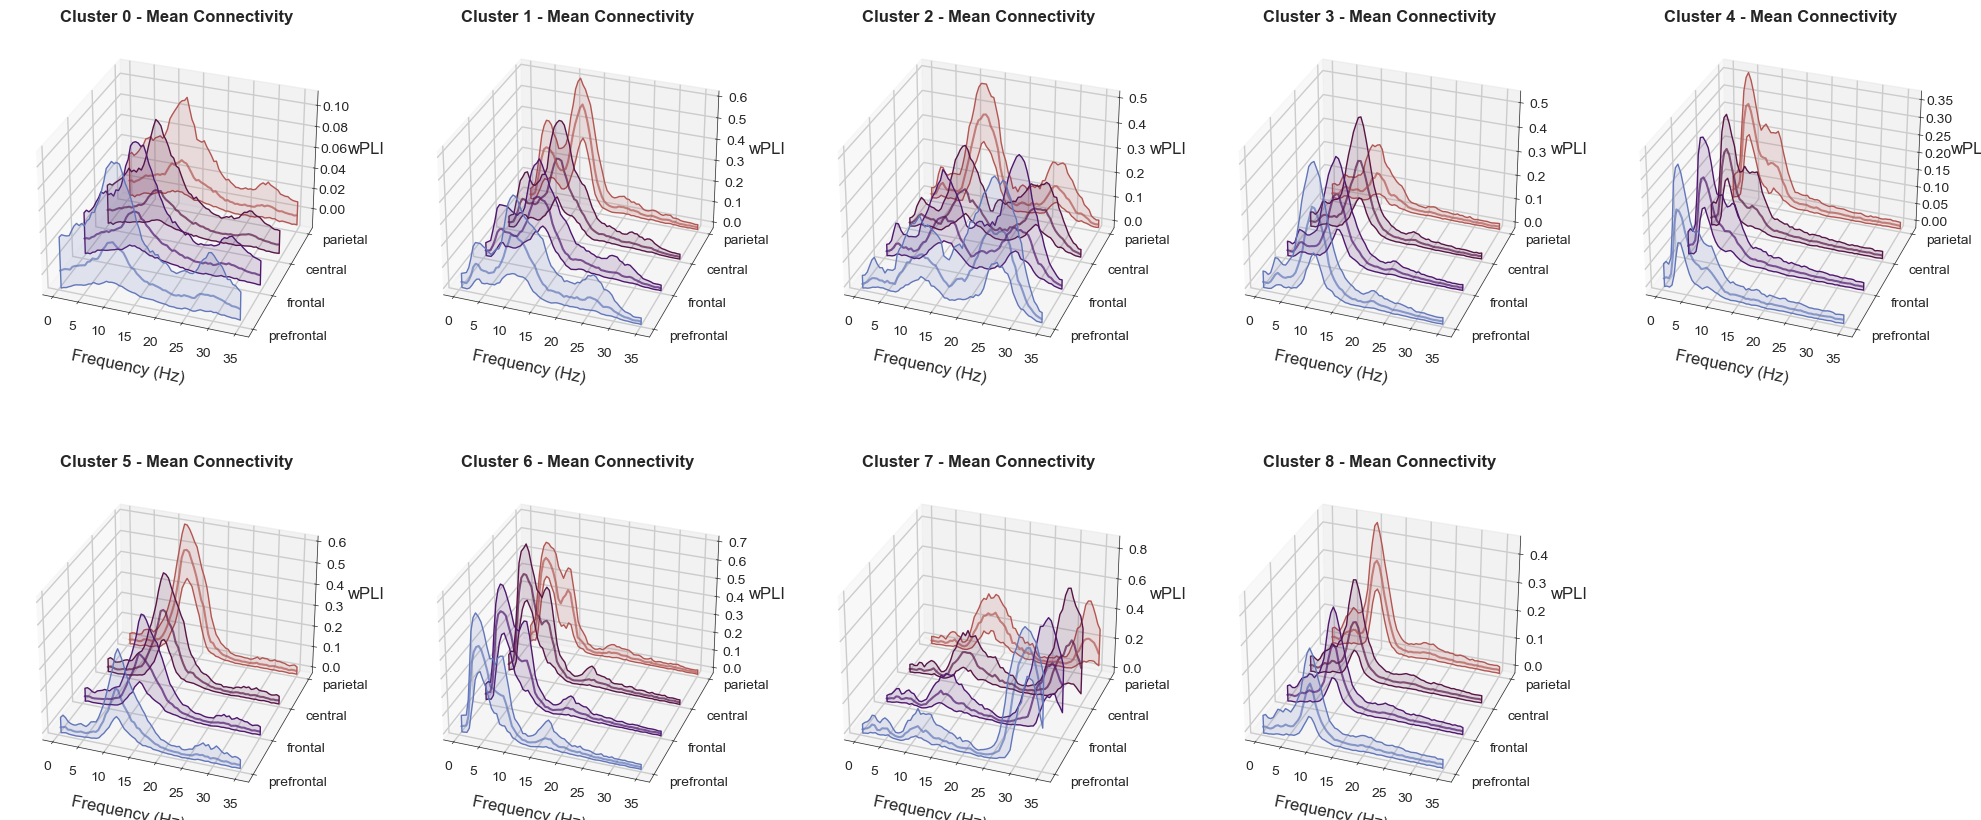

In [80]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# Create artificial spacing for regions on the z-axis
z_spacing = np.arange(len(region_names))

def plot_with_iqr(ax, freqs, z_idx, connectivity, iqr, color):
    ax.plot(freqs, [z_idx] * len(freqs), connectivity, color=color, alpha=0.7)

    # Create polygons for IQR
    verts = [list(zip(freqs, [z_idx] * len(freqs), iqr[0])), list(zip(freqs, [z_idx] * len(freqs), iqr[1]))]
    poly = Poly3DCollection([verts[0] + verts[1][::-1]], color=color, alpha=0.15)
    ax.add_collection3d(poly)

# Plot Mean Connectivity with artificial distances as the 3rd dimension
rows = 2
cols = int(np.ceil(len(uniq_cluster_labels) / 2))
fig1 = plt.figure(figsize=(5*cols, 12))
for idx, cluster_label in enumerate(uniq_cluster_labels):
    ax = fig1.add_subplot(rows, cols, idx + 1, projection='3d')
    for region_idx, region_name in enumerate(region_names):
        connectivity = mean_connectivities[cluster_label][region_name]
        iqr = iqr_connectivities[cluster_label][region_name]
        
        # Using the function for plotting with IQR
        plot_with_iqr(ax, freqs_low_res, z_spacing[region_idx], connectivity, iqr, region_colors[region_idx])

    # Set visual parameters
    # ax.set_zlim([0, 0.8])
    ax.set_xlabel('Frequency (Hz)', fontsize=12)
    ax.set_yticks(z_spacing)
    ax.set_yticklabels(region_names, rotation=0, va='bottom', ha='left')
    # ax.set_ylabel('Region', fontsize=12)
    ax.set_zlabel('wPLI', fontsize=12)
    ax.view_init(elev=30, azim=-70)  # Adjust angles for viewing
    ax.set_title(f'Cluster {cluster_label} - Mean Connectivity', fontsize=12, fontweight='bold')
    ax.tick_params(labelsize=10)

    if idx == 0:
        ax.legend()

plt.subplots_adjust(bottom=0.2)
# plt.tight_layout()
plt.show()

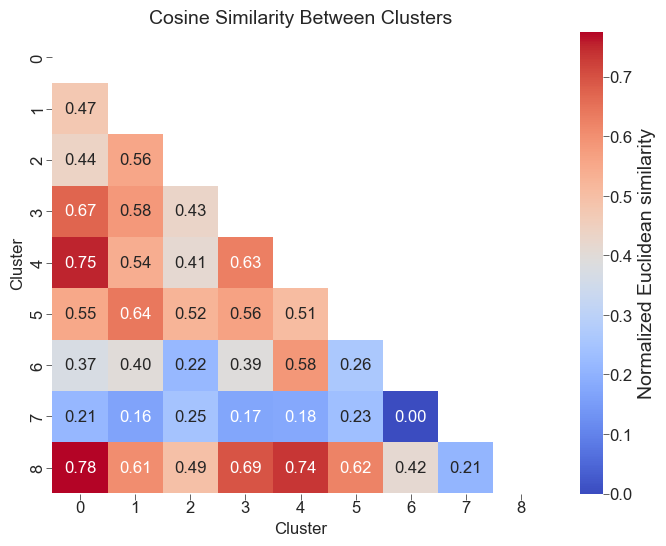

In [81]:
# 4. Compute Cosine Similarity Between Connectivity Vectors
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.preprocessing import MinMaxScaler

# Calculate each cluster's inter-region mean/median connectivties and concatenate them as a single vector 
cluster_mean_connectivities_flatten = {}
# Iterate over each cluster label
for cluster_label in uniq_cluster_labels:
    cluster_idx = cluster_labels_all == cluster_label
    cluster_wpli_data = wpli_concatenated_all[:, :, :, cluster_idx]
    list_of_inter_region_wplis = []

    # Extract inter-region connectivity values and flatten
    for region_i in range(num_regions):
        for region_j in range(region_i):
            list_of_inter_region_wplis.append(np.nanmedian(cluster_wpli_data[region_i, region_j], axis=-1))

    cluster_mean_connectivities_flatten[cluster_label] = np.concatenate(list_of_inter_region_wplis)


# Convert dictionary to an array for cosine similarity computation
cluster_vectors = np.array([cluster_mean_connectivities_flatten[label] for label in uniq_cluster_labels])

# Compute cosine similarity matrix
# cosine_sim_matrix = cosine_similarity(cluster_vectors)

# Compute Euclidean distance matrix
euclidean_dist_matrix = euclidean_distances(cluster_vectors)
# euclidean_sim_matrix = 1/(1+euclidean_dist_matrix)
# scaler = MinMaxScaler()
# euclidean_dist_matrix_norm = scaler.fit_transform(euclidean_dist_matrix)
# Compute global min and max
min_val = np.min(euclidean_dist_matrix)
max_val = np.max(euclidean_dist_matrix)

# Apply global min-max normalization
euclidean_dist_matrix_norm = (euclidean_dist_matrix - min_val) / (max_val - min_val)
euclidean_sim_matrix = 1 - euclidean_dist_matrix_norm

# Mask the upper triangle and diagonal
mask = np.triu(np.ones_like(euclidean_sim_matrix, dtype=bool))
# Create a masked array
masked_sim_matrix = np.ma.array(euclidean_sim_matrix, mask=mask)


# Plot the cosine similarity matrix
fig, ax = plt.subplots(figsize=(8, 6))
cax = sns.heatmap(masked_sim_matrix, annot=True, fmt=".2f", annot_kws={"size": 12}, 
                   cmap='coolwarm', mask=np.triu(np.ones_like(masked_sim_matrix, dtype=bool)), 
                #    vmin=0, vmax=1, 
                   cbar_kws={"label": 
                             "Euclidean similarity"
                            #  "Cosine Similarity"
                            }
                   ) 

# Set axis labels
ax.set_xticklabels(uniq_cluster_labels, fontsize=12)
ax.set_yticklabels(uniq_cluster_labels, fontsize=12)
ax.set_xlabel('Cluster', fontsize=12)
ax.set_ylabel('Cluster', fontsize=12)
ax.set_title('Cosine Similarity Between Clusters', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12, length=4)

cbar = cax.collections[0].colorbar 
# cbar.ax.set_ylabel("Cosine Similarity", fontsize=14) 
# cbar.ax.set_ylabel("1/(1+Euclidean distance)", fontsize=14)
cbar.ax.set_ylabel("Normalized Euclidean similarity", fontsize=14)
cbar.ax.tick_params(labelsize=12, length=4) 

plt.show()

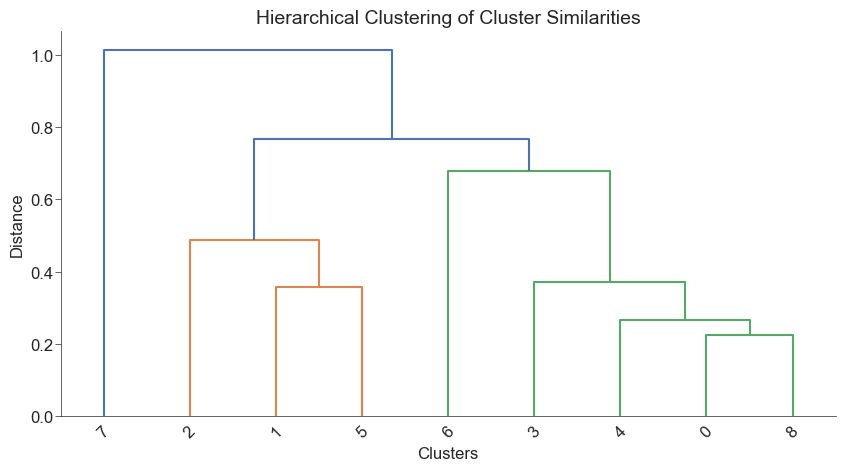

Cluster 1: [1, 2, 5]
Cluster 2: [0, 3, 4, 8]
Cluster 3: [6]
Cluster 4: [7]


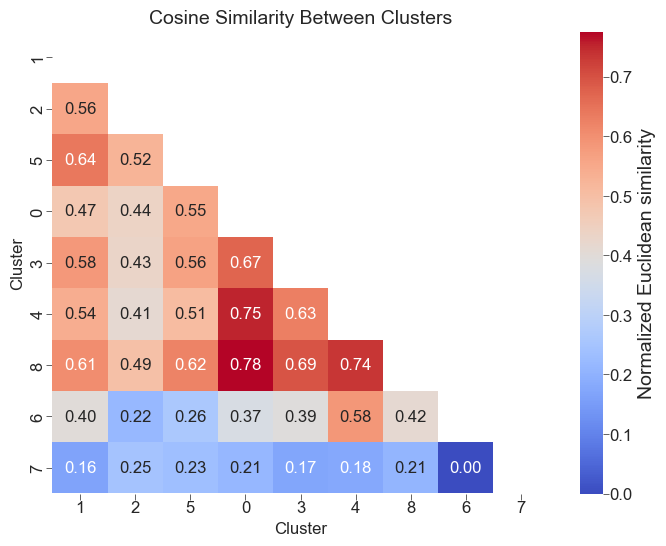

In [82]:
# Identify groups of cluster/states that are similar to each other

import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import fcluster


# Convert cosine similarity matrix to a distance matrix
# distance_matrix = 1 - cosine_sim_matrix  # Ensure masked values are handled properly
# distance_matrix = 1 - euclidean_sim_matrix
distance_matrix = euclidean_dist_matrix_norm
distance_matrix = (distance_matrix + distance_matrix.T) / 2
np.fill_diagonal(distance_matrix, 0)

# Perform hierarchical clustering (ward method minimizes variance)
linkage_matrix = sch.linkage(squareform(distance_matrix), method='ward')

# Plot the dendrogram
plt.figure(figsize=(10, 5))
dendro = sch.dendrogram(linkage_matrix, labels=uniq_cluster_labels, leaf_rotation=45)
plt.title("Hierarchical Clustering of Cluster Similarities", fontsize=14)
plt.xlabel("Clusters", fontsize=12)
plt.ylabel("Distance", fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=12, length=4)
plt.show()


# Choose number of clusters (e.g., based on the dendrogram)
num_groups = 4  # Adjust based on dendrogram

# Extract cluster labels
cluster_labels_v2 = fcluster(linkage_matrix, num_groups, criterion='maxclust')

# Print or analyze the clusters
for i in range(1, num_groups + 1):
    print(f"Cluster {i}: {[uniq_cluster_labels[j] for j in range(len(cluster_labels_v2)) if cluster_labels_v2[j] == i]}")


# Reorder the similarity matrix based on hierarchical clustering
sorted_indices = np.argsort(cluster_labels_v2)  # Order clusters
sorted_matrix = masked_sim_matrix[sorted_indices, :][:, sorted_indices]
sorted_labels = [uniq_cluster_labels[i] for i in sorted_indices]

fig, ax = plt.subplots(figsize=(8, 6))
cax = sns.heatmap(sorted_matrix, xticklabels=sorted_labels, yticklabels=sorted_labels, 
                annot=True, fmt=".2f", annot_kws={"size": 12}, 
                cmap='coolwarm',
                # vmin=0, vmax=1, 
                mask=np.triu(np.ones_like(masked_sim_matrix, dtype=bool)), 
                cbar_kws={"label": "Cosine Similarity"})

# Set axis labels
ax.set_xlabel('Cluster', fontsize=12)
ax.set_ylabel('Cluster', fontsize=12)
ax.set_title('Cosine Similarity Between Clusters', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12, length=4)

cbar = cax.collections[0].colorbar 
# cbar.ax.set_ylabel("Cosine Similarity", fontsize=14)
# cbar.ax.set_ylabel("1/(1+Euclidean distance)", fontsize=14)
cbar.ax.set_ylabel("Normalized Euclidean similarity", fontsize=14)
cbar.ax.tick_params(labelsize=12, length=4) 

plt.show()

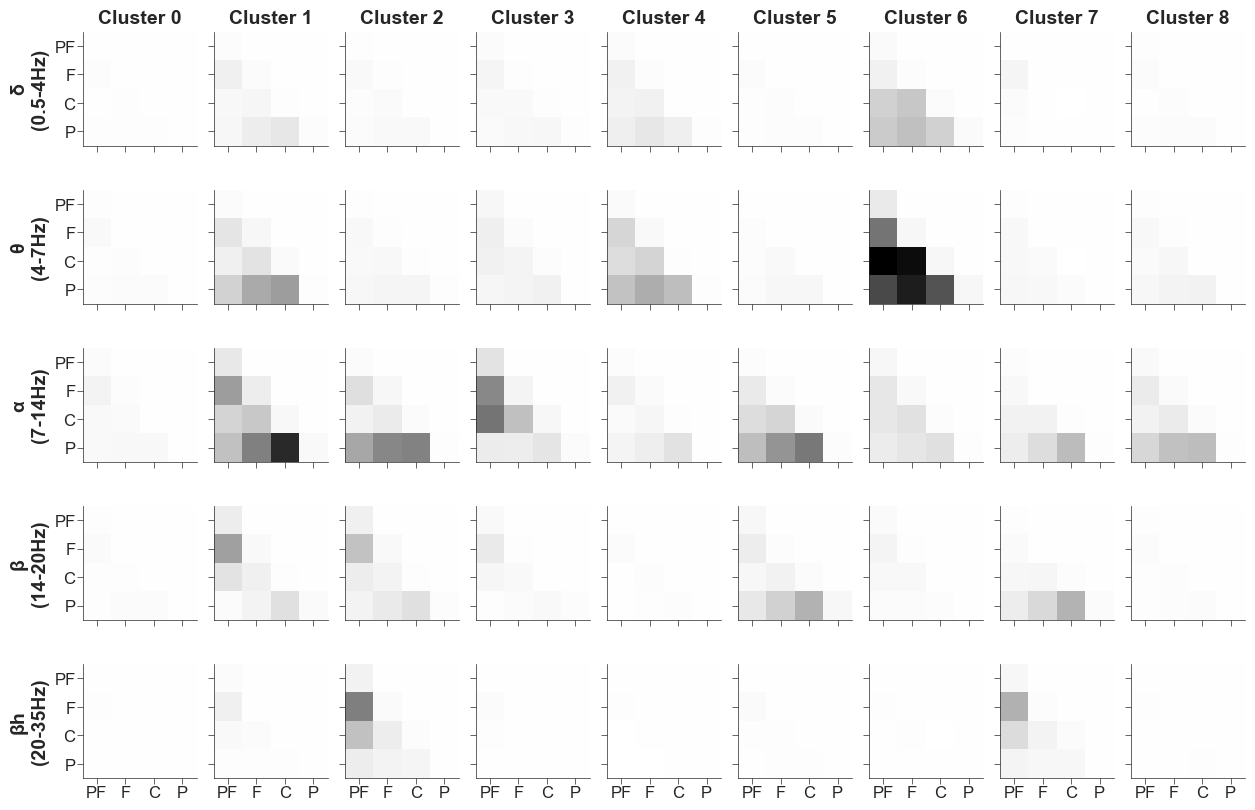

In [83]:
# 5. Compute Connectivity Matrix for Each State and Frequency Band
fband_connectivity = {}
mean_fband_connectivity = {}
freq_bands_dict = pli.frequency_bands_of_interest

if 'bb' in freq_bands_dict:
    freq_bands_dict.pop('bb')

# Get indices for lower triangular part (excluding the diagonal)
# tril_indices = np.tril_indices(num_regions, k=-1)  # k=-1 excludes diagonal

# Store connectivity matrices for PCA analysis
# clusters_connectivity_data = []
# labels = []

for cluster_label in uniq_cluster_labels:
    
    fband_connectivity[cluster_label] = {}
    mean_fband_connectivity[cluster_label] = {}
    
    cluster_idx = cluster_labels_all == cluster_label
    cluster_wpli_data = wpli_concatenated_all[:, :, :, cluster_idx]
    
    cluster_connectivity_data = []
    for fband_name, fband in freq_bands_dict.items():

        freq_idx = np.logical_and(freqs_low_res >= fband[0], freqs_low_res < fband[1])
        mean_fband_connectivity[cluster_label][fband_name] = np.nanmedian(cluster_wpli_data[:, :, freq_idx, :], axis=(2, 3))

#         # Flatten the connectivity matrix and store for PCA
#         flattened_matrix = mean_fband_connectivity[cluster_label][fband_name][tril_indices].flatten()
#         cluster_connectivity_data.append(flattened_matrix)

#     cluster_connectivity_data = np.array(cluster_connectivity_data).flatten()
#     clusters_connectivity_data.append(cluster_connectivity_data)

#     labels.append(f"Cluster {cluster_label}")

# clusters_connectivity_data = np.array(clusters_connectivity_data)

# Plot the connectivity matrix for each cluster and frequency band
rows = len(freq_bands_dict)
cols = len(uniq_cluster_labels)
fig = plt.figure(figsize=(15, 10))
gs = GridSpec(rows, cols, figure=fig, hspace=0.15, wspace=0.15)

vmin = np.nanmin([
     np.nanmin(mean_fband_connectivity[cluster_label][fband_name]) 
    for cluster_label in uniq_cluster_labels 
    for fband_name in freq_bands_dict.keys()
])

vmax = np.nanmax([
    np.nanmax(mean_fband_connectivity[cluster_label][fband_name]) 
    for cluster_label in uniq_cluster_labels 
    for fband_name in freq_bands_dict.keys()
])


greek_fband_names = generate_greek_band_names(fbands)
region_acrs =  generate_region_acronyms(region_names)

for cluster_idx, cluster_label in enumerate(uniq_cluster_labels):
    for fband_idx, fband_name in enumerate(freq_bands_dict.keys()):
        ax = fig.add_subplot(gs[fband_idx, cluster_idx])
        
        # Plot the matrix
        im = ax.imshow(mean_fband_connectivity[cluster_label][fband_name], cmap='Grays', origin='upper', vmin=vmin, vmax=vmax)
        if fband_idx == 0:
            ax.set_title(f'Cluster {cluster_label}', fontsize=14, fontweight='bold')
        
        ax.set_xticks(range(num_regions))
        if fband_idx == len(freq_bands_dict)-1:
            ax.set_xticklabels([region_acrs[name] for name in region_names], fontsize=12)
        else:
            ax.set_xticklabels([])
        
        ax.set_yticks(range(num_regions))
        if cluster_idx == 0:
            ax.set_yticklabels([region_acrs[name] for name in region_names], fontsize=12)
        else:
            ax.set_yticklabels([])
        
        if cluster_idx == 0:
            ax.set_ylabel(f'{greek_fband_names[fband_name]}\n({pli.frequency_bands_of_interest[fband_name][0]}-{pli.frequency_bands_of_interest[fband_name][1]}Hz)',
                           fontsize=14, fontweight='bold', rotation=90, loc='center')

        ax.tick_params(length=4)

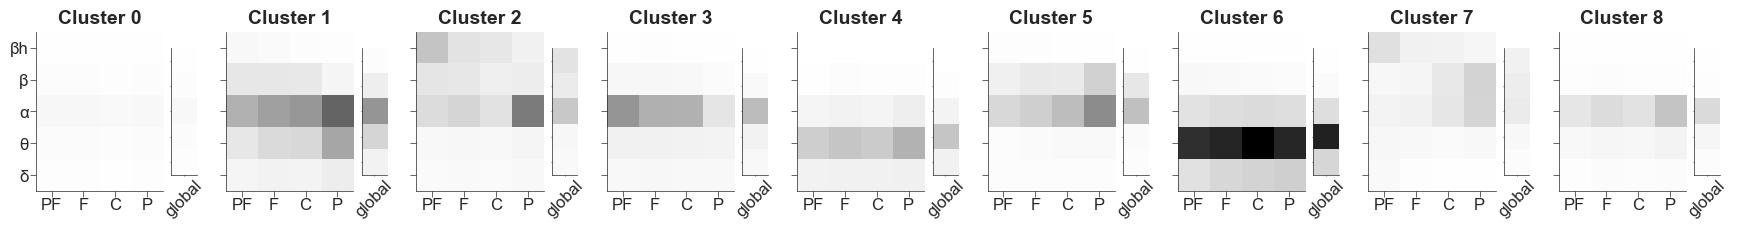

In [84]:
# 6. Compute Region-Wise Mean Connectivity for Each State and Frequency Band
fband_region_mean_connectivity = {}
fband_global_mean_connectivity = {}
region_name_log = []
freq_band_log = []
for cluster_idx, cluster_label in enumerate(uniq_cluster_labels):
    
    fband_region_mean_connectivity[cluster_label] = np.full((len(freq_bands_dict), len(region_names)), np.nan)
    fband_global_mean_connectivity[cluster_label] = np.full((len(freq_bands_dict),), np.nan)

    cluster_wpli_data = wpli_concatenated_all[:, :, :, cluster_labels_all == cluster_label]
        
    for fband_idx, (fband_name, fband) in enumerate(freq_bands_dict.items()):

        freq_idx = np.logical_and(freqs_low_res >= fband[0], freqs_low_res < fband[1])
        if cluster_idx == 0:
            freq_band_log.append(fband_name)

        fband_global_conn_val_list = []
        for region_idx, region_name in enumerate(region_names):
            
            if cluster_idx == 0 and fband_idx == 0:
                region_name_log.append(region_name)

            # extract all connectivties of the current region with the other regions
            fband_region_conn_val_list = []
            for alt_region_idx in range(num_regions):
                if region_idx > alt_region_idx:
                    curr_conn_vals = np.nanmedian(cluster_wpli_data[region_idx, alt_region_idx, freq_idx, :], axis=0).reshape(-1)
                    fband_region_conn_val_list.extend(curr_conn_vals)
                    fband_global_conn_val_list.extend(curr_conn_vals)
                elif region_idx < alt_region_idx:
                    curr_conn_vals = np.nanmedian(cluster_wpli_data[alt_region_idx, region_idx, freq_idx, :], axis=0).reshape(-1)
                    fband_region_conn_val_list.extend(curr_conn_vals)
                    fband_global_conn_val_list.extend(curr_conn_vals)

            fband_region_mean_connectivity[cluster_label][fband_idx, region_idx] = np.nanmedian(np.array(fband_region_conn_val_list))
            # >> NOTE: Potential adding of the IQRs
        
        fband_global_mean_connectivity[cluster_label][fband_idx] = np.nanmedian(np.array(fband_global_conn_val_list))

# Plot the connectivity matrix for each cluster and frequency band
rows = 1
cols = len(uniq_cluster_labels) * 3
fig = plt.figure(figsize=(22, 3))
gs = GridSpec(rows, cols, figure=fig, hspace=0.15, wspace=0.15, width_ratios=[1, 0.2, 0.1]*len(uniq_cluster_labels))


vmin = np.nanmin([
    np.nanmin(fband_region_mean_connectivity[cluster_label]) 
    for cluster_label in uniq_cluster_labels 
])

vmax = np.nanmax([
    np.nanmax(fband_region_mean_connectivity[cluster_label]) 
    for cluster_label in uniq_cluster_labels
])

greek_fband_names = generate_greek_band_names(fbands)
region_acrs =  generate_region_acronyms(region_names)

for cluster_idx, cluster_label in enumerate(uniq_cluster_labels):
    ax = fig.add_subplot(gs[0, cluster_idx*3])
    
    # Plot the matrix
    im = ax.imshow(fband_region_mean_connectivity[cluster_label], cmap='Grays', origin='lower', vmin=vmin, vmax=vmax)

    ax.set_title(f'Cluster {cluster_label}', fontsize=14, fontweight='bold')
    ax.set_xticks(range(num_regions))
    ax.set_xticklabels([region_acrs[name] for name in region_names], fontsize=12)
    
    ax.set_yticks(range(len(freq_bands_dict)))
    if cluster_idx == 0:
        ax.set_yticklabels([f'{greek_fband_names[fband_name]}' for fband_name in freq_bands_dict.keys()], fontsize=12)
    else:
        ax.set_yticklabels([])

    ax.tick_params(length=4)

    # Plot the global mean connectivties per frequency band
    ax2 = fig.add_subplot(gs[0, cluster_idx*3+1])
    im = ax2.imshow(fband_global_mean_connectivity[cluster_label].reshape(-1,1), cmap='Grays', origin='lower', vmin=vmin, vmax=vmax)
    ax2.set_xticks([0])
    ax2.set_xticklabels(['global'], fontsize=12, rotation=45)
    ax2.set_yticklabels([])

In [ ]:
# 8. Compute Variability (Heterogeneity) Using CV for Each State and Frequency Band

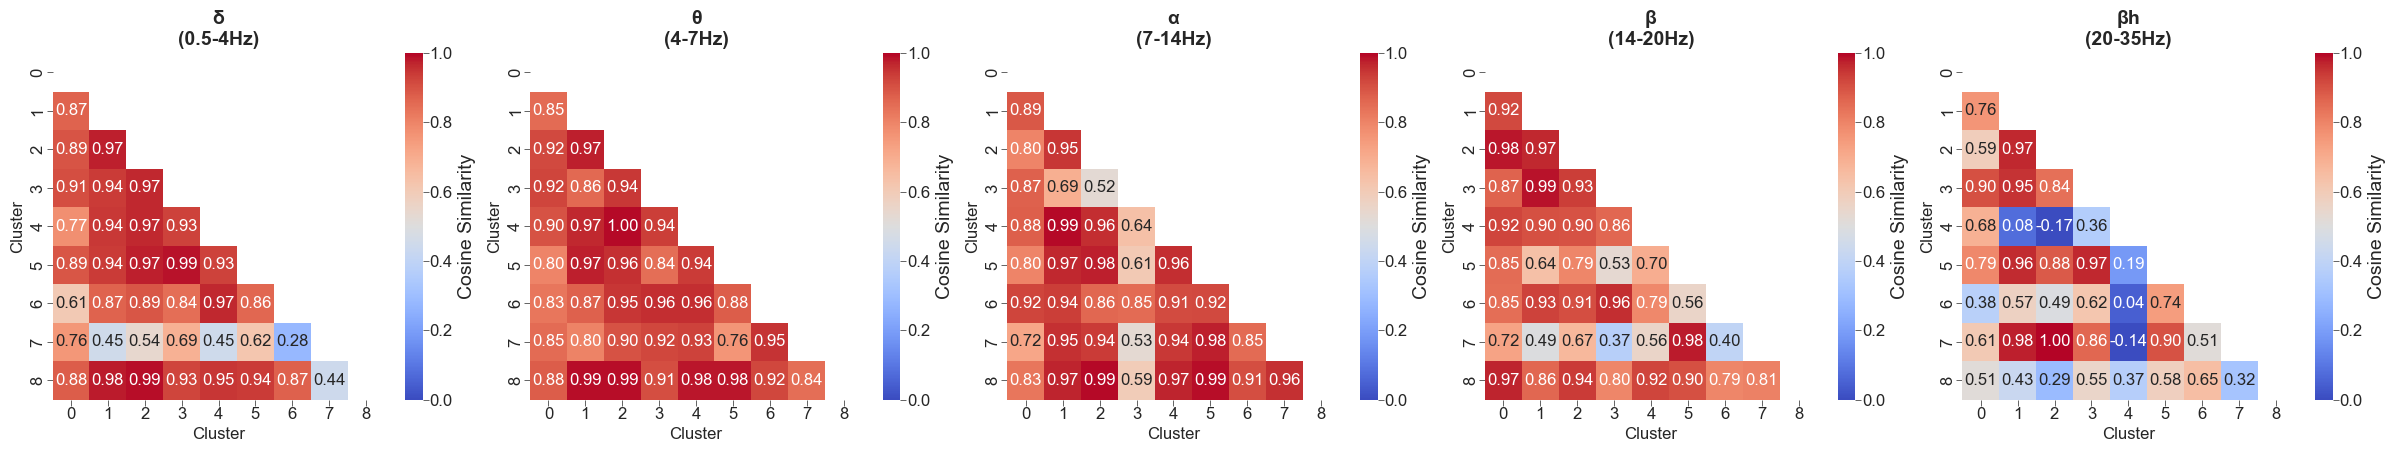

In [85]:
# 9. Compute Cosine Similarity Between Connectivity Vectors Across States Within Each Frequency Band 
# >> NOTE: This provides some insights into if the spatial pattern of cluster activation in a specific frequency band are similar or distinct from each other
cluster_mean_connectivities_flatten = {}
# Iterate over each cluster label
for cluster_label in uniq_cluster_labels:
    cluster_idx = cluster_labels_all == cluster_label
    cluster_wpli_data = wpli_concatenated_all[:, :, :, cluster_idx]
    
    cluster_mean_connectivities_flatten[cluster_label] = {}
    
    for fband_idx, (fband_name, fband) in enumerate(freq_bands_dict.items()):

        list_of_inter_region_wplis = []

        # Extract inter-region connectivity values and flatten
        for region_i in range(num_regions):
            for region_j in range(region_i):
                list_of_inter_region_wplis.append(mean_fband_connectivity[cluster_label][fband_name][region_i, region_j])

        cluster_mean_connectivities_flatten[cluster_label][fband_name] = np.array(list_of_inter_region_wplis)
        

masked_cosine_sim = {}
for fband_name in freq_bands_dict.keys():
    
    # Convert dictionary to an array for cosine similarity computation
    cluster_vectors = np.array([cluster_mean_connectivities_flatten[label][fband_name] for label in uniq_cluster_labels])

    # Compute cosine similarity matrix
    cosine_sim_matrix = cosine_similarity(cluster_vectors)
    # Mask the upper triangle and diagonal
    mask = np.triu(np.ones_like(cosine_sim_matrix, dtype=bool))
    # Create a masked array
    masked_cosine_sim[fband_name] = np.ma.array(cosine_sim_matrix, mask=mask)

# Plot the cosine similarity matrix
rows = 1
cols = len(freq_bands_dict)
fig = plt.figure(figsize=(30, 4.5))
gs = GridSpec(rows, cols, figure=fig, hspace=0.15, wspace=0.15)

for fband_idx, fband_name in enumerate(freq_bands_dict.keys()):

    ax = fig.add_subplot(gs[0, fband_idx])

    cax = sns.heatmap(masked_cosine_sim[fband_name], annot=True, fmt=".2f", annot_kws={"size": 12}, 
                    cmap='coolwarm', vmin=0, vmax=1, mask=np.triu(np.ones_like(masked_cosine_sim[fband_name], dtype=bool)), 
                    cbar_kws={"label": "Cosine Similarity"})

    # Set axis labels
    ax.set_xticklabels(uniq_cluster_labels, fontsize=12)
    ax.set_yticklabels(uniq_cluster_labels, fontsize=12)
    ax.set_xlabel('Cluster', fontsize=12)
    ax.set_ylabel('Cluster', fontsize=12)
    ax.set_title(f'{greek_fband_names[fband_name]}\n({pli.frequency_bands_of_interest[fband_name][0]}-{pli.frequency_bands_of_interest[fband_name][1]}Hz)',
                           fontsize=14, fontweight='bold', loc='center')
    ax.tick_params(axis='both', which='major', labelsize=12, length=4)

    cbar = cax.collections[0].colorbar 
    cbar.ax.set_ylabel("Cosine Similarity", fontsize=14) 
    cbar.ax.tick_params(labelsize=12, length=4) 

plt.show()

# >>TODO: Calculate the average cosine simiarlity for each freuqnecy band --> Which frequency bands show maximum distinct spatial pattern between the clusters? 

#### Plot the emergence trajectory for each patient within the state space comprised of the first three PCs
The following only works with the ordinary unweighted PCA for now

CA-01


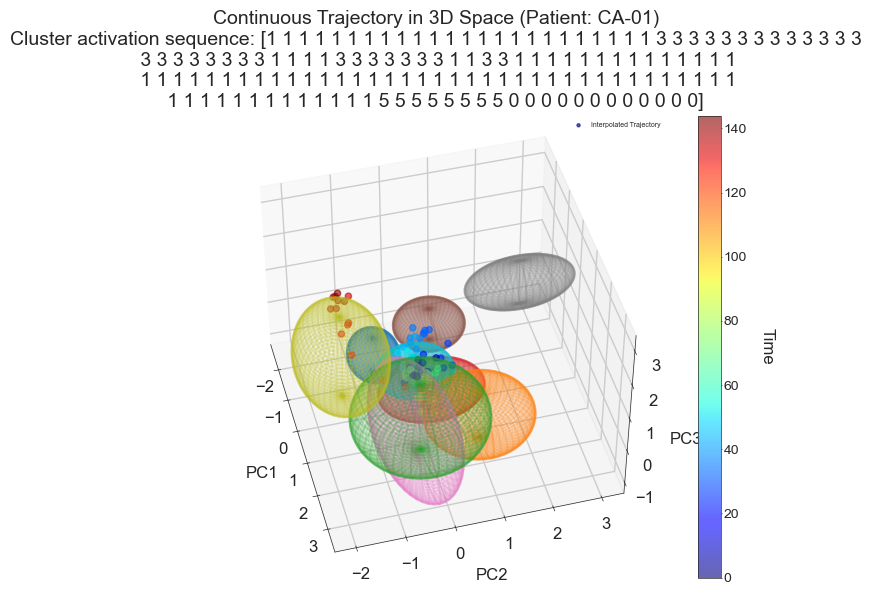

In [86]:
for p_name in [(groups['A'] + groups['B'])[20]]:  
    print(p_name)

    patient_wpli_data = df_patient_data[df_patient_data['patient_name']==p_name]['data'].to_numpy()[0]

    # Step 1: Create a single feature matrix for the patient
    list_of_conn_win_anta = []
    for reg_idx_a, region_a in enumerate(region_names):
        for reg_idx_b, region_b in enumerate(region_names):
            if reg_idx_a > reg_idx_b:
                list_of_conn_win_anta.append(
                    patient_wpli_data[reg_idx_a, reg_idx_b, :, :]
                )

    # Concatenate the data
    conn_win_anta_flattened = np.concatenate(list_of_conn_win_anta, axis=0)

    # Step 1: Centering the data (zero mean)
    X_centered_patient = conn_win_anta_flattened - np.mean(conn_win_anta_flattened, axis=1, keepdims=True)

    # Step 2: Perform PCA
    X_pca_transformed_patient = pca.transform(X_centered_patient.T)  # PCA expects observations as rows, so transpose X

    # Step 3: Project the data to the top 3 PCs
    X_pca_transformed_3_patient = X_pca_transformed_patient[:, :3]  # Select first 3 PCs

    # Step 4: Interpolation for a continuous trajectory
    time = np.linspace(0, X_centered_patient.shape[1], X_centered_patient.shape[1])  # Original time points
    num_interp_points = 100  # Define more points for smoothness
    time_interp = np.linspace(time.min(), time.max(), num_interp_points)

    # Interpolate each PC separately using cubic interpolation
    interp_func_x = interp1d(time, X_pca_transformed_3_patient[:, 0], kind='cubic')
    interp_func_y = interp1d(time, X_pca_transformed_3_patient[:, 1], kind='cubic')
    interp_func_z = interp1d(time, X_pca_transformed_3_patient[:, 2], kind='cubic')

    X_interp = interp_func_x(time_interp)
    Y_interp = interp_func_y(time_interp)
    Z_interp = interp_func_z(time_interp)

    # Step 5: Plot the interpolated trajectory in 3D space
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')

    # Color code based on original time scale
    # sc = ax.scatter(X_pca_transformed_3_patient[:, 0], X_pca_transformed_3_patient[:, 1], X_pca_transformed_3_patient[:, 2], c=time, cmap='viridis', alpha=0.6, label="Original Points")
    sc = ax.scatter(X_interp, Y_interp, Z_interp, c=time_interp, cmap='jet', alpha=0.6, label="Interpolated Trajectory")

    
    # Draw ellipsoids around clusters (same color as cluster points)
    u = np.linspace(0, 2 * np.pi, 50)  # Angular grid for sphere
    v = np.linspace(0, np.pi, 50)  # Elevation grid for sphere

    for i in range(num_clusters):
        # Create a unit sphere
        x_sphere = np.outer(np.cos(u), np.sin(v))
        y_sphere = np.outer(np.sin(u), np.sin(v))
        z_sphere = np.outer(np.ones(np.size(u)), np.cos(v))

        # Scale the sphere into an ellipsoid using cluster-specific standard deviations
        x_ellipsoid = radii_pc[i, 0] * x_sphere + centroids[i, 0]
        y_ellipsoid = radii_pc[i, 1] * y_sphere + centroids[i, 1]
        z_ellipsoid = radii_pc[i, 2] * z_sphere + centroids[i, 2]

        ax.plot_wireframe(x_ellipsoid, y_ellipsoid, z_ellipsoid, color=cluster_colors[i], alpha=0.2)
    margin = -0.5
    ax.set_xlim(x_min - margin, x_max + margin)
    ax.set_ylim(y_min - margin, y_max + margin)
    ax.set_zlim(z_min - margin, z_max + margin)

    ax.tick_params(labelsize=12, length=4)

    # ax.view_init(elev=45, azim=60)
    ax.view_init(elev=45, azim=-15)
    # ax.view_init(elev=45, azim=135)

    cluster_labels_patient = df_patient_data['cluster_labels'][df_patient_data['patient_name'] == p_name].to_numpy()[0]
    
    # Labels and formatting
    cbar = fig.colorbar(sc)
    ax.set_xlabel("PC1", fontsize=12)
    ax.set_ylabel("PC2", fontsize=12)
    ax.set_zlabel("PC3", fontsize=12)
    ax.set_title(f"Continuous Trajectory in 3D Space (Patient: {p_name})\nCluster activation sequence: {cluster_labels_patient} ", fontsize=14)
    cbar.set_label('Time', rotation=270, labelpad=20, fontsize=12)
    cbar.ax.tick_params(labelsize=10)
    ax.legend()

    plt.show()

#### Investigate the consistency of clustering solution between the two group of patients 

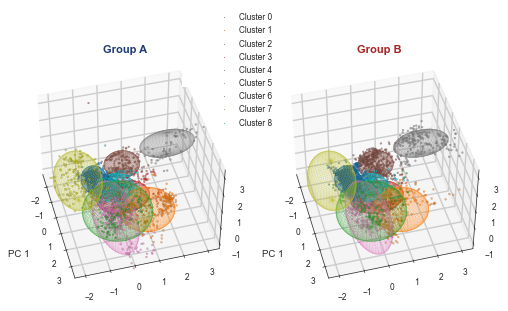

In [87]:
# Display data points from the two group patients in two panels together with the clusters' ellipsoids  
plot_width = 450
plot_height = 250

# fig = plt.figure(figsize=(20, 18))
fig = plt.figure(figsize=(plot_width/72, plot_height/72))

# Mapping group labels to each data point
group_labels_expanded = np.repeat(df_patient_data['group_name'].values, [num_valid_windows for num_valid_windows in df_patient_data['num_valid_windows']])

for idx, group_name in enumerate(['Group A', 'Group B']):
    ax = fig.add_subplot(1, 2, idx + 1, projection='3d')

    # Filter points belonging to the current group
    group_points = (group_labels_expanded == group_name)

    # Scatter plot for individual points (group-specific)
    for i, cl in enumerate(uniq_cluster_labels):
        cluster_points = X_pca_transformed_select_pcs[(cluster_labels == cl) & group_points]
        
        # Skip empty clusters for this group
        if cluster_points.size == 0:
            continue

        # Plot individual points
        ax.scatter(
            cluster_points[:, 0], cluster_points[:, 1], cluster_points[:, 2],
            color=cluster_colors[i], s=2, label=f"Cluster {cl}", alpha=0.6, edgecolor='k', linewidth=0.1
        )

        # # Calculate the centroid for the current cluster and group
        # cluster_centroid = np.mean(cluster_points, axis=0)
        
        # # Plot the group-specific centroid
        # ax.scatter(
        #     cluster_centroid[0], cluster_centroid[1], cluster_centroid[2],
        #     color=cluster_colors[i], marker='*', s=50, edgecolor='black', alpha=0.8
        # )

    # Plot overall centroids for the entire dataset (not group-specific)
    for i in range(num_clusters):
        # ax.scatter(
        #     centroids[i, 0], centroids[i, 1], centroids[i, 2],
        #     color=cluster_colors[i], marker='X', s=50, edgecolor='black', alpha=0.5
        # )

        # Draw ellipsoids around clusters
        u = np.linspace(0, 2 * np.pi, 50)
        v = np.linspace(0, np.pi, 50)
        x_sphere = np.outer(np.cos(u), np.sin(v))
        y_sphere = np.outer(np.sin(u), np.sin(v))
        z_sphere = np.outer(np.ones(np.size(u)), np.cos(v))

        x_ellipsoid = radii_pc[i, 0] * x_sphere + centroids[i, 0]
        y_ellipsoid = radii_pc[i, 1] * y_sphere + centroids[i, 1]
        z_ellipsoid = radii_pc[i, 2] * z_sphere + centroids[i, 2]

        ax.plot_wireframe(x_ellipsoid, y_ellipsoid, z_ellipsoid, color=cluster_colors[i], alpha=0.3, linewidth=0.3)

    # Axis limits
    margin = -0.5
    x_min, x_max = X_pca_transformed_select_pcs[:, 0].min(), X_pca_transformed_select_pcs[:, 0].max()
    y_min, y_max = X_pca_transformed_select_pcs[:, 1].min(), X_pca_transformed_select_pcs[:, 1].max()
    z_min, z_max = X_pca_transformed_select_pcs[:, 2].min(), X_pca_transformed_select_pcs[:, 2].max()

    ax.set_xlim(x_min - margin, x_max + margin)
    ax.set_ylim(y_min - margin, y_max + margin)
    ax.set_zlim(z_min - margin, z_max + margin)

    # Labels and formatting
    ax.set_xlabel("PC 1", fontsize=7)
    ax.set_ylabel("PC 2", fontsize=7)
    ax.set_zlabel("PC 3", fontsize=7)
    # ax.set_title(f"K-Means Clusters and {group_name} data points", fontsize=8, color=BLUE if group_name=='Group A' else RED)
    ax.set_title(f"{group_name}", fontsize=8, fontweight='bold', color=BLUE if group_name=='Group A' else RED)

    # ax.view_init(elev=45, azim=60)
    ax.view_init(elev=45, azim=-15)
    # ax.view_init(elev=45, azim=135)

    if idx == 0:
        legend_lines, legend_labels = ax.get_legend_handles_labels()

    ax.tick_params(labelsize=6, length=4, pad=-0.5)

plt.subplots_adjust(wspace=0.1, right=0.9)

ax_legend = fig.add_subplot([0.4, 0.75, 0.2, 0.1])
ax_legend.legend(legend_lines, legend_labels, loc='center', fontsize=6)
ax_legend.spines['bottom'].set_visible(False)
ax_legend.spines['left'].set_visible(False)
ax_legend.set_xticks([])
ax_legend.set_yticks([])
ax_legend.tick_params(bottom=False, left=False)


# Save the figure
main_dir = 'D:/Anesthesia_Research_Fellow/analysis_results'
filename = 'KMeans_clusters_separate_groups.pdf'
file_path = os.path.join(main_dir, filename)

plt.savefig(file_path, format='pdf', dpi=300)

plt.show()

##### Calculate the overall and pairwise silhoutee score for each group

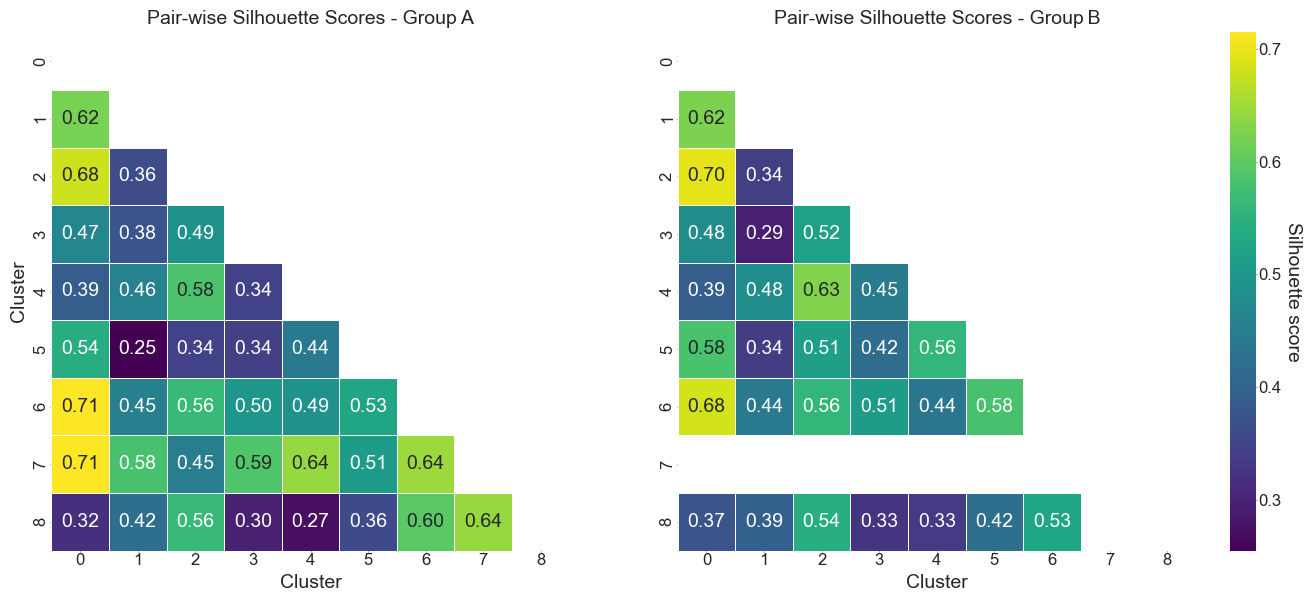


Overall silhouette score per group:
  Group A: 0.256
  Group B: 0.287

Silhouette score: Cluster 0 vs. Rest (per group):
  Group A: 0.111
  Group B: 0.140


In [88]:
import itertools

# X3 = X_pca_transformed_select_pcs[:, :3] 

# ------------------------------------------------------------------
# 1.  Expand patient‑level group labels to window level
# ------------------------------------------------------------------
group_labels_expanded = np.repeat(
    df_patient_data['group_name'].values,
    df_patient_data['num_valid_windows'].values
)

# ------------------------------------------------------------------
# 2.  Pair‑wise silhouette scores per group
# ------------------------------------------------------------------
silhouette_pair = {'Group A': {}, 'Group B': {}}

for grp in ['Group A', 'Group B']:
    in_grp       = (group_labels_expanded == grp)
    X_grp        = X_pca_transformed_select_pcs[in_grp]
    lbls_grp     = cluster_labels[in_grp]

    for i, j in itertools.combinations(uniq_cluster_labels, 2):
        mask_ij = (lbls_grp == i) | (lbls_grp == j)
        X_ij    = X_grp[mask_ij]
        lbl_ij  = lbls_grp[mask_ij]

        # need ≥2 points in each cluster; otherwise set NaN
        if np.sum(lbl_ij == i) < 2 or np.sum(lbl_ij == j) < 2:
            silhouette_pair[grp][(i, j)] = np.nan
        else:
            silhouette_pair[grp][(i, j)] = silhouette_score(X_ij, lbl_ij)

# ------------------------------------------------------------------
# 3.  Convert to square matrices for heat‑maps
# ------------------------------------------------------------------
labels = sorted(uniq_cluster_labels)

def pairdict_to_matrix(pair_dict, labels):
    n = len(labels)
    mat = np.full((n, n), np.nan)
    idx = {lab: k for k, lab in enumerate(labels)}
    for (i, j), val in pair_dict.items():
        ii, jj = idx[i], idx[j]
        mat[ii, jj] = val
        mat[jj, ii] = val
    return pd.DataFrame(mat, index=labels, columns=labels)

mat_A = pairdict_to_matrix(silhouette_pair['Group A'], labels)
mat_B = pairdict_to_matrix(silhouette_pair['Group B'], labels)

# ------------------------------------------------------------------
# 4.  Plot heat‑maps with a common colour scale
# ------------------------------------------------------------------
mask_upper = np.triu(np.ones_like(mat_A, dtype=bool), k=1)   # k=1 keeps diagonal

vmin = np.nanmin([mat_A.values, mat_B.values])
vmax = np.nanmax([mat_A.values, mat_B.values])

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Group A
sns.heatmap(mat_A, ax=axes[0], mask=mask_upper,
            vmin=vmin, vmax=vmax, cmap='viridis',
            annot=True, annot_kws={"size": 14}, fmt=".2f",
            linewidths=.5, square=True, cbar=False)

axes[0].set_title("Pair-wise Silhouette Scores - Group A", fontsize=14)
axes[0].set_xlabel("Cluster", fontsize=14); axes[0].set_ylabel("Cluster", fontsize=14)
axes[0].tick_params(labelsize=12)

# Group B
hmap_B = sns.heatmap(mat_B, ax=axes[1], mask=mask_upper,
            vmin=vmin, vmax=vmax, cmap='viridis',
            annot=True, annot_kws={"size": 14}, fmt=".2f",
            linewidths=.5, square=True, cbar=True,
            cbar_kws={'label': 'Silhouette score'})
axes[1].set_title("Pair-wise Silhouette Scores - Group B", fontsize=14)
axes[1].set_xlabel("Cluster", fontsize=14); axes[1].set_ylabel("")
axes[1].tick_params(labelsize=12)

cbar = hmap_B.collections[0].colorbar

cbar.ax.tick_params(labelsize=12)       
cbar.set_label('Silhouette score',
               fontsize=14,
               rotation=270,
               labelpad=15) 

plt.tight_layout()
plt.show()


# ------------------------------------------------------------------
# 5.  Overall silhouette & Cluster‑0‑vs‑Rest silhouette per group
# ------------------------------------------------------------------
overall_silhouette = {}
cluster0_vs_rest   = {}

for grp in ['Group A', 'Group B']:
    in_grp   = (group_labels_expanded == grp)
    X_grp    = X_pca_transformed_select_pcs[in_grp]
    lbls_grp = cluster_labels[in_grp]

    # --------------------------------------------------
    # (a) overall silhouette  – ignore clusters with <2 points
    # --------------------------------------------------
    unique, counts = np.unique(lbls_grp, return_counts=True)
    keep_labels    = unique[counts >= 2]

    if len(keep_labels) > 1:                     # need at least 2 clusters left
        mask_keep   = np.isin(lbls_grp, keep_labels)
        overall_silhouette[grp] = silhouette_score(
            X_grp[mask_keep], lbls_grp[mask_keep])
    else:
        overall_silhouette[grp] = np.nan

    # --------------------------------------------------
    # (b) Cluster‑0 vs Rest silhouette  (both classes need ≥2)
    # --------------------------------------------------
    bin_lbls = np.where(lbls_grp == 0, 0, 1)
    if np.sum(bin_lbls == 0) >= 2 and np.sum(bin_lbls == 1) >= 2:
        cluster0_vs_rest[grp] = silhouette_score(X_grp, bin_lbls)
    else:
        cluster0_vs_rest[grp] = np.nan


print("\nOverall silhouette score per group:")
for g, s in overall_silhouette.items():
    print(f"  {g}: {s:.3f}")

print("\nSilhouette score: Cluster 0 vs. Rest (per group):")
for g, s in cluster0_vs_rest.items():
    print(f"  {g}: {s:.3f}")


##### Calculate the Euclidean distance of points within each cluster from cluster 0's centroid

In [ ]:
# ------------------------------------------------------------
# 0.  Restrict to the first three PCs
# ------------------------------------------------------------
X3 = X_pca_transformed_select_pcs[:, :3]            # (N, 3)

# ------------------------------------------------------------
# 1.  Observed mean distances, cluster k → C0  (per group)
# ------------------------------------------------------------
obs_dist = {'Group A': {}, 'Group B': {}}     # obs_dist[g][k] = mean distance

for grp in ['Group A', 'Group B']:
    idx_c0 = (group_labels_expanded == grp) & (cluster_labels == 0)
    if idx_c0.sum() == 0:
        raise ValueError(f"No Cluster 0 points in {grp}.")
    centroid0 = X3[idx_c0].mean(axis=0)

    for k in uniq_cluster_labels:
        if k == 0:
            continue
        idx_k = (group_labels_expanded == grp) & (cluster_labels == k)
        if idx_k.sum() == 0:
            obs_dist[grp][k] = np.nan           # cluster absent in this group
        else:
            obs_dist[grp][k] = np.linalg.norm(X3[idx_k] - centroid0, axis=1).mean()

# Observed between‑group differences
delta_obs = {k: obs_dist['Group A'][k] - obs_dist['Group B'][k]
             for k in uniq_cluster_labels if k != 0}

# ------------------------------------------------------------
# 2.  Permutation test for every cluster (patient‑level shuffle)
# ------------------------------------------------------------
n_perm = 1000
delta_perm = {k: [] for k in delta_obs.keys()}      # store a distribution per cluster

for _ in range(n_perm):
    # shuffle group labels at the patient level
    shuffled = df_patient_data['group_name'].sample(frac=1).values
    group_perm = np.repeat(shuffled,
                           df_patient_data['num_valid_windows'].values)

    # centroids of Cluster 0 in permuted groups
    dist_perm = {}
    for grp in ['Group A', 'Group B']:
        idx_c0 = (group_perm == grp) & (cluster_labels == 0)
        if idx_c0.sum() == 0:
            break                               # invalid shuffle, skip
        dist_perm[grp] = {'centroid': X3[idx_c0].mean(axis=0)}

    if len(dist_perm) < 2:
        continue                               # one group lost Cluster 0 → skip shuffle

    # compute mean distance for every cluster in each perm group
    for k in delta_obs.keys():
        for grp in ['Group A', 'Group B']:
            idx_k = (group_perm == grp) & (cluster_labels == k)
            if idx_k.sum() == 0:
                dist_perm[grp][k] = np.nan
            else:
                dist_perm[grp][k] = np.linalg.norm(
                    X3[idx_k] - dist_perm[grp]['centroid'], axis=1).mean()

        # include delta only if cluster present in both groups
        if not np.isnan(dist_perm['Group A'][k]) and not np.isnan(dist_perm['Group B'][k]):
            delta_perm[k].append(dist_perm['Group A'][k] - dist_perm['Group B'][k])

# ------------------------------------------------------------
# 3.  p‑values  (two‑sided)
# ------------------------------------------------------------
p_values = {}
for k, perm_deltas in delta_perm.items():
    perm_deltas = np.asarray(perm_deltas)
    if len(perm_deltas) == 0 or np.isnan(delta_obs[k]):
        p_values[k] = np.nan
    else:
        p_values[k] = np.mean(np.abs(perm_deltas) >= abs(delta_obs[k]))

# ------------------------------------------------------------
# 4.  Summarise in a tidy DataFrame
# ------------------------------------------------------------
rows = []
for k in sorted(delta_obs.keys()):
    rows.append({
        'Cluster': k,
        'MeanDist_A': obs_dist['Group A'][k],
        'MeanDist_B': obs_dist['Group B'][k],
        'Δ (A‑B)':    delta_obs[k],
        'p_val':     p_values[k]
    })

dist_df = (pd.DataFrame(rows)
           .set_index('Cluster')
           .round(3))

print("\nMean distance to Cluster 0 centroid (first 3 PCs):")
print(dist_df)

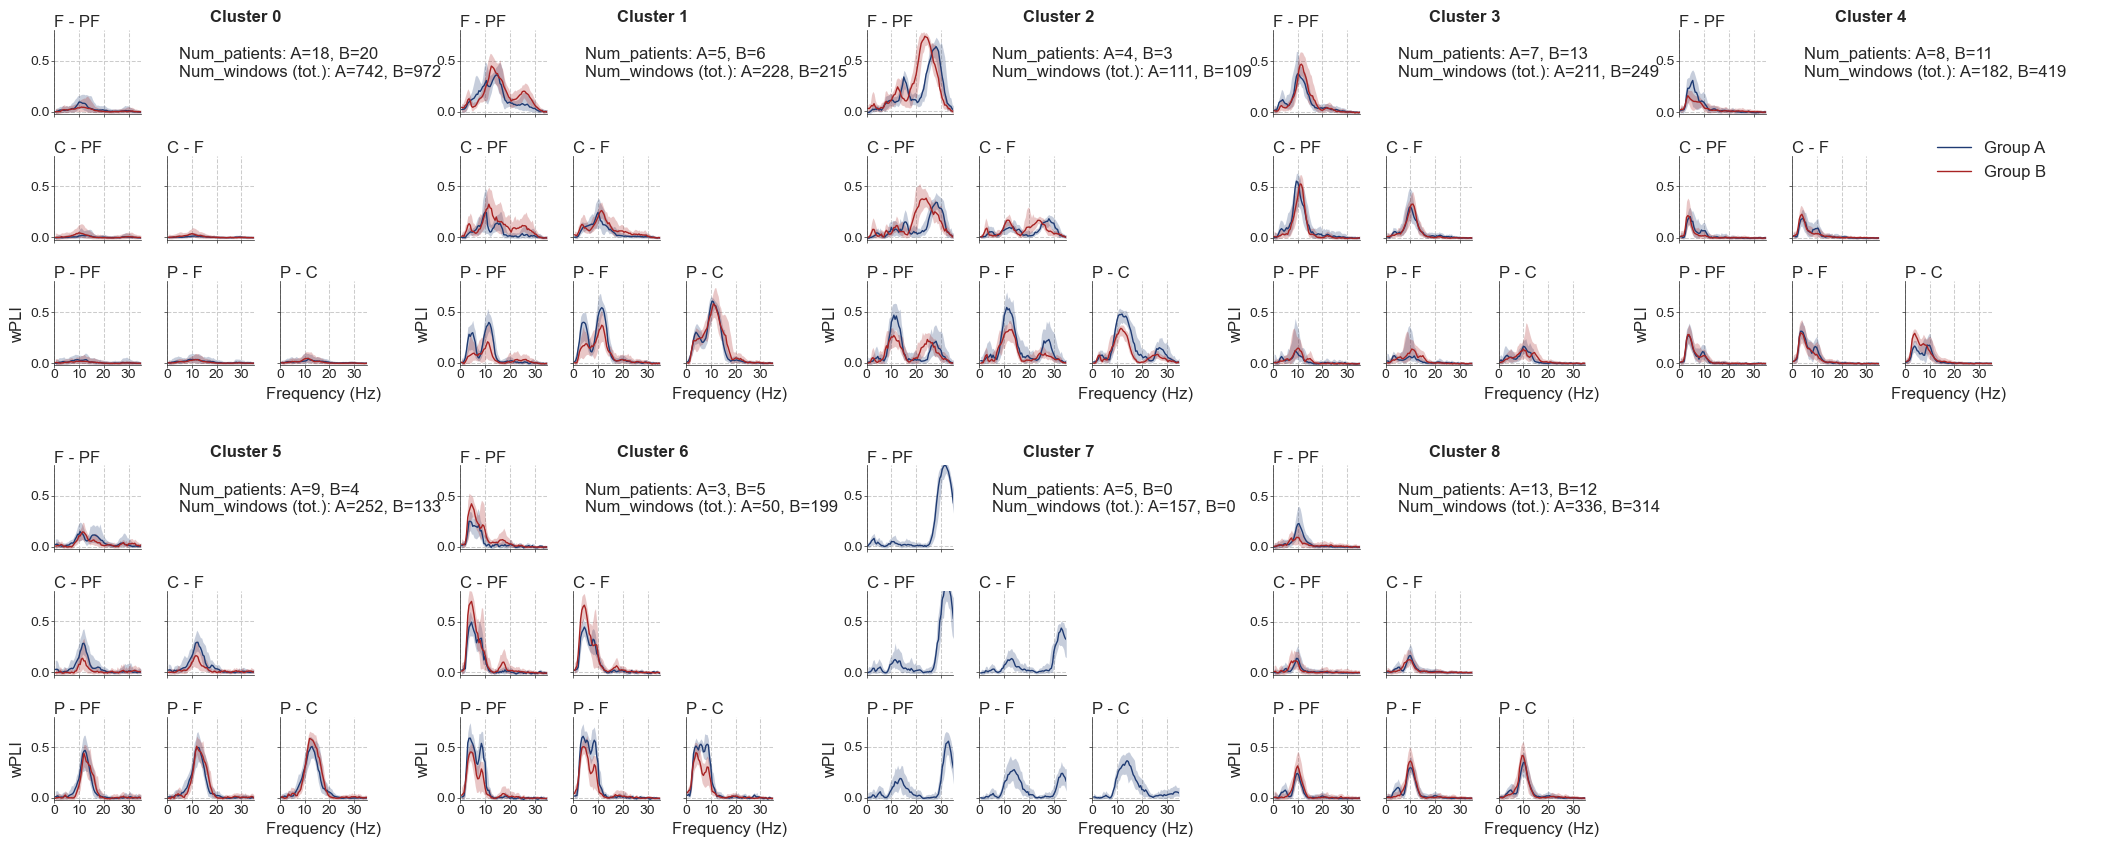

In [ ]:
group_labels_expanded = np.repeat(
    df_patient_data['group_name'].values,
    df_patient_data['num_valid_windows'].values
)

group_A_indices = (group_labels_expanded == 'Group A')
group_B_indices = (group_labels_expanded == 'Group B')


rows = 2
cols = int(np.ceil(num_clusters/2))
fig = plt.figure(figsize=(5*cols, 10))
gs = GridSpec(rows, cols, figure=fig, hspace=0.3, wspace=0.3)

for idx, cluster_label in enumerate(uniq_cluster_labels):
    row, col = divmod(idx, cols) # calculate the row and column index for the current cluster label

    # Get the corresponding grid axis
    ax = fig.add_subplot(gs[row, col])
    # remove the axis
    ax.axis('off')

    group_cluster_active_num_windows = {}
    group_cluster_active_patients = {}
    for group_name, group_df in df_patient_data.groupby('group_name'):
        
        group_cluster_active_num_windows[group_name] = 0
        group_cluster_active_patients[group_name] = 0
        
        for idx, row in group_df.iterrows():
            cluster_idx = row['cluster_labels'] == cluster_label
            num_cluster_activated_windows = len(np.where(cluster_idx)[0])
            
            group_cluster_active_num_windows[group_name] += num_cluster_activated_windows
            
            if num_cluster_activated_windows > 0:
                group_cluster_active_patients[group_name] += 1

    # Extract the data for the current cluster
    cluster_idx = cluster_labels_all == cluster_label
    cluster_data = wpli_concatenated_all[:, :, :, cluster_idx]

    # Split into group A and B
    group_A = cluster_data[:, :, :, group_A_indices[cluster_idx] == 1]
    group_B = cluster_data[:, :, :, group_B_indices[cluster_idx] == 1]

    # COmpute statistics for each group
    if sum(group_A.flatten()):
        cluster_median_A = np.median(group_A, axis=3)
        lower_iqr_A = np.percentile(group_A, 25, axis=3)
        upper_iqr_A = np.percentile(group_A, 75, axis=3)
    else:
        cluster_median_A = None
        lower_iqr_A = None
        upper_iqr_A = None

    if sum(group_B.flatten()):
        cluster_median_B = np.median(group_B, axis=3)
        lower_iqr_B = np.percentile(group_B, 25, axis=3)
        upper_iqr_B = np.percentile(group_B, 75, axis=3)
    else:
        cluster_median_B = None
        lower_iqr_B = None
        upper_iqr_B = None

    # Prepare the pli object
    dummy_pli = copy.deepcopy(pli)
    dummy_pli.freqs = freqs_low_res
    dummy_pli.region_names = region_names

    dummy_pli.conn_wpli_median_A = cluster_median_A
    dummy_pli.conn_wpli_median_B = cluster_median_B
    dummy_pli.conn_wpli_iqr_A = (lower_iqr_A, upper_iqr_A)
    dummy_pli.conn_wpli_iqr_B = (lower_iqr_B, upper_iqr_B)

    # Plot the wPLI frequency profile
    plot_wPLI_frequency_profile_separate_groups(dummy_pli, vmax=0.8, ax=ax, suptitle=f'Cluster {cluster_label}')

    # Add the number of patients and time points as text in the panel
    ax.text(0.4, 0.95, f'Num_patients: A={group_cluster_active_patients['Group A']}, B={group_cluster_active_patients['Group B']}\nNum_windows (tot.): A={group_cluster_active_num_windows['Group A']}, B={group_cluster_active_num_windows['Group B']}', 
            transform=ax.transAxes, ha='left', va='top', fontsize=12, bbox=dict(facecolor='white', alpha=0.7))
plt.show()

In [104]:
print(df_patient_data.loc[df_patient_data['Patient_Label'] == 'CA-69', 'cluster_labels'].tolist()) #group_name

[array([3, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 0, 0, 0, 8, 8, 8, 8, 8, 0, 0,
       8, 8, 8, 8, 8, 8, 8, 0, 0, 8, 0, 8, 8, 0, 3, 3, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])]


### The dwell time for each cluster 


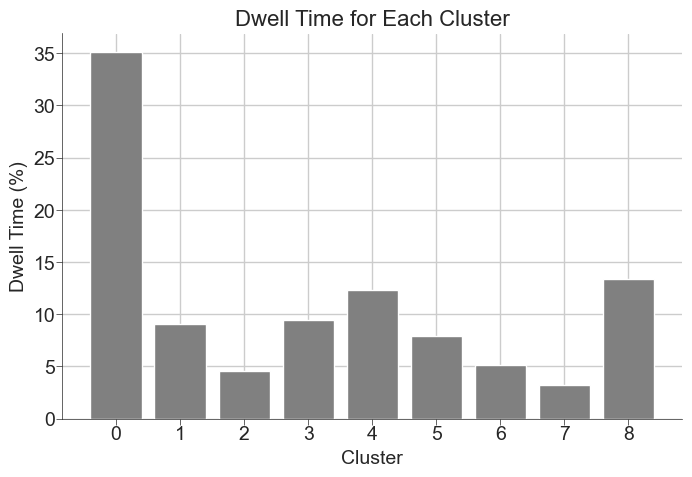

In [105]:
dwell_times = np.zeros(num_clusters)
for idx , cl in enumerate(uniq_cluster_labels):
    dwell_times[idx] = np.sum(cluster_labels == cl)/len(cluster_labels) * 100

# Plot the dwell times
fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(range(num_clusters), dwell_times, color='Gray')
ax.set_xticks(range(num_clusters))
ax.set_xticklabels(uniq_cluster_labels)
ax.set_xlabel("Cluster", fontsize=14)
ax.set_ylabel("Dwell Time (%)", fontsize=14)
ax.set_title("Dwell Time for Each Cluster", fontsize=16)
ax.tick_params(labelsize=14, length=4)
ax.grid()
plt.show()

### Calculate the transition matrix

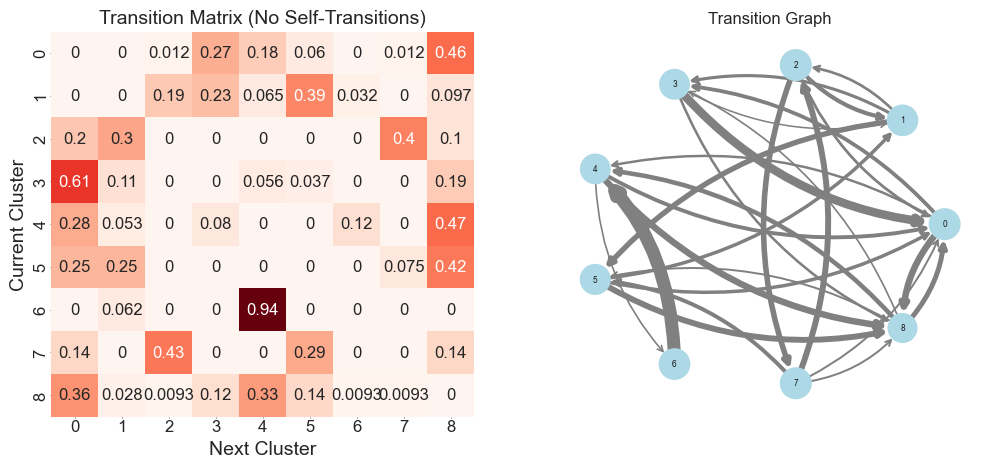

In [106]:
# NOTE: We can extend this section to use subject‐level weights (e.g., IPWs) for all calculations

def filter_short_dwell(mapped_sequence, min_dwell=2):
    """
    Filters out state transitions that last for fewer than min_dwell consecutive time points.
    
    Parameters:
      mapped_sequence (list): The list of mapped state indices for a patient.
      min_dwell (int): Minimum number of consecutive points required to consider a state as valid.
      
    Returns:
      list: The filtered state sequence.
    """
    if not mapped_sequence:
        return mapped_sequence

    # Group consecutive identical states
    filtered_sequence = []
    current_state = mapped_sequence[0]
    count = 1

    for state in mapped_sequence[1:]:
        if state == current_state:
            count += 1
        else:
            # For state 0, check the dwell time.
            if current_state == 0:
                if count >= min_dwell:
                    filtered_sequence.extend([current_state] * count)
                # If too short, we skip appending state 0
            else:
                # For all other states, keep the group as is.
                filtered_sequence.extend([current_state] * count)
            # Update to the new state.
            current_state = state
            count = 1
    # Handle the final group:
    if current_state == 0:
        if count >= min_dwell:
            filtered_sequence.extend([current_state] * count)
    else:
        filtered_sequence.extend([current_state] * count)

    return filtered_sequence

min_dwell = 2

# Create a mapping of old cluster labels to new index-based labels
cluster_label_map = {old_label: idx for idx, old_label in enumerate(uniq_cluster_labels)}

transition_matrix_raw = np.zeros((num_clusters, num_clusters))

# Iterate over each patient's cluster labels
for sequence in df_patient_data['cluster_labels']:

    sequence = sequence[sequence != -1]
    mapped_sequence = [cluster_label_map[label] for label in sequence]
    filtered_sequence = filter_short_dwell(mapped_sequence, min_dwell=min_dwell)
    
    for i in range(len(filtered_sequence)-1):
        transition_matrix_raw[filtered_sequence[i], filtered_sequence[i + 1]] += 1

# Normalize the transition matrix
transition_matrix = transition_matrix_raw / np.sum(transition_matrix_raw, axis=1, keepdims=True)
self_transitions = np.diag(transition_matrix)

# Make the self-transitions zero
transition_matrix_no_self_transitions = copy.deepcopy(transition_matrix)
np.fill_diagonal(transition_matrix_no_self_transitions, 0)

# renormalize the transition matrix after removing self-transitions 
transition_matrix_no_self_transitions = transition_matrix_no_self_transitions / np.sum(transition_matrix_no_self_transitions, axis=1, keepdims=True)



# Plot the transition matrix and the graph in a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(transition_matrix_no_self_transitions, cmap='Reds', annot=True, annot_kws={"size": 12}, vmin=0, vmax=np.max(transition_matrix_no_self_transitions), cbar=False, ax = axes[0])
axes[0].set_title("Transition Matrix (No Self-Transitions)", fontsize=14)

axes[0].set_xticks(np.arange(num_clusters)+0.5) 
axes[0].set_xticklabels(uniq_cluster_labels)
axes[0].set_yticks(np.arange(num_clusters)+0.5) 
axes[0].set_yticklabels(uniq_cluster_labels)

axes[0].set_xlabel("Next Cluster", fontsize=14)
axes[0].set_ylabel("Current Cluster", fontsize=14)
axes[0].tick_params(axis='both', which='major', labelsize=12)

# Plot the transition graph
if MERGE_CLUSTERS:
    node_labels = {0:1, 1:2, 2:3, 3:'M1', 4:'M2', 5:'M3'}
else:
    node_labels = None

plot_transition_graph(transition_matrix_no_self_transitions, node_weight=self_transitions, threshold=0.1, node_labels=node_labels, node_scale=500, edge_scale=10, ax=axes[1])
axes[1].set_title("Transition Graph", fontsize=12)
plt.show()

#### IPW‐Adjusted Dwell‐Times and Transition Matrices by Group

In [107]:
def compute_dwell_times(df_patient_data,
                        uniq_cluster_labels,
                        weight_col=None):
    """
    Computes (possibly weighted) dwell times (%) for each state in each group.

    Parameters:
      df_patient_data (pd.DataFrame): DataFrame with columns 'group_name' and 'cluster_labels'
                                      (where 'cluster_labels' for each patient is an array-like object).
      uniq_cluster_labels (list or array): List of unique cluster labels.
      weight_col(str): Name of the DataFrame column containing per-subject weights (e.g. IPWs).
        If None or missing, all observations are treated with weight = 1 (i.e. unweighted).
      
    Returns:
      dwell_times_group (dict): Dictionary with keys as group names and values as arrays containing
                                the dwell time percentages for each state.
    
    """
    dwell_times_group = {}
    K = len(uniq_cluster_labels)
    
    for group_name, group_df in df_patient_data.groupby('group_name'):
        weighted_counts = np.zeros(K, dtype=float)
        total_weighted  = 0.0
        
        for _, row in group_df.iterrows():
            labels = np.asarray(row['cluster_labels'])
            # drop any negative labels
            labels = labels[labels != -1]
            if labels.size == 0:
                continue
            
            w = float(row[weight_col]) if (weight_col in row and row[weight_col] is not None) else 1.0
            
            # count occurrences of each cluster
            counts = np.bincount(labels, minlength=K)
            weighted_counts += w * counts
            total_weighted  += w * labels.size
        
        dwell_times_group[group_name] = (weighted_counts / total_weighted) * 100 if total_weighted > 0 else np.zeros(K)
        
    return dwell_times_group

def compute_transition_matrices(df_patient_data,
                                min_dwell,
                                num_clusters,
                                cluster_label_map,
                                weight_col=None):
    """
    Computes raw (possibly weighted) transition count matrices per group.

    Parameters:
      df (pd.DataFrame): DataFrame containing at least 'group_name' and 'cluster_labels' columns.
      min_dwell (int): Minimum dwell time for filtering.
      num_clusters (int): Total number of clusters/states.
      cluster_label_map (dict): Mapping from original labels to integer indices.
      weight_col(str): Name of the DataFrame column containing per-subject weights (e.g. IPWs).
        If None or missing, all observations are treated with weight = 1 (i.e. unweighted).

    Returns:
      dict: Dictionary with keys as group names and values as (num_clusters x num_clusters) count matrices.
    """

    transition_raw = {}
    K = num_clusters
    
    for group_name, group_df in df_patient_data.groupby('group_name'):
        W = np.zeros((K, K), dtype=float)
        
        for _, row in group_df.iterrows():
            seq = np.asarray(row['cluster_labels'])
            seq = seq[seq != -1]
            mapped = [cluster_label_map[l] for l in seq]
            filtered = filter_short_dwell(mapped, min_dwell=min_dwell)
            
            w = float(row[weight_col]) if (weight_col in row and weight_col) else 1.0
            for i in range(len(filtered) - 1):
                W[filtered[i], filtered[i+1]] += w
        
        transition_raw[group_name] = W
        
    return transition_raw

def compute_normalized_matrices(transition_matrix_group_raw):
    """
    Computes normalized transition matrices and related matrices from the raw count matrices.
    
    Parameters:
      transition_matrix_group_raw (dict): Dictionary with keys as group names and values as (num_clusters x num_clusters)
                                          raw transition count matrices.
      num_clusters (int): Total number of clusters (states).
      
    Returns:
      transition_matrix_group (dict): For each group, the row-normalized transition matrix (each row sums to 1).
      self_transitions (dict): For each group, a 1-D array with the diagonal elements (self-transitions).
      transition_matrix_no_self_transitions_group (dict): For each group, a transition matrix where
                                                          self-transitions are removed (set to zero)
                                                          and each row is renormalized.
    """
    transition_matrix_group = {}
    self_transitions = {}
    no_self_norm   = {}
    
    for group_name, raw in transition_matrix_group_raw.items():
        # row‐normalize
        rowsum = raw.sum(axis=1, keepdims=True)
        P = np.divide(
            raw, 
            rowsum, 
            out=np.zeros_like(raw), 
            where=rowsum!=0
        )
        transition_matrix_group[group_name] = P
        
        # self-transitions
        self_transitions[group_name] = np.diag(P)
        
        # remove self and renormalize
        Q = P.copy()
        np.fill_diagonal(Q, 0)
        row_sums_no_self = Q.sum(axis=1, keepdims=True)
        Qn  = np.divide(
            Q, 
            row_sums_no_self, 
            out=np.zeros_like(Q), 
            where=row_sums_no_self!=0
        )
        no_self_norm[group_name] = Qn
        
    return transition_matrix_group, self_transitions, no_self_norm

cluster_label_map = {lbl: idx for idx, lbl in enumerate(uniq_cluster_labels)}

dwell_times_group = compute_dwell_times(
    df_patient_data, 
    uniq_cluster_labels,
    weight_col='ipw_stabilized'
)

transition_matrix_group_raw = compute_transition_matrices(
    df_patient_data, 
    min_dwell, 
    num_clusters,
    cluster_label_map,
    weight_col='ipw_stabilized'
)

transition_matrix_group, \
self_transitions, \
transition_matrix_no_self_transitions_group = (
    compute_normalized_matrices(transition_matrix_group_raw)
)

#### Comparing Dwell‐Time Distributions Between Group A and Group B

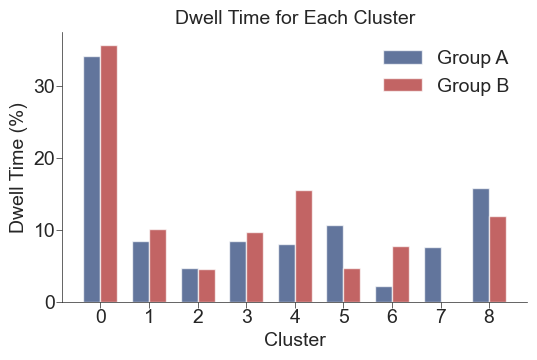

In [108]:
BLUE = "#1f3b73"  # Dark Blue
RED = "#a82323"  # Dark Red

fig, ax = plt.subplots(figsize=(6, 3.5))
bar_width = 0.35
bar_positions = np.arange(num_clusters)
ax.bar(bar_positions - bar_width/2, dwell_times_group["Group A"], bar_width, label="Group A", color=BLUE, alpha=0.7)
ax.bar(bar_positions + bar_width/2, dwell_times_group["Group B"], bar_width, label="Group B", color=RED, alpha=0.7)
ax.set_xlabel("Cluster", fontsize=14)
ax.set_ylabel("Dwell Time (%)", fontsize=14)
ax.set_title("Dwell Time for Each Cluster", fontsize=14)
ax.set_xticks(bar_positions, uniq_cluster_labels)
ax.tick_params(axis='both', which='major', labelsize=14, length=4)

ax.legend(fontsize=14)

#### Permutation Comparison of Observed Dwell‐Time Differences
Two approaches:

IPW‐Weighted Unstratified Permutation (adjusting for age via weights)

Unweighted Age‐Stratified Permutation (shuffling within age quintiles) 

In [55]:
# ─── Helper for stratified shuffles ──────────────────────────────────────────
def permute_within_age(df, strata_col='age_bin', group_col='group_name', seed=None):
    """
    Shuffle group labels only within each age_bin.
    """
    rng = np.random.default_rng(seed)
    dfp = df.copy()
    for b in dfp[strata_col].unique():
        idx = dfp.index[dfp[strata_col] == b]
        if len(idx) > 1:
            dfp.loc[idx, group_col] = rng.permutation(dfp.loc[idx, group_col].values)
    return dfp

# ─── Main permutation‐test function ─────────────────────────────────────────
def permutation_test_dwell(df,
                           uniq_cluster_labels,
                           compute_dwell_times,
                           weight_col=None,
                           num_permutations=5000,
                           stratified=True,
                           seed=None):
    """
    Permutation test on cluster‐wise dwell differences between Group A and B,
    optionally stratified by age and/or weighted.
    """
    rng = np.random.default_rng(seed)
    num_clusters = len(uniq_cluster_labels)
    df0 = df.copy()

    # if stratified, create age bins
    if stratified:
        df0['age_bin'], _ = pd.qcut(df0['Age'], q=5, labels=False, retbins=True)

    # observed dwell‐time diff
    dwell_obs = compute_dwell_times(df0, uniq_cluster_labels, weight_col=weight_col)
    obs_diff  = dwell_obs['Group A'] - dwell_obs['Group B']

    # permutation loop
    perm_diffs = np.zeros((num_permutations, num_clusters))
    for i in range(num_permutations):
        if stratified:
            dfp = permute_within_age(df0, seed=rng.integers(1e9))
        else:
            dfp = df0.copy()
            dfp['group_name'] = rng.permutation(dfp['group_name'].values)

        dwell_sim = compute_dwell_times(dfp, uniq_cluster_labels, weight_col=weight_col)
        perm_diffs[i] = dwell_sim['Group A'] - dwell_sim['Group B']

    # two‐sided p‐values
    p_vals = np.array([
        np.mean(np.abs(perm_diffs[:, j]) >= abs(obs_diff[j]))
        for j in range(num_clusters)
    ])

    dwell_stats_df = pd.DataFrame({
        'Cluster':    uniq_cluster_labels,
        'Obs_Diff':   obs_diff,
        'p_value':    p_vals
    })

    return dwell_stats_df, obs_diff, perm_diffs

# ─── Example usage ─────────────────────────────────────────────────────────
# res_age_strat, obs_diff, perm_diffs = permutation_test_dwell(
#     df_patient_data,
#     uniq_cluster_labels,
#     compute_dwell_times,
#     weight_col=None,
#     num_permutations=10000,
#     stratified=True,
#     seed=42
# )

res_ipw, obs_diff, perm_diffs = permutation_test_dwell(
    df_patient_data,
    uniq_cluster_labels,
    compute_dwell_times,
    weight_col='ipw_stabilized',
    num_permutations=10000,
    stratified=False,
    seed=42
)

# print("Age‐stratified Dwell‐Time Permutation Test (Unweighted):\n\n", res_age_strat)
print("IPW‐Weighted Dwell‐Time Permutation Test (Unstratified):\n", res_ipw)

IPW‐Weighted Dwell‐Time Permutation Test (Unstratified):
    Cluster  Obs_Diff  p_value
0        0  1.345323   0.8616
1        1 -1.093067   0.9228
2        2  7.589790   0.2382
3        3 -5.885557   0.5082
4        4  7.579379   0.0245
5        5 -5.280450   0.6930
6        6  0.183352   0.9423
7        7 -6.010327   0.2554
8        8  1.571557   0.7478


In [56]:
# your K‑vector of observed differences
d_obs = obs_diff                    # shape (K,)

# the N×K array of surrogate differences
d_surr = perm_diffs  

# center the surrogates (should be roughly zero‐mean if null is true)
d_surr_centered = d_surr - d_surr.mean(axis=0)

# estimate covariance of the surrogates
cov = np.cov(d_surr_centered, rowvar=False)      # shape (K,K)
cov_inv = np.linalg.pinv(cov)                    # use pseudo‐inverse if needed

# observed Mahalanobis distance
delta = d_obs - d_surr.mean(axis=0)              # center obs by same mean
m2_obs = float(delta.T.dot(cov_inv).dot(delta))

# surrogate Mahalanobis distances
m2_surr = np.einsum('ij,jk,ik->i', d_surr_centered, cov_inv, d_surr_centered)

# p‑value
p_value_m2 = np.mean(m2_surr >= m2_obs)

print(f"Observed Mahalanobis distance² = {m2_obs:.3f}")
print(f"Permutation p = {p_value_m2:.3f}")

# from scipy.stats import chi2

# # Fit df and scale, forcing location=0
# df_emp, loc, scale = chi2.fit(m2_surr, floc=0)

# # Now compute p‑value from that fitted distribution
# p_fitted = 1 - chi2.cdf(m2_obs, df_emp, loc=loc, scale=scale)

# print(f"Fitted χ² df={df_emp:.2f}, scale={scale:.2f}, p‑value={p_fitted:.3e}")


Observed Mahalanobis distance² = 5.445
Permutation p = 0.793


#### Comparing Transition Probability Matrices Between Group A and Group B 

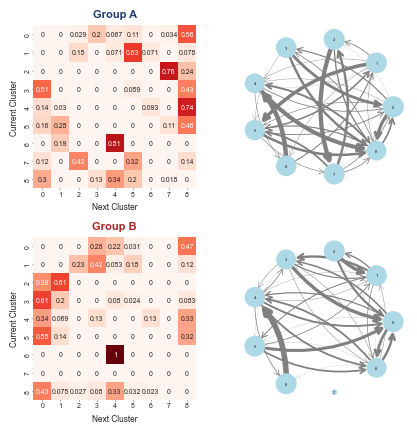

In [110]:
reorder_states = False

if reorder_states and ('activation_order_indices' in globals()):
    curr_state_order = activation_order_indices

# Plot the transition matrices 

plot_width = 350
plot_height = 350

# fig, axes = plt.subplots(2, 2, figsize=(10, 10), width_ratios=[1, 1])
fig, axes = plt.subplots(2, 2, figsize=(plot_width/72, plot_height/72), width_ratios=[1, 1])
for idx, group_name in enumerate(["Group A", "Group B"]):
    
    # replace nans with zeros
    transition_matrix = np.nan_to_num(transition_matrix_no_self_transitions_group[group_name], nan=0.1)

    # Conditionally reorder the matrix and corresponding labels/weights
    if 'curr_state_order' in globals():
        transition_matrix_ordered = transition_matrix[np.ix_(curr_state_order, curr_state_order)]
        ordered_labels = [uniq_cluster_labels[i] for i in curr_state_order]
        node_weight_ordered = np.array(self_transitions[group_name])[curr_state_order]
    else:
        transition_matrix_ordered = transition_matrix
        ordered_labels = uniq_cluster_labels
        node_weight_ordered = self_transitions[group_name]

    heatmap_ax = axes[idx, 0]
    sns.heatmap(transition_matrix_ordered, 
                annot=True, 
                annot_kws={"size": 5}, 
                cbar=False, 
                vmin=0, 
                vmax=1, 
                cmap='Reds',
                square=True, 
                ax=heatmap_ax)
    heatmap_ax.set_title(f"{group_name}", fontsize=8, fontweight='bold', color=BLUE if group_name == "Group A" else RED)
    
    heatmap_ax.set_xticks(np.arange(num_clusters)+0.5) 
    heatmap_ax.set_xticklabels(ordered_labels)
    heatmap_ax.set_yticks(np.arange(num_clusters)+0.5) 
    heatmap_ax.set_yticklabels(ordered_labels)

    heatmap_ax.set_xlabel("Next Cluster", fontsize=6)
    heatmap_ax.set_ylabel("Current Cluster", fontsize=6)
    heatmap_ax.tick_params(axis='both', labelsize=5)

    if 'curr_state_order' in globals():
        node_labels = {i: ordered_labels[i] for i in range(num_clusters)}
    else:
        node_labels = None
    plot_transition_graph(transition_matrix_ordered, 
                          node_weight=self_transitions[group_name], 
                          threshold=0, 
                          node_labels=node_labels,
                          node_scale=200, 
                          node_fontsize=3,
                          edge_scale=4,
                          layout='circular',
                          ax=axes[idx, 1])
plt.tick_params(axis='both', which='major', labelsize=5)
# plt.tight_layout()
plt.subplots_adjust(hspace=0.3, wspace=0.25)

# Save the figure
main_dir = 'D:/Anesthesia_Research_Fellow/analysis_results'
filename = 'Transition_probab_matrices'

if USE_IPW:
    filename += '_IPW'
file_path = os.path.join(main_dir, filename + '.pdf')

plt.savefig(file_path, format='pdf', dpi=300)

plt.show()

#### Chi–Square Test Comparing Transition Probability Matrices Between Group A and Group B


Overall chi-square test (all non-self transitions): chi2 = 5.783

Permutation test (n=10000): p-value = 0.054


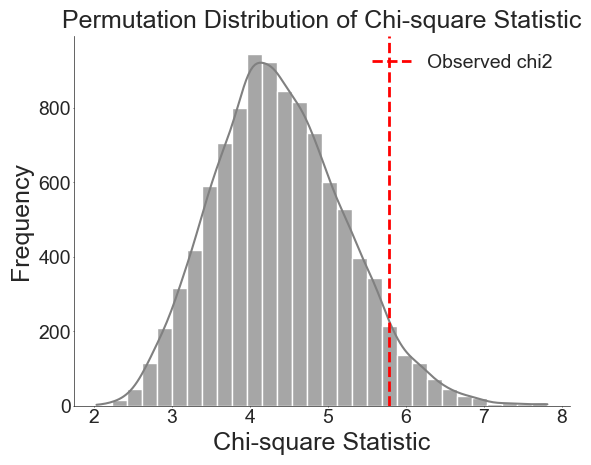

In [111]:
from scipy.stats import chi2_contingency

# --- Function to Build Overall Contingency Table ---
def build_overall_contingency(tmat, num_clusters):
    """
    Constructs an overall 2 x n contingency table (n = number of non-self transitions) 
    where each column corresponds to one (i,j) pair (with i != j).
    """
    overall_transitions = []
    for i in range(num_clusters):
        for j in range(num_clusters):
            if i != j:
                overall_transitions.append([tmat['Group A'][i, j],
                                            tmat['Group B'][i, j]])
    overall_contingency = np.array(overall_transitions).T
    # Filter out columns with total count zero.
    col_totals = overall_contingency.sum(axis=0)
    overall_contingency = overall_contingency[:, col_totals > 0]
    return overall_contingency


# Build an overall contingency table for all non-self transitions.
# Each column represents one unique (i, j) pair with i != j.

transition_matrix = compute_transition_matrices(
        df_patient_data, 
        min_dwell, 
        num_clusters, 
        cluster_label_map,
        weight_col='ipw_stabilized'
)

_, _, transition_matrix_norm = compute_normalized_matrices(transition_matrix)
# overall_contingency = build_overall_contingency(transition_matrix, num_clusters)

overall_contingency = build_overall_contingency(transition_matrix_norm, num_clusters)

chi2_overall, p_overall, dof_overall, expected_overall = chi2_contingency(overall_contingency)
print(f"\nOverall chi-square test (all non-self transitions): chi2 = {chi2_overall:.3f}") # , p-value = {p_overall:.1e}

# Difference in individual transition probabilties
obs_diff = {}  # {(i,j): diff_P = P_A - P_B}
for i in range(num_clusters):
    for j in range(num_clusters):
        if i == j:
            continue
        obs_diff[(i, j)] = (transition_matrix_norm['Group A'][i, j] -
                            transition_matrix_norm['Group B'][i, j])


# --- Permutation Test ---
N_PERM = 10000  
perm_chi2_values = []
perm_diffs = {k: [] for k in obs_diff.keys()}

for _ in range(N_PERM):
    # Shuffle group labels among patients
    df_perm = df_patient_data.copy()
    df_perm['group_name'] = np.random.permutation(df_perm['group_name'].values)
    
    # Compute transition matrices for permuted data
    perm_transition_matrix = compute_transition_matrices(
        df_perm, 
        min_dwell, 
        num_clusters, 
        cluster_label_map,
        weight_col='ipw_stabilized'
    )

    _, _, perm_transition_matrix_norm = compute_normalized_matrices(perm_transition_matrix)
    
    perm_overall_contingency = build_overall_contingency(perm_transition_matrix_norm, num_clusters)
    
    # Only compute if we have a valid contingency table
    if perm_overall_contingency.shape[1] > 0:
        try:
            chi2_perm, _, _, _ = chi2_contingency(perm_overall_contingency)
            perm_chi2_values.append(chi2_perm)
        except Exception as e:
            # In case any error arises (e.g., due to filtering), skip this permutation.
            continue

    # Difference in indiv. transition probabilities
    for (i, j) in perm_diffs.keys():
        diff = perm_transition_matrix_norm["Group A"][i, j] - perm_transition_matrix_norm["Group B"][i, j]
        perm_diffs[(i, j)].append(diff)

perm_chi2_values = np.array(perm_chi2_values)
# Compute a two-sided p-value: proportion of permuted chi2 values >= observed chi2
p_value_perm = np.mean(perm_chi2_values >= chi2_overall)
print(f"\nPermutation test (n={N_PERM}): p-value = {p_value_perm:.3f}")


# convert lists→arrays once
perm_diffs = {k: np.asarray(v) for k, v in perm_diffs.items()}

indiv_transition_p_values = {
    k: np.mean(np.abs(v) >= abs(obs_diff[k]))      # two‑sided
    for k, v in perm_diffs.items()
}


# ------------------------------------------------------------------
# BOOTSTRAP CIs – one CI per group, per transition
# ------------------------------------------------------------------
N_BOOT = 1_000  # number of bootstrap replicates

# Prepare containers
boot_prob = {
    "Group A": { (i, j): [] for i in range(num_clusters) for j in range(num_clusters) if i != j },
    "Group B": { (i, j): [] for i in range(num_clusters) for j in range(num_clusters) if i != j },
}

for _ in range(N_BOOT):
    # Within‑group resampling (stratified bootstrap)
    df_boot = (
        df_patient_data
        .groupby("group_name", group_keys=False)
        .sample(frac=1.0, replace=True)
        .reset_index(drop=True)
    )

    # Recompute transition probabilities on the bootstrap sample
    boot_tmat = compute_transition_matrices(
        df_boot, min_dwell, num_clusters, cluster_label_map
    )
    _, _, boot_tmat_norm = compute_normalized_matrices(boot_tmat)  # returns dict per group

    # Store probabilities for every non‑self transition
    for (i, j) in boot_prob["Group A"].keys():
        boot_prob["Group A"][(i, j)].append(boot_tmat_norm["Group A"][i, j])
        boot_prob["Group B"][(i, j)].append(boot_tmat_norm["Group B"][i, j])

# Convert lists → arrays and compute 95 % CIs
ci95 = {
    grp: {
        k: (np.percentile(v, 2.5), np.percentile(v, 97.5))
        for k, v in boot_prob[grp].items()
    }
    for grp in ["Group A", "Group B"]
}

# --- (Optional) Visualize the Permutation Distribution ---
sns.histplot(perm_chi2_values, kde=True, bins=30, alpha=0.7, color='Gray', edgecolor=None)
plt.axvline(chi2_overall, color='red', linestyle='dashed', linewidth=2, label='Observed chi2')
plt.xlabel("Chi-square Statistic", fontsize=18)
plt.ylabel("Frequency", fontsize=18)
plt.title("Permutation Distribution of Chi-square Statistic", fontsize=18)
plt.tick_params(labelsize=14)
plt.legend(fontsize=14)
plt.show()

##### Generate a table containing the transition probabilities and their 95% confidence intervals

In [112]:
# 1. Build combined table
combined_tbl = pd.DataFrame(index=np.arange(num_clusters),
                            columns=np.arange(num_clusters),
                            dtype=str)

for i in range(num_clusters):
    for j in range(num_clusters):
        if i == j:
            combined_tbl.iat[i, j] = ''                 # leave diagonal blank
            continue

        # Pull point estimates
        pA = transition_matrix_norm['Group A'][i, j]
        pB = transition_matrix_norm['Group B'][i, j]

        # Pull CIs
        (loA, hiA) = ci95['Group A'][(i, j)]
        (loB, hiB) = ci95['Group B'][(i, j)]

        # Decide if an asterisk is needed (p < 0.05)
        star_A = star_B = ''
        if indiv_transition_p_values[(i, j)] < 0.05:
            if pA > pB:
                star_A = ' *'
            elif pB > pA:
                star_B = ' *'

        # Two‑line string
        combined_tbl.iat[i, j] = (
            f"A: {pA:.3f}{star_A} [{loA:.3f}, {hiA:.3f}]\n"
            f"B: {pB:.3f}{star_B} [{loB:.3f}, {hiB:.3f}]"
        )

# 2. Write to Excel with auto‑sized, wrapped cells
with pd.ExcelWriter('transition_bootstrap_ci.xlsx', engine='xlsxwriter') as writer:
    combined_tbl.to_excel(writer, sheet_name='Transition CIs', index_label='From \\ To')

    workbook  = writer.book
    worksheet = writer.sheets['Transition CIs']

    # Format: wrap text, centre both ways
    wrap_center_fmt = workbook.add_format({
        'text_wrap': True,
        'align':     'center',
        'valign':    'vcenter',
        'font_name': 'Calibri',   # match Excel default
        'font_size': 11
    })
    col_widths = []  # gather widths so we can pick an average later

    def longest_line_len(cell):
        if not isinstance(cell, str) or cell == '':
            return 0
        return max(len(line) for line in cell.split('\n'))

    for col_idx, col in enumerate(combined_tbl.columns, start=1):  # +1 skips index col
        max_len = combined_tbl[col].map(longest_line_len).max()
        width = max_len + 1           # add a bit of padding
        col_widths.append(width)
        worksheet.set_column(col_idx, col_idx, width, wrap_center_fmt)

    # -------------------------------------------
    # Set a “square” row height based on the mean column width
    # -------------------------------------------
    square_height = int(np.mean(col_widths) * 1.1)   # tweak 1.1 as desired

    for row_idx in range(1, num_clusters + 1):       # +1 skips header row
        worksheet.set_row(row_idx, square_height, wrap_center_fmt)

print("Excel file saved → transition_bootstrap_ci.xlsx with centred, square‑ish cells.")

Excel file saved → transition_bootstrap_ci.xlsx with centred, square‑ish cells.


##### Test if arraival probability at each state is differnet between Groups A and B

In [111]:
# ------------------------------------------------------------
# ARRIVAL‑PROBABILITY DIFFERENCES FOR *ALL* DESTINATION STATES
# ------------------------------------------------------------
n_states = num_clusters

# ---------- 1. observed arrival probabilities ----------
arrive_obs = {
    grp: np.array([
        transition_matrix_norm[grp][:, j].sum() - transition_matrix_norm[grp][j, j]
        for j in range(n_states)
    ])
    for grp in ['Group A', 'Group B']
}

delta_obs = arrive_obs['Group A'] - arrive_obs['Group B']   # ΔP for each j

# ---------- 2. permutation loop ----------
N_PERM = 10_000
delta_perm = np.zeros((N_PERM, n_states))

for p in range(N_PERM):
    df_perm = df_patient_data.copy()
    df_perm['group_name'] = np.random.permutation(df_perm['group_name'])

    perm_tmat = compute_transition_matrices(
        df_perm, 
        min_dwell,
        n_states, 
        cluster_label_map,
        weight_col='ipw_stabilized'
    )
    _, _, perm_norm = compute_normalized_matrices(perm_tmat)

    pA = np.array([
        perm_norm['Group A'][:, j].sum() - perm_norm['Group A'][j, j]
        for j in range(n_states)
    ])
    pB = np.array([
        perm_norm['Group B'][:, j].sum() - perm_norm['Group B'][j, j]
        for j in range(n_states)
    ])
    delta_perm[p, :] = pA - pB

# ---------- 3. p‑values ----------
p_values = np.mean(np.abs(delta_perm) >= np.abs(delta_obs), axis=0)

# ---------- 4. (optional) FDR control ----------
import statsmodels.stats.multitest as smm
_, q_values, _, _ = smm.multipletests(p_values, method='fdr_bh')

# ---------- 5. tabulate results ----------
import pandas as pd

results = pd.DataFrame({
    'State':        np.arange(n_states),
    'Arrival_A':    arrive_obs['Group A'],
    'Arrival_B':    arrive_obs['Group B'],
    'Δ (A‑B)':      delta_obs,
    'p_perm':       p_values,
    'q_FDR':        q_values        # drop if you don’t need FDR
}).round(4)

print(results.to_string(index=False))


 State  Arrival_A  Arrival_B  Δ (A‑B)  p_perm  q_FDR
     0     1.2318     2.3230  -1.0912  0.0592 0.1431
     1     0.4960     1.0888  -0.5928  0.3311 0.3725
     2     0.5945     0.2574   0.3370  0.3191 0.3725
     3     0.3385     0.9102  -0.5717  0.1524 0.2743
     4     1.2910     1.6823  -0.3913  0.2108 0.3162
     5     1.3271     0.2660   1.0611  0.0263 0.1184
     6     0.1639     0.1544   0.0095  0.9446 0.9446
     7     0.9215     0.0000   0.9215  0.0158 0.1184
     8     2.6359     1.3179   1.3180  0.0636 0.1431


#### Age‐Stratified Permutation Test (Alternative to IPW) to Control for the Primary Age Confound

This non-parametric approach holds Age fixed in quintile strata—addressing the largest ASD—by permuting treatment labels only within each age bin.

Note: If you stratify on many confounders simultaneously (e.g. Age + ASA + MAC), strata become very small (or singleton), yielding few valid shuffles and a dramatic loss of test power.

In [ ]:
# 1) Bin ages into strata—e.g. quintiles, or whatever makes sense given your sample size:
df_patient_data['age_bin'], bin_edges = pd.qcut(df_patient_data['Age'], 
                                                q=5, 
                                                labels=False, 
                                                retbins=True)

# 2) In each permutation, shuffle group_name *within* each age_bin:
def permute_within_strata(df, strata_col='age_bin', group_col='group_name'):
    dfp = df.copy()

    for bin_ in dfp[strata_col].unique():
        mask = dfp[strata_col] == bin_
        # shuffle only these rows’ group labels
        dfp.loc[mask, group_col] = np.random.permutation(dfp.loc[mask, group_col].values)
    
    return dfp

n_perm = 10000
perm_chi2_values = []

for _ in range(n_perm):   
    df_perm = permute_within_strata(df_patient_data, 'age_bin', 'group_name')

    perm_transition_matrix = compute_transition_matrices(
        df_perm, 
        min_dwell, 
        num_clusters, 
        cluster_label_map,
    )

    _, _, perm_transition_matrix_norm = compute_normalized_matrices(perm_transition_matrix)
    perm_overall_contingency = build_overall_contingency(perm_transition_matrix_norm, num_clusters)

    if perm_overall_contingency.shape[1] > 0:
        chi2_perm, _, _, _ = chi2_contingency(perm_overall_contingency)
        perm_chi2_values.append(chi2_perm)


# Calculate p‐value as before
p_value_perm = np.mean(np.array(perm_chi2_values) >= chi2_overall)
print(f"\nPermutation test (n={n_perm}): p-value = {p_value_perm:.3f}")

# --- (Optional) Visualize the Permutation Distribution ---
sns.histplot(perm_chi2_values, kde=True, bins=30, alpha=0.7, color='Gray', edgecolor=None)
plt.axvline(chi2_overall, color='red', linestyle='dashed', linewidth=2, label='Observed chi2')
plt.xlabel("Chi-square Statistic", fontsize=18)
plt.ylabel("Frequency", fontsize=18)
plt.title("Permutation Distribution of Chi-square Statistic", fontsize=18)
plt.tick_params(labelsize=14)
plt.legend(fontsize=14)
plt.show()

In [ ]:
bin_edges

In [ ]:
print(df_patient_data['age_bin'].value_counts().sort_index())

In [ ]:
n_to_plot = 10
fig, axes = plt.subplots(2, 5, figsize=(15, 5), sharex=True, sharey=True)
axes = axes.flatten()

# precompute your age‐bins for consistent histograms
all_ages = df_patient_data['Age'].values
bin_width = 10
bins = np.arange(all_ages.min(), all_ages.max() + bin_width, bin_width)

for i in range(n_to_plot):
    # 1) stratified permute
    dfp = permute_within_strata(df_patient_data, 'age_bin', 'group_name')
    # dfp = df_patient_data.copy()
    # dfp['group_name'] = np.random.permutation(dfp['group_name'].values)

    # 2) compute permuted chi‑square
    tm_raw = compute_transition_matrices(
        dfp, 
        min_dwell, 
        num_clusters, 
        cluster_label_map,
        weight_col=None
    )
    _, _, tm_norm = compute_normalized_matrices(tm_raw)
    cont = build_overall_contingency(tm_norm, num_clusters)
    if cont.shape[1] > 0:
        chi2_perm, _, _, _ = chi2_contingency(cont)
        chi2_text = f"χ² = {chi2_perm:.2f}"
    else:
        chi2_text = "χ² = N/A"

    # 3) plot ages
    ages_A = dfp.loc[dfp['group_name']=='Group A', 'Age']
    ages_B = dfp.loc[dfp['group_name']=='Group B', 'Age']

    # Compute medians
    med_A = ages_A.median()
    med_B = ages_B.median()


    ax = axes[i]
    ax.hist(ages_A, bins=bins, alpha=0.5, label='Group A', color=BLUE)
    ax.hist(ages_B, bins=bins, alpha=0.5, label='Group B', color=RED)
    ax.set_title(f'Perm #{i+1}', fontsize=14)

    # Annotate medians
    ax.text(0.95, 0.80,
            f'Med A = {med_A:.1f}\nMed B = {med_B:.1f}',
            transform=ax.transAxes,
            ha='right', va='top',
            fontsize=10,
            bbox=dict(boxstyle="round,pad=0.3", alpha=0.3))
    
    # 4) annotate chi‑square
    ax.text(0.85, 0.95, chi2_text,
            transform=ax.transAxes,
            ha='right', va='top',
            fontsize=10,
            bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.7))
    
    if i == 0:
        ax.legend(fontsize=10)
    ax.tick_params(labelsize=12, length=4)

# label axes
for ax in axes[0::5]:
    ax.set_ylabel('Count', fontsize=14)
for ax in axes[-5:]:
    ax.set_xlabel('Age', fontsize=14)

plt.tight_layout()
plt.show()

#### Temporal progression of the distribution of the participants across the connectivity states

In [ ]:
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter1d

# Constants for alignment types
NORMALIZED_TIME = "normalized_time"
ALIGN_TO_DRUG_INFUSION = "regular_time_align_to_drug_infusion_start"
ALIGN_TO_EXTUBATION = "regular_time_align_to_extubation"

# User-defined selection
ALIGNMENT_TYPE = ALIGN_TO_DRUG_INFUSION  # Change this to switch between alignments

def interpolate_cluster_sequence(cluster_sequence, num_time_points):
    """Interpolates a cluster sequence to a fixed length time scale."""
    original_time = np.linspace(0, 1, len(cluster_sequence))
    target_time = np.linspace(0, 1, num_time_points)
    interp_func = interp1d(original_time, cluster_sequence, kind='nearest', bounds_error=False, fill_value='extrapolate')
    return interp_func(target_time).astype(int)

def align_sequences(df_patient_data, alignment_type):
    """Align cluster sequences based on the chosen method."""
    max_length = max(df_patient_data['cluster_labels'].apply(len))
    
    if alignment_type == NORMALIZED_TIME:
        df_patient_data['aligned_sequence'] = df_patient_data['cluster_labels'].apply(lambda x: interpolate_cluster_sequence(x, max_length))
    else:
        aligned_sequences = []
        for seq in df_patient_data['cluster_labels']:
            if alignment_type == ALIGN_TO_EXTUBATION:
                padded_seq = [np.nan] * (max_length - len(seq)) + list(seq)
            elif alignment_type == ALIGN_TO_DRUG_INFUSION:
                padded_seq = list(seq) + [np.nan] * (max_length - len(seq))
            aligned_sequences.append(padded_seq)
        df_patient_data['aligned_sequence'] = aligned_sequences
    
    return df_patient_data, max_length

def compute_center_of_mass(group_matrix, center_type="com"):
    """
    Computes the center of mass (weighted average time point) or maximum time point for a cluster.

    Parameters:
    - group_matrix (pd.DataFrame): A matrix where rows represent clusters and columns represent time points.
    - center_type (str): method for calculating the cluster centers ('com' for center of mass, 'max' for maximum).

    Returns:
    - cluster_center (dict): the calculated cluster centers
    """
    cluster_center = {}

    for cluster_id in group_matrix.index:
        values = group_matrix.loc[cluster_id].values
        time_points = np.arange(len(values))

        if center_type == 'com':
            # Compute center of mass (weighted average time point)
            center = np.sum(values * time_points) / np.sum(values) if np.sum(values) > 0 else np.inf
        elif center_type == 'max':
            center = time_points[np.argmax(values)]
        else:
            raise ValueError('Invalid center_type')

        cluster_center[cluster_id] = center

    return cluster_center

def compute_cluster_sorting_indices(cluster_center):

    sorted_indices = sorted(cluster_center.keys(), key=lambda k: cluster_center[k])

    return sorted_indices

def compute_pooled_cluster_activation_matrix(df_patient_data, max_length):
    """Computes a cluster occurrence matrix for all patients pooled together."""
    clusters = sorted(df_patient_data['cluster_labels'].explode().unique())
    clusters.remove(-1)

    pooled_matrix = pd.DataFrame(index=clusters, columns=range(max_length), data=0)
    pooled_patient_count = np.zeros(max_length)

    for seq in df_patient_data['aligned_sequence']:
        for t, cluster in enumerate(seq):
            if cluster in clusters:
                pooled_matrix.loc[cluster, t] += 1
                pooled_patient_count[t] += 1
    
    return pooled_matrix, pooled_patient_count

def compute_group_specific_cluster_activation_matrices(df_patient_data, max_length):
    """Computes cluster occurrence matrices for each group."""
    clusters = sorted(df_patient_data['cluster_labels'].explode().unique())
    clusters.remove(-1)

    group_matrices = {}
    patient_counts = {}
    
    for group_name, group_df in df_patient_data.groupby('group_name'):
        cluster_matrix = pd.DataFrame(index=clusters, columns=range(max_length), data=0)
        patient_count = np.zeros(max_length)

        for seq in group_df['aligned_sequence']:
            for t, cluster in enumerate(seq):
                if cluster in clusters:
                    cluster_matrix.loc[cluster, t] += 1
                    patient_count[t] += 1
                    
        group_matrices[group_name] = cluster_matrix
        patient_counts[group_name] = patient_count
    
    return group_matrices, patient_counts

def smooth_group_matrices(group_matrices, sigma=5):
    """
    Applies Gaussian smoothing to each row in the group matrices while preserving the DataFrame structure.

    Parameters:
    - group_matrices (dict of pd.DataFrame): Activation matrices for different groups.
    - sigma (float): Standard deviation for Gaussian kernel.

    Returns:
    - smoothed_matrices (dict of pd.DataFrame): Smoothed activation matrices with the same DataFrame structure.
    """
    smoothed_matrices = {}

    for group_name, matrix in group_matrices.items():
        smoothed_matrix = matrix.apply(lambda row: pd.Series(gaussian_filter1d(row.values.astype(float), sigma=sigma)), axis=1)
        smoothed_matrix.columns = matrix.columns  # Ensure column names are retained
        smoothed_matrices[group_name] = smoothed_matrix

    return smoothed_matrices

def plot_pooled_cluster_activation_matrix(pooled_matrix, activation_order_indices, pooled_patient_count, alignment_type, xtick_positions, xtick_labels, vmax=None):
    """Plots the heatmap for the pooled cluster occurrence matrix."""
    fig, axes = plt.subplots(2*3, 1, figsize=(8, 8), sharex=False, gridspec_kw={'height_ratios': [1, 1, 6, 1, 1, 6]})
    
    cbar_ax = fig.add_axes([0.94, 0.50, 0.015, 0.26])

    ax_top, heatmap_ax = axes[1], axes[2]
    axes[0].axis('off')
    for i in range(3,6):
        axes[i].axis('off')

    ax_top.set_title("All Patients Pooled", fontsize=18, color="black")
    
    if alignment_type != NORMALIZED_TIME:
        ax_top.fill_between(range(len(pooled_patient_count)), pooled_patient_count, color="gray", alpha=0.7)
        ax_top.set_xlim(0, len(pooled_patient_count))
        ax_top.set_ylim(0, max(pooled_patient_count) + 1)
        ax_top.set_yticks([1, max(patient_counts[group_name])])
        ax_top.set_ylabel("#Patients", fontsize=12)
        ax_top.tick_params(axis="x", which="both", bottom=False, labelbottom=False)
        ax_top.tick_params(axis="y", labelsize=10)
    else:
        ax_top.set_xticks([])
        ax_top.set_yticks([])
        ax_top.spines['left'].set_visible(False)
        ax_top.spines['bottom'].set_visible(False)
    
    if activation_order_indices is not None:
        sorted_pooled_matrix = pooled_matrix.loc[activation_order_indices]
        current_pooled_matrix = sorted_pooled_matrix
    else:
        current_pooled_matrix = pooled_matrix

    sns.heatmap(current_pooled_matrix, ax=heatmap_ax, vmin=0, vmax=vmax, xticklabels=10, yticklabels=True, cbar=True, cbar_ax=None if i == 1 else cbar_ax)
    heatmap_ax.set_xticks(xtick_positions)
    heatmap_ax.set_xticklabels(xtick_labels, rotation=35, va='top', ha='right')

    if activation_order_indices is not None:
        heatmap_ax.set_yticks(np.arange(0, pooled_matrix.shape[0]) + 0.5)
        heatmap_ax.set_yticklabels(activation_order_indices)
        
    heatmap_ax.set_ylabel("Clusters", fontsize=12)
    if ALIGNMENT_TYPE == NORMALIZED_TIME:
        xlabel = "Time (normalized)"
    else:    
        xlabel = "Time (minutes)"
    heatmap_ax.set_xlabel(xlabel, fontsize=12)
    heatmap_ax.tick_params(labelsize=12, length=4)

    # Configure the colorbar
    cbar = fig.colorbar(heatmap_ax.collections[0], cax=cbar_ax)
    cbar_ticks = cbar.get_ticks()
    cbar_ticklabels = [f">{vmax}" if tick == vmax else f"{int(tick)}" for tick in cbar_ticks]
    cbar.set_ticks(cbar_ticks)
    cbar.set_ticklabels(cbar_ticklabels)
    cbar.set_label("Number of Patients", fontsize=12)
    cbar.ax.tick_params(labelsize=12)

    plt.subplots_adjust(right=0.9, hspace=0.1) 
    plt.show()

def plot_group_specific_cluster_activation_matrices(group_matrices, activation_order_indices, patient_counts, alignment_type, xtick_positions, xtick_labels, vmax=None):
    """Plots heatmaps for the cluster occurrence matrices."""
    fig, axes = plt.subplots(len(group_matrices)*3, 1, figsize=(8, 8), sharex=True, gridspec_kw={'height_ratios': [1, 1, 6, 1, 1, 6]})
    
    cbar_ax = fig.add_axes([0.94, 0.50, 0.015, 0.26])
    
    for i, (group_name, cluster_matrix) in enumerate(group_matrices.items()):
        axes[i*3].axis('off')

        ax_top = axes[i*3+1]
        ax_top.set_title(f"{group_name}", fontsize=20, color=BLUE if group_name == 'Group A' else RED)
        if alignment_type != NORMALIZED_TIME:
            # Plot patient count bar plot
            ax_top.fill_between(range(len(patient_counts[group_name])), patient_counts[group_name], color="gray", alpha=0.7)
            ax_top.set_xlim(0, len(patient_counts[group_name]))   
            ax_top.set_ylim(0, max(patient_counts[group_name]+1))
            ax_top.set_yticks([1, max(patient_counts[group_name])])
            ax_top.set_ylabel("#Patients", fontsize=12)
            ax_top.tick_params(axis="x", which="both", bottom=False, labelbottom=False)
            ax_top.tick_params(axis="y", labelsize=10)
        else:
            ax_top.set_xticks([])  # Remove x-axis ticks
            ax_top.set_yticks([])  # Remove y-axis ticks
            ax_top.spines['left'].set_visible(False)  # Hide left spine
            ax_top.spines['bottom'].set_visible(False)  # Hide bottom spine

        # # Plot heatmap
        heatmap_ax = axes[i*3+2]
        if activation_order_indices is not None:
            sorted_group_matrix = cluster_matrix.loc[activation_order_indices]
            current_group_matrix = sorted_group_matrix
        else:
            current_group_matrix = cluster_matrix

        sns.heatmap(current_group_matrix, ax=heatmap_ax, cbar=(i == 0), vmin=0, vmax=vmax, 
                    xticklabels=10, yticklabels=True, cbar_ax=None if i == 1 else cbar_ax)

        heatmap_ax.set_xticks(xtick_positions)
        heatmap_ax.set_xticklabels(xtick_labels, rotation=35, va='top', ha='right')
        if activation_order_indices is not None:
            heatmap_ax.set_yticks(np.arange(0, pooled_matrix.shape[0]) + 0.5)
            heatmap_ax.set_yticklabels(activation_order_indices)
            
        heatmap_ax.set_ylabel("Clusters", fontsize=14)
        if ALIGNMENT_TYPE == NORMALIZED_TIME:
            xlabel = "Time (normalized)"
        else:    
            xlabel = "Time (minutes)"
        heatmap_ax.set_xlabel(xlabel if i == 1  else "", fontsize=14)
        heatmap_ax.tick_params(labelsize=14, length=4)

    # Configure the colorbar
    cbar = fig.colorbar(heatmap_ax.collections[0], cax=cbar_ax)
    cbar_ticks = cbar.get_ticks()
    cbar_ticklabels = [f">{vmax}" if tick == vmax else f"{int(tick)}" for tick in cbar_ticks]
    cbar.set_ticks(cbar_ticks)
    cbar.set_ticklabels(cbar_ticklabels)
    cbar.set_label("Number of Patients", fontsize=12)
    cbar.ax.tick_params(labelsize=12)

    plt.subplots_adjust(right=0.9, hspace=0.1) 
    plt.show()

def plot_cluster_time_courses(group_matrices, smoothed_group_matrices, activation_order_indices, cluster_centers_A, cluster_centers_B, xtick_positions, xtick_labels, sigma=5):
    """Plots time-course activity for selected clusters."""    

    _, axes = plt.subplots(len(group_matrices['Group A']), 1, figsize=(8, 12), sharex=True, sharey=False)
    for i, cluster_id in enumerate(group_matrices['Group A'].index):
        ax = axes[i]
        for group_name in group_matrices:
            cluster_activation_matrix = group_matrices[group_name]
            sm_cluster_activation_matrix = smoothed_group_matrices[group_name]

            if cluster_id in cluster_activation_matrix.index:
                curr_cluster_counts = cluster_activation_matrix.loc[activation_order_indices[i]].values.astype(float)
                smoothed_counts = sm_cluster_activation_matrix.loc[activation_order_indices[i]].values.astype(float)
                color = BLUE if group_name == 'Group A' else RED
                ax.fill_between(range(len(curr_cluster_counts)), curr_cluster_counts, color=color, alpha=0.5, label=f"{group_name}")
                ax.plot(range(len(curr_cluster_counts)), smoothed_counts, color=color, linewidth=2, alpha=0.8)
                # plot the center point of each cluster
                time_point = cluster_centers_A[activation_order_indices[i]] if group_name == 'Group A' else cluster_centers_B[activation_order_indices[i]]
                ax.plot([time_point, time_point], [0, ax.get_ylim()[1]], color=color, linewidth=3, alpha=0.8, label=f'{group_name} {center_type}')

        ax.set_xticks(xtick_positions)
        ax.set_xticklabels(xtick_labels, rotation=35, va='top', ha='right')
        ax.set_title(f"Cluster {activation_order_indices[i]}", fontsize=14, fontweight='bold', y=0.7)
        ax.set_ylabel("#Patients", fontsize=12)
        ax.tick_params(labelsize=14, length=4)
    
    axes[-1].set_xlabel("Time (minutes)", fontsize=14)
    axes[0].legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=12)
    plt.subplots_adjust(hspace=0.1)
    plt.show()  

def get_xtick_labels(alignment_type, max_length, step_size):
    """Generates x-axis tick positions and labels based on alignment type."""
    if alignment_type == NORMALIZED_TIME:
        positions = np.linspace(0, max_length, num=11)
        labels = [round(x, 1) for x in np.linspace(0, 1, num=11)]
        labels[-1], labels[0] = "Extubation -> 1", "Drug infusion start -> 0"
    else:
        step = int(900 / step_size)
        pre_drug_length = int(600 / step_size)
        if alignment_type == ALIGN_TO_DRUG_INFUSION:
            positions_pre_durg = [0, pre_drug_length]
            positions_post_drug = list(np.arange(pre_drug_length+step, max_length, step))
            positions = positions_pre_durg+positions_post_drug
            print(positions)
            # positions = np.arange(0, max_length, step)
            labels_pre_drug = ["-10", "Drug infusion start -> 0"]
            labels_post_drug = [str(int(((x-pre_drug_length) * step_size) / 60)) for x in positions_post_drug]
            labels = labels_pre_drug+labels_post_drug
            # labels = [str(int((x * step_size) / 60)) for x in positions]
            # labels[0] = "Drug infusion start -> 0"
        elif alignment_type == ALIGN_TO_EXTUBATION:
            positions = np.arange(max_length - 1, -1, -step)
            labels = [-int((max_length - x) * step_size / 60) for x in positions]
            labels[-1] = "Extubation -> 1"
    return positions, labels


df_patient_data, max_length = align_sequences(df_patient_data, ALIGNMENT_TYPE)
xtick_positions, xtick_labels = get_xtick_labels(ALIGNMENT_TYPE, max_length, step_size=pli.window_size * (1 - pli.overlap_ratio))
pooled_matrix, pooled_patient_count = compute_pooled_cluster_activation_matrix(df_patient_data, max_length)
group_matrices, patient_counts = compute_group_specific_cluster_activation_matrices(df_patient_data, max_length)

# Smooth the group_matrices to calculate the center
sigma = 5
smoothed_group_matrices = smooth_group_matrices(group_matrices)

# calculate the cluster activation center point and activation orders
center_type = 'com'
cluster_centers_A = compute_center_of_mass(smoothed_group_matrices['Group A'], center_type=center_type)
cluster_centers_B = compute_center_of_mass(smoothed_group_matrices['Group B'], center_type=center_type)
activation_order_indices = compute_cluster_sorting_indices(cluster_centers_A)

plot_pooled_cluster_activation_matrix(pooled_matrix, activation_order_indices, pooled_patient_count, ALIGNMENT_TYPE, xtick_positions, xtick_labels, vmax=10)

plot_group_specific_cluster_activation_matrices(group_matrices, activation_order_indices, patient_counts, ALIGNMENT_TYPE, xtick_positions, xtick_labels, vmax = 5)

plot_cluster_time_courses(group_matrices, smoothed_group_matrices, activation_order_indices, cluster_centers_A, cluster_centers_B, xtick_positions=xtick_positions, xtick_labels=xtick_labels, sigma=5)

#### Statistical test of the difference in the temporal evolution of the connectivity states  

In [ ]:
def permutation_test_per_cluster(df_patient_data, max_length, num_permutations=100):
    observed_diff = calculate_group_difference(df_patient_data, max_length)
    mean_observed_diff = np.mean(observed_diff)

    clusters = observed_diff.index
    print(clusters)
    indiv_cluster_greater_counts = pd.Series(index=clusters, data=0)

    mean_pseudo_diffs = []
    mean_across_clusters_greater_counts = 0
    for _ in range(num_permutations):
        # Shuffle the group assignments while maintaining group sizes
        shuffled_df = df_patient_data.copy()
        shuffled_df['group_name'] = np.random.permutation(shuffled_df['group_name'].values)

        # Recompute group matrices using the permuted group labels
        pseudo_group_matrices, _ = compute_group_specific_cluster_activation_matrices(shuffled_df, max_length)
        smoothed_matrices = smooth_group_matrices(pseudo_group_matrices)

        # Calculate the centers for each permutation
        pseudo_centers_A = compute_center_of_mass(smoothed_matrices['Group A'], center_type=center_type)
        pseudo_centers_B = compute_center_of_mass(smoothed_matrices['Group B'], center_type=center_type)
                
        # Convert to Series
        pseudo_centers_A = pd.Series(pseudo_centers_A)
        pseudo_centers_B = pd.Series(pseudo_centers_B)

        pseudo_diff = pseudo_centers_A[clusters] - pseudo_centers_B[clusters]
        mean_pseudo_diff = np.mean(pseudo_diff)
        mean_pseudo_diffs.append(mean_pseudo_diff)

        # Increase count if permuted difference exceeds absolute observed difference
        indiv_cluster_greater_counts += observed_diff >= pseudo_diff
        mean_across_clusters_greater_counts += mean_observed_diff >= mean_pseudo_diff 

    # Compute p-values for individual clusters
    p_values_clusters = 2 * np.minimum(indiv_cluster_greater_counts / num_permutations, 
                                1 - (indiv_cluster_greater_counts / num_permutations))
    # Compute p-value for the mean difference across clusters
    p_value_mean_across_clusters = 2 * min(mean_across_clusters_greater_counts / num_permutations,
                                           1 - (mean_across_clusters_greater_counts / num_permutations))
    
    return p_values_clusters, p_value_mean_across_clusters, mean_pseudo_diffs

def calculate_group_difference(df_patient_data, max_length):
    group_matrices, _ = compute_group_specific_cluster_activation_matrices(df_patient_data, max_length)
    smoothed_matrices = smooth_group_matrices(group_matrices)

    # Calculate the centers for actual data
    cluster_centers_A = compute_center_of_mass(smoothed_matrices['Group A'], center_type=center_type)
    cluster_centers_B = compute_center_of_mass(smoothed_matrices['Group B'], center_type=center_type)

    # Convert to Series
    cluster_centers_A = pd.Series(cluster_centers_A)
    cluster_centers_B = pd.Series(cluster_centers_B)

    # Identify valid clusters (exclude Inf and NaN values)
    valid_clusters = np.isfinite(cluster_centers_A) & np.isfinite(cluster_centers_B)

    # Filter only valid clusters
    cluster_centers_A = cluster_centers_A[valid_clusters]
    cluster_centers_B = cluster_centers_B[valid_clusters]

    # Compute absolute difference for valid clusters
    observed_diff = cluster_centers_A - cluster_centers_B

    return observed_diff

observed_diff = calculate_group_difference(df_patient_data, max_length)
p_values_clusters, p_value_mean_across_clusters, mean_permuted_diffs = permutation_test_per_cluster(df_patient_data, max_length, num_permutations=100)

print("P-values for each cluster:")
print(p_values_clusters)
print("\nP-value for the mean difference across clusters:")
print(p_value_mean_across_clusters)

### Plot the sequences of cluster activation for individual patients 

In [ ]:
# Select 10 random patients
num_patients = 41
random_patients = df_patient_data.sample(num_patients, random_state=42)

# Create a mapping of old cluster labels to new index-based labels
cluster_label_map = {old_label: idx for idx, old_label in enumerate(order_A)}

fig, ax = plt.subplots(11, 4, figsize=(20, 16), sharex=False, sharey=False)
ax = ax.T.flatten()
for p_idx, p_name in enumerate([p for p in (groups['A'] + groups['B']) if p not in patients_to_exlucde]):
    sequence = random_patients.loc[random_patients['patient_name'] == p_name, 'cluster_labels'].values[0]
    
    # Re-map the cluster labels
    mapped_sequence = [cluster_label_map[label] for label in sequence if label != -1]

    time_points = range(len(sequence))  # Assuming each cluster label has a corresponding time point
    time_points = [i for i in time_points if sequence[i] != -1]

    start_idx = 0
    for i in range(1, len(time_points)):
        if time_points[i]-time_points[i-1] > 1:
            if start_idx < i:
                ax[p_idx].step(time_points[start_idx:i], mapped_sequence[start_idx:i], 
                                color=BLUE if p_name in groups['A'] else RED)
            start_idx = i + 1
    
    if start_idx < len(time_points):
        ax[p_idx].step(time_points[start_idx:], mapped_sequence[start_idx:], 
                        color=BLUE if p_name in groups['A'] else RED)

    # ax[p_idx].step(time_points, mapped_sequence, color=BLUE if p_name in groups['A'] else RED) # , markerfmt='o', basefmt=" "
    ax[p_idx].set_ylabel(p_name, fontsize=12)  # Use patient name on y-axis
    ax[p_idx].tick_params(axis='y', labelsize=8)
    # ax[p_idx].set_ylim([0.5, num_clusters+1])
    ax[p_idx].set_xticks(xtick_positions)
    ax[p_idx].set_xticklabels(xtick_labels, rotation=35, va='top', ha='right')
    ax[p_idx].set_yticks(range(0, num_clusters))  # Ensure all clusters appear on the y-axis
    # ax[p_idx].set_yticks(range(0, num_clusters+1))  # Ensure all clusters appear on the y-axis
    ax[p_idx].set_yticklabels(order_A)
    ax[p_idx].tick_params(labelsize=10, length=4)
    ax[p_idx].grid()
    ax[p_idx].invert_yaxis()

    # If it's not the last subplot in the column, hide xticklabels
    if (p_idx + 1) % 11 != 0:
        ax[p_idx].tick_params(axis='x', labelbottom=False)
    if p_idx == len((groups['A']+groups['B']))-1:
        ax[p_idx].tick_params(axis='x', labelbottom=True)

# Remove unused subplots
for j in range(p_idx+1, len(ax)):
    fig.delaxes(ax[j])

ax[-1].set_xlabel("Time points", fontsize=12)
# plt.suptitle("Cluster Label Sequences for Random Patients", fontsize=14)
# plt.tight_layout()
plt.show()

#### Calculate the cluster dwell time and inter-state transition probabilities for each patient   

In [ ]:
# Function to calculate transition matrices and dwell times for each row
def process_patient_data(
        row,
        cluster_label_map, 
        uniq_cluster_labels
    ):
    
    sequence = row['cluster_labels']
    ipw = row['ipw_stabilized']
    sequence = sequence[sequence != -1]
    mapped_sequence = [cluster_label_map[label] for label in sequence]
    
    # Compute transition matrix
    clusters = sorted(df_patient_data['cluster_labels'].explode().unique())
    clusters.remove(-1)
    n_clusters = len(clusters)
    transition_matrix = np.zeros((n_clusters, n_clusters))
    for i in range(len(mapped_sequence) - 1):
        transition_matrix[mapped_sequence[i], mapped_sequence[i + 1]] += 1
    
    # Compute dwell times
    dwell_times_abs = np.array([np.sum(sequence == cl)*ipw for cl in uniq_cluster_labels])
    # dwell_times_abs = np.array([np.sum(sequence == cl) for cl in uniq_cluster_labels])
    dwell_times_prcnt = dwell_times_abs / dwell_times_abs.sum() * 100
    
    # Normalize transition matrix
    row_sums = np.sum(transition_matrix, axis=1, keepdims=True)
    normalized_transition_matrix = np.divide(
        transition_matrix, row_sums, 
        out=np.zeros_like(transition_matrix), where=row_sums != 0
    )
    
    # Remove self-transitions and renormalize
    transition_matrix_no_self = copy.deepcopy(normalized_transition_matrix)
    np.fill_diagonal(transition_matrix_no_self, 0)
    row_sums_no_self = np.sum(transition_matrix_no_self, axis=1, keepdims=True)
    transition_matrix_no_self = np.divide(
        transition_matrix_no_self, row_sums_no_self,
        out=np.zeros_like(transition_matrix_no_self), where=row_sums_no_self != 0
    )
    
    return dwell_times_abs, dwell_times_prcnt, transition_matrix, transition_matrix_no_self

cluster_label_map = {old_label: idx for idx, old_label in enumerate(uniq_cluster_labels)}

# Apply function to each row in the dataframe
df_patient_data[['dwell_time_abs', 'dwell_time_prcnt', 'transition_matrix_count', 'transition_matrix_no_self_transition']] = df_patient_data.apply(
    lambda row: process_patient_data(row, cluster_label_map, uniq_cluster_labels), axis=1, result_type='expand')


#### Hierarchical grouping of the patients based on their cluster dwell times

In [ ]:
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from scipy.spatial.distance import pdist
from scipy.stats import zscore

def hierarchical_clustering(df, num_sub_groups):
    feature_matrix = np.stack(df['dwell_time_prcnt'].values)
    
    # Normalize the features
    feature_matrix_normalized = zscore(feature_matrix, axis=0)
    # scaler = StandardScaler()
    # feature_matrix_normalized = scaler.fit_transform(feature_matrix)
    
    # Compute distance matrix and hierarchical clustering
    distance_matrix = pdist(feature_matrix_normalized, metric='euclidean')
    linkage_matrix = linkage(distance_matrix, method='ward')
    
    # Assign cluster labels
    cluster_labels = fcluster(linkage_matrix, t=5, criterion= 'distance') # 'maxclust'
    df['subgroup_label'] = cluster_labels
    
    return df.groupby('subgroup_label'), linkage_matrix

num_sub_groups = 6
grouped_patients, linkage_matrix = hierarchical_clustering(df_patient_data, num_sub_groups)

def plot_dendrogram(linkage_matrix, patient_names):
    plt.figure(figsize=(12, 6))
    dendrogram(linkage_matrix, labels=patient_names, leaf_rotation=90, leaf_font_size=10)
    plt.ylabel("Distance", fontsize=14)
    plt.tick_params(axis='both', labelsize=12)
    plt.grid()
    plt.show()

# Get patient names
patient_names = df_patient_data['patient_name'].values

# Plot the dendrogram with patient names
plot_dendrogram(linkage_matrix, patient_names)

for subgroup_label, subgroup_df in grouped_patients:
    patient_names = subgroup_df['patient_name'].tolist()
    print(f"Subgroup {subgroup_label}: {patient_names}")

#### Plotting the cluster dwell times and inter-cluster transition for individual pateints 

#### Separate plots for each subgroup calculated using hierarchical clustering

In [ ]:
cluster_label_map = {old_label: idx for idx, old_label in enumerate(uniq_cluster_labels)}
# cluster_label_map[-1] = -1
for subgroup_label, patients in grouped_patients:
    num_patients = len(patients)
    
    if num_patients > 1: 
        num_cols = 2  # Arrange patients in two columns
        num_rows = (num_patients + 1) // num_cols
        fig, axes = plt.subplots(num_rows, num_cols * 4, figsize=(25, 3 * num_rows), squeeze=False)
    else:
        num_cols = 1  # Arrange patients in two columns
        num_rows = 1
        fig, axes = plt.subplots(num_rows, num_cols * 4, figsize=(12, 3 * num_rows), squeeze=False)
        
    for i, (_, row) in enumerate(patients.iterrows()):
        p_name = row['patient_name']
        sequence = row['cluster_labels']
        dwell_times_prcnt = row['dwell_time_prcnt']
        transition_matrix_no_self = row['transition_matrix_no_self_transition']
        
        r, c = divmod(i, num_cols)

        # Cluster sequence
        curr_ax = axes[r, c * 4]

        # Re-map the cluster labels
        mapped_sequence = [cluster_label_map[label] for label in sequence if label != -1]

        time_points = range(len(sequence))  # Assuming each cluster label has a corresponding time point
        time_points = [i for i in time_points if sequence[i] != -1]

        start_idx = 0
        for i in range(1, len(time_points)):
            if time_points[i]-time_points[i-1] > 1:
                if start_idx < i:
                    curr_ax.step(time_points[start_idx:i], mapped_sequence[start_idx:i], 
                                    color=BLUE if p_name in groups['A'] else RED)
                start_idx = i + 1
        
        if start_idx < len(time_points):
            curr_ax.step(time_points[start_idx:], mapped_sequence[start_idx:], 
                            color=BLUE if p_name in groups['A'] else RED)

        # curr_ax.step(time_points, mapped_sequence, color=BLUE if patient in groups['A'] else RED)
        curr_ax.set_ylabel('Cluster IDs', fontsize=12)
        curr_ax.tick_params(axis='y', labelsize=8)
        curr_ax.set_xticks(xtick_positions)
        curr_ax.set_xticklabels(xtick_labels, rotation=35, va='top', ha='right')
        curr_ax.set_yticks(range(0, num_clusters))
        curr_ax.tick_params(labelsize=6, length=4)
        curr_ax.grid()
        curr_ax.invert_yaxis()
        curr_ax.set_title(f"{p_name} - Cluster Sequence", fontsize=12)
        curr_ax.tick_params(axis='both', labelsize=10)
        
        # Dwell times
        curr_ax = axes[r, c * 4 + 1]
        curr_ax.bar(range(num_clusters), dwell_times_prcnt, color=BLUE if p_name in groups['A'] else RED)
        curr_ax.set_xticks(range(num_clusters))
        curr_ax.set_xticklabels(uniq_cluster_labels)
        curr_ax.set_xlabel("Cluster", fontsize=12)
        curr_ax.set_ylabel("Percent", fontsize=12)
        curr_ax.set_title("Dwell Time", fontsize=12)
        curr_ax.tick_params(axis='both', labelsize=12)
        
        # Transition Matrix
        curr_ax = axes[r, c * 4 + 2]
        sns.heatmap(transition_matrix_no_self, annot=True, cmap='Reds', cbar=False, vmin=0, vmax=1, ax=curr_ax)
        curr_ax.set_title("Transition Prob. Matrix", fontsize=12)
        curr_ax.set_xticks(np.arange(num_clusters)+0.5)
        curr_ax.set_xticklabels(uniq_cluster_labels)
        curr_ax.set_yticks(np.arange(num_clusters)+0.5)
        curr_ax.set_yticklabels(uniq_cluster_labels)
        curr_ax.set_xlabel("Next Cluster", fontsize=12)
        curr_ax.set_ylabel("Current Cluster", fontsize=12)
        curr_ax.tick_params(axis='both', labelsize=10)
                
        # Transition Graph
        curr_ax = axes[r, c * 4 + 3]
        plot_transition_graph(
            transition_matrix_no_self, 
            node_weight=None, 
            threshold=0.1, 
            node_labels=node_labels,
            node_scale=500, 
            edge_scale=5, 
            ax=curr_ax)
        curr_ax.set_title(f"Transition Graph", fontsize=12)
    
    plt.subplots_adjust(hspace=0.4, wspace=0.4)
    # plt.tight_layout()
    plt.suptitle(f"Subgroup {subgroup_label}", fontsize=20, fontweight='bold')

    
    # Save the figure
    main_dir = 'D:/Anesthesia_Research_Fellow/analysis_results'
    filename = f'{group_name}_individual_patient_{subgroup_label}.pdf'
    file_path = os.path.join(main_dir, filename)
    plt.savefig(file_path, format='pdf', dpi=300)
    
    plt.show()

### Test if age drive whether a subject experiences a parpticular connectivity state

In [ ]:
from scipy.stats import ranksums

# Initialize the figure
rows = 2
cols = int(np.ceil(num_clusters / 2))
fig, axes = plt.subplots(rows, cols, figsize=(2.5*cols, 5), constrained_layout=True)
axes = axes.flatten()  # Flatten to handle uneven number of clusters

# Determine shared bin edges for all plots
all_ages = df_patient_data['Age'].dropna()  # Get all age values
num_bins = 10  # Define the number of bins
bin_edges = np.histogram_bin_edges(all_ages, bins=num_bins)  # Compute common bin edges

ranksum_results = {}

# Iterate over clusters
for idx, cl in enumerate(uniq_cluster_labels):
    ax = axes[idx]

    # Count occurrences manually using a dictionary
    cluster_counts = {}
    for _, row in df_patient_data.iterrows():
        # row['cluster_labels'] is a numpy array, count occurrences of cluster label
        cluster_counts[row['patient_name']] = np.sum(row['cluster_labels'] == cl)

    # Filter patients with at least 2 activations in this cluster
    valid_patients = [patient for patient, count in cluster_counts.items() if count >= 1]

    df_filtered = df_patient_data[df_patient_data['patient_name'].isin(valid_patients)]

    # Separate into groups A and B
    df_group_A = df_filtered[df_filtered['group_name'] == 'Group A']
    df_group_B = df_filtered[df_filtered['group_name'] == 'Group B']

    # Plot the age distributions
    sns.histplot(df_group_A['Age'], kde=True, bins=bin_edges, color=BLUE, label='Group A', ax=ax, alpha=0.5)
    sns.histplot(df_group_B['Age'], kde=True, bins=bin_edges, color=RED, label='Group B', ax=ax, alpha=0.5)

    if len(df_group_A['Age']) > 0 and len(df_group_B['Age']) > 0:  # Avoid empty group errors
        stat, p_value = ranksums(df_group_A['Age'], df_group_B['Age'])
    else:
        stat, p_value = np.nan, np.nan  # If one group has no data


    ax.set_title(f'Cluster {cl}', fontsize=12, fontweight='bold')
    ax.set_xlabel('Age', fontsize=12)
    ax.set_ylabel('number of patients', fontsize=12)
    ax.tick_params(labelsize=10, length=4)
    if idx == 0:
        ax.legend(fontsize=10, loc='upper left')

    ax.set_ylim([0, 4])

    # Annotate plot with p-value
    ax.text(0.7, 0.85, f'p = {p_value:.3g}', transform=ax.transAxes, fontsize=10,
            bbox=dict(facecolor='Gray', alpha=0.3, edgecolor=None))

for i in range(len(uniq_cluster_labels), len(axes)):
    axes[i].axis('off')


# Show the plot
plt.show()

In [ ]:
#>>TODO: To probe age’s effect on how long or when states occur (rather than just presence), we consider modelling dwell‑times or time‑to‑first‑entry with age in the regression.

from scipy.stats import pearsonr

# Initialize the figure
rows = 2
cols = int(np.ceil(num_clusters / 2))
fig, axes = plt.subplots(rows, cols, figsize=(2.5*cols, 5), constrained_layout=True)
axes = axes.flatten()  # Flatten to handle uneven number of clusters

spearman_results = {}

for cluster_idx, cl in enumerate(uniq_cluster_labels):
    ax = axes[cluster_idx]

    df_A = df_patient_data[df_patient_data['group_name']=='Group A']
    df_B = df_patient_data[df_patient_data['group_name']=='Group B']

    ages_A = df_A['Age'].values
    ages_B = df_B['Age'].values

    # pull out the dwell times for this cluster
    dwells_A = np.array(df_A['dwell_time_abs'].apply(lambda L: L[cluster_idx]))
    dwells_B = np.array(df_B['dwell_time_abs'].apply(lambda L: L[cluster_idx]))

    mask_A = (dwells_A > 0)# & (dwells_A < 80)
    mask_B = (dwells_B > 0)

    ages_A_nz = ages_A[mask_A]
    dwells_A_nz = dwells_A[mask_A]
    ages_B_nz = ages_B[mask_B]
    dwells_B_nz = dwells_B[mask_B]

    sns.scatterplot(x=ages_A_nz, y=dwells_A_nz,
                    ax=ax, label='Group A', color=BLUE)
    sns.scatterplot(x=ages_B_nz, y=dwells_B_nz,
                    ax=ax, label='Group B', color=RED)
    
    ages = np.concatenate([ages_A_nz, ages_B_nz])
    dwells = np.concatenate([dwells_A_nz, dwells_B_nz])

    # spearman
    if len(ages) > 1:
        rho, pval = pearsonr(ages, dwells)
        spearman_results[cl] = (rho, pval)

        # annotate & format
        ax.set_title(f"Cluster {cl}\nρ = {rho:.2f}, p = {pval:.3f}", fontsize=12)

    ax.set_xlabel("Age", fontsize=12)
    ax.set_ylabel("Dwell time (s)", fontsize=12)
    if cluster_idx == 0:
        ax.legend(fontsize=10)
    else:
        ax.legend({})

    ax.tick_params(labelsize=10, length=4)


# if num_clusters is odd, you can hide the extra empty subplot:
for i in range(len(uniq_cluster_labels), len(axes)):
    axes[i].axis('off')

plt.show()

#### Supplementary analysis: Regressing the dwell times against age and group 

In [ ]:
# Compositional MANOVA, which (1) transforms your dwell‐time proportions via a centered log‐ratio (CLR) so that they live in an unconstrained Euclidean space, 
# and then (2) runs a multivariate test of Age and group on the K CLR‑variables.

from scipy.stats import gmean
from statsmodels.multivariate.manova import MANOVA

# ─── 1) Build wide DataFrame (if you haven’t already) ─────────────────────────
# Start from df_patient_data with columns 
#   • 'Age' 
#   • 'group_name'   (rename to 'group' below)
#   • 'dwell_time_abs' (list/array of length K per row)

uniq_cluster_labels = sorted(uniq_cluster_labels)
K = len(uniq_cluster_labels)

wide_df = df_patient_data.copy().rename(columns={'group_name':'group'})

# create dwell_0 … dwell_{K-1}
for j, cl in enumerate(uniq_cluster_labels):
    wide_df[f"dwell_{j}"] = wide_df['dwell_time_abs'].apply(lambda L: L[j])

dwell_cols = [f"dwell_{j}" for j in range(K)]

# ─── 2) CLR‐transform the compositions ─────────────────────────────────────────
# add a tiny pseudocount to avoid log(0)
eps = 1e-6
X = wide_df[dwell_cols].values + eps

# compute per‐sample geometric mean
gm = gmean(X, axis=1)

# compute CLR coordinates
clr = np.log(X / gm[:, None])

clr_cols = [f"clr_{j}" for j in range(K)]
clr_df   = pd.DataFrame(clr, columns=clr_cols, index=wide_df.index)

# combine with metadata
model_df = pd.concat([wide_df[['Age','group']], clr_df], axis=1)

# ─── 3) Run MANOVA on the CLR variables ───────────────────────────────────────
formula = " + ".join(clr_cols) + " ~ Age + group"
man = MANOVA.from_formula(formula, data=model_df)
print(man.mv_test())


In [ ]:
# Post hoc test to separately resgress each cluster's dwell time against group and age 
import statsmodels.api as sm
from statsmodels.stats.multitest import multipletests

# prepare storage
results = []

for j, cl in enumerate(uniq_cluster_labels):
    
    # 1) extract dwell times
    dwell_j = df_patient_data['dwell_time_abs'].apply(lambda L: L[j]).values
    
    # 2) build a DataFrame for predictors
    age = df_patient_data['Age'].values
    grpB = (df_patient_data['group_name'] == 'Group B').astype(int).values
    
    X = pd.DataFrame({
        'Age':    age,
        'GroupB': grpB
    })
    X = sm.add_constant(X)   # adds 'const' column
    
    # 3) fit OLS
    model = sm.OLS(dwell_j, X).fit()
    
    # 4) collect coefficients & p‑values
    results.append({
        'cluster':      cl,
        'beta_age':     model.params['Age'],
        'p_age':        model.pvalues['Age'],
        'beta_groupB':  model.params['GroupB'],
        'p_groupB':     model.pvalues['GroupB'],
    })

# 5) assemble results DataFrame
res_df = pd.DataFrame(results)

# 6) FDR‑correct separately
res_df['p_age_fdr']     = multipletests(res_df['p_age'],    method='fdr_bh')[1]
res_df['p_groupB_fdr']  = multipletests(res_df['p_groupB'], method='fdr_bh')[1]

print(res_df)


In [ ]:
#### Alternative use a mixed effect model to account for interactions, but it's underpowered due to our sample size

# 1) Build a long‐form DataFrame
#    one row per subject × cluster
records = []
for idx, row in df_patient_data.iterrows():
    for cl in uniq_cluster_labels:
        records.append({
            "subj":      row.patient_name,
            "group":     row.group_name,
            "Age":       row.Age,
            "cluster":   cl,
            "dwell":     row.dwell_time_abs[cl]
        })
long_df = pd.DataFrame(records)

# 2) Fit a mixed‐effects model
#    dwell ~ Age * cluster * group  + (1|subj)
import statsmodels.formula.api as smf
md = smf.mixedlm("dwell ~ Age*cluster*group", data=long_df, groups="subj")
res = md.fit()
print(res.summary())


In [ ]:
import statsmodels.formula.api as smf
import pandas as pd

for cluster_idx, cl in enumerate(uniq_cluster_labels):
    ax = axes[cluster_idx]

    df_A = df_patient_data[df_patient_data['group_name']=='Group A'].copy()
    df_B = df_patient_data[df_patient_data['group_name']=='Group B'].copy()

    df_A['dwell'] = df_A['dwell_time_abs'].apply(lambda L: L[cluster_idx])
    df_B['dwell'] = df_B['dwell_time_abs'].apply(lambda L: L[cluster_idx])

    df_A = df_A[df_A['dwell'] > 0]
    df_B = df_B[df_B['dwell'] > 0]

    df_all = pd.concat([df_A, df_B])

    sns.scatterplot(x=df_A['Age'], y=df_A['dwell'], ax=ax, label='Group A', color=BLUE)
    sns.scatterplot(x=df_B['Age'], y=df_B['dwell'], ax=ax, label='Group B', color=RED)

    # Build the regression formula
    model = smf.ols("dwell ~ Age + group_name + Age:group_name", data=df_all).fit()

    interaction_pval = model.pvalues.get('Age:group_name[T.Group B]', None)

    ax.set_title(f"Cluster {cl}\nInteraction p = {interaction_pval:.3f}", fontsize=12)
    ax.set_xlabel("Age", fontsize=12)
    ax.set_ylabel("Dwell time (s)", fontsize=12)

    if cluster_idx == 0:
        ax.legend(fontsize=10)
    else:
        ax.legend().set_visible(False)

    ax.tick_params(labelsize=10, length=4)

# Hide extra axes
for i in range(len(uniq_cluster_labels), len(axes)):
    axes[i].axis('off')

plt.show()


#### Test whether each cluster’s presence differs between groups after adjusting for age differences
The Cochran–Mantel–Haenszel (CMH) test is a stratified odds-ratio test that lets you assess the association between a binary exposure (here, Group A vs. B) and a binary outcome (presence vs. absence of a given cluster), while controlling for a confounding categorical variable (age, binned into strata). In our code, we first divided patients into age‐quintile bins with pd.qcut. For each cluster, we then created a binary “has_cluster” indicator and, within each age‐bin, built a 2×2 contingency table of treatment group (A vs. B) by that indicator. 
Passing all those tables to StratifiedTable and calling .test_null_odds() computes a common odds ratio across strata and a p-value for the null hypothesis that, after accounting for age, group membership has no effect on cluster presence.

In [113]:
from statsmodels.stats.contingency_tables import StratifiedTable
from statsmodels.stats.multitest import multipletests

"""
2×2 contingency table of treatment group (A vs. B)
┌───────────────┬─────────────────┬─────────────────┐
│               │ cluster 7 = yes │ cluster 7 = no  │
├───────────────┼─────────────────┼─────────────────┤
│ Group A       │      aᵢ         │      bᵢ         │
├───────────────┼─────────────────┼─────────────────┤
│ Group B       │      cᵢ         │      dᵢ         │
└───────────────┴─────────────────┴─────────────────┘
"""

# copy & prep
df = df_patient_data.copy()
df['age_bin'] = pd.qcut(df['Age'], q=5, labels=False)
df['A'] = (df['group_name']=='Group A').astype(int)

# collect CMH p-values
cmh_pvals = []
or_mh_list  = []
ci_low_list = []
ci_up_list  = []
for cl in uniq_cluster_labels:
    # binary outcome: presence of cluster cl
    df['has_cl'] = df['cluster_labels'].apply(lambda L: cl in L).astype(int)

    # build one 2×2 table per age‐bin
    tables = []
    for _, sub in df.groupby('age_bin'):
        ct = pd.crosstab(sub['A'], sub['has_cl'])
        tables.append(
            ct.reindex(index=[0,1], columns=[0,1], fill_value=0).values
        )

    # run CMH
    strat   = StratifiedTable(tables)
    res_cmh = strat.test_null_odds()  

    # pooled Mantel–Haenszel effect size and CI
    or_mh      = strat.oddsratio_pooled
    ci_low, ci_up = strat.oddsratio_pooled_confint()

    # collect
    cmh_pvals.append(res_cmh.pvalue)
    or_mh_list.append(or_mh)
    ci_low_list.append(ci_low)
    ci_up_list.append(ci_up)

# assemble results
res = pd.DataFrame({
    'cluster':    uniq_cluster_labels,
    'OR_MH':      or_mh_list,
    'CI_lower':   ci_low_list,
    'CI_upper':   ci_up_list,
    'CMH_pval':   cmh_pvals
})

# FDR‐correct the p‐values
res['CMH_fdr'] = multipletests(res['CMH_pval'], method='fdr_bh')[1]

print(res)


   cluster     OR_MH  CI_lower   CI_upper  CMH_pval   CMH_fdr
0        0  0.761905  0.047006  12.349474  0.859943  0.859943
1        1  0.345455  0.062486   1.909855  0.210115  0.315172
2        2  1.607143  0.216258  11.943647  0.663119  0.852581
3        3  0.301887  0.060565   1.504755  0.137246  0.308802
4        4  0.198381  0.038080   1.033489  0.056806  0.239990
5        5  2.547619  0.593595  10.933985  0.188639  0.315172
6        6  0.183908  0.024332   1.390046  0.079997  0.239990
7        7       inf       NaN        NaN  0.066813  0.239990
8        8  1.170940  0.267398   5.127564  0.842402  0.859943


c:\Users\Kourosh\.conda\envs\capachinos_env\Lib\site-packages\statsmodels\stats\contingency_tables.py:1077: RuntimeWarning: divide by zero encountered in scalar divide
  odds_ratio = np.sum(self._ad / self._n) / np.sum(self._bc / self._n)
c:\Users\Kourosh\.conda\envs\capachinos_env\Lib\site-packages\statsmodels\stats\contingency_tables.py:1119: RuntimeWarning: divide by zero encountered in scalar divide
  mid /= (adns * bcns)
c:\Users\Kourosh\.conda\envs\capachinos_env\Lib\site-packages\statsmodels\stats\contingency_tables.py:1121: RuntimeWarning: invalid value encountered in scalar divide
  lor_va += np.sum((1 - self._apd / self._n) *


In [ ]:
import statsmodels.api as sm

df['y'] = (df['group_name']=='A').astype(int)
df['has7'] = df['cluster_labels'].apply(lambda L: 7 in L).astype(int)

X = sm.add_constant(df['y'])   # intercept + treatment indicator
glm = sm.GLM(df['has7'], X,
             family=sm.families.Binomial(),
             freq_weights=df['ipw_stabilized'])
res = glm.fit()
print(res.summary())

#### Calculate the dominant clusters during the pre-drug infusion period and analyze the dependency of post-infusion cluster frequencies on the initial clusters

In [ ]:
from collections import Counter

REPORT_PERCENTAGES = True

cluster_label_map = {old_label: idx for idx, old_label in enumerate(uniq_cluster_labels)}
# cluster_label_map[-1] = -1

initial_cluster = {}
last_cluster = {}
sequences_by_initial_cluster = {}

for group_name, group_df in df_patient_data.groupby('group_name'):
    pre_600_clusters_list  = []
    last_600_clusters_list  = []
    filtered_sequences = []
    # init_cluster_mapping = {}
    
    for _, row in group_df.iterrows():
        seq = row['cluster_labels']
        win_centers = row['win_centers']
        
        # Determine the most frequent cluster for win_centers <= 600
        pre_600_clusters = [seq[i] for i in range(len(seq)) if win_centers[i] <= 600]
        last_600_clusters = [seq[i] for i in range(len(seq)) if win_centers[i] > (win_centers[-1]-600)]

        most_frequent_pre_cluster = Counter(pre_600_clusters).most_common(1)[0][0] if pre_600_clusters else None
        most_frequent_last_cluster = Counter(last_600_clusters).most_common(1)[0][0] if last_600_clusters else None

        if most_frequent_pre_cluster is not None:
            pre_600_clusters_list .append(most_frequent_pre_cluster)
            # init_cluster_mapping[most_frequent_pre_cluster] = most_frequent_pre_cluster
        if most_frequent_last_cluster is not None:
            last_600_clusters_list .append(most_frequent_last_cluster)
        
        # Filter cluster labels where win_centers > 600
        filtered_seq = [seq[i] for i in range(len(seq)) if win_centers[i] > 600]
        filtered_sequences.append(filtered_seq)
    
    initial_cluster[group_name] = pre_600_clusters_list 
    last_cluster[group_name] = last_600_clusters_list
    
    # Group sequences by initial cluster
    sequences_by_initial_cluster[group_name] = {
        init_cluster: [
            seq for seq, orig_init in zip(filtered_sequences, pre_600_clusters_list)
            if len(seq) > 0 and orig_init == init_cluster
        ]
        for init_cluster in set(pre_600_clusters_list)
    }

# Plot the histogram of initial clusters for each group
fig, axes = plt.subplots(1, 2, figsize=(6, 2.5), sharey=True)

for group_idx, group_name in enumerate(['Group A', 'Group B']):
    mapped_cluster_labels = [cluster_label_map[label] for label in initial_cluster[group_name]]
    axes[group_idx].hist(mapped_cluster_labels, bins=np.arange(-0.5, num_clusters-1+0.6, 1), color=BLUE if group_name == 'Group A' else RED, alpha=0.7)
    axes[group_idx].set_xticks(np.arange(num_clusters), uniq_cluster_labels)
    axes[group_idx].set_yticks(np.arange(8))
    axes[group_idx].tick_params(labelsize=12, length=4)
    axes[group_idx].set_xlabel('Initial Cluster ID', fontsize=14)
    if group_idx == 0:
        axes[group_idx].set_ylabel('Number of patients', fontsize=14)
    axes[group_idx].set_title(group_name, fontsize=16, fontweight='bold', color=BLUE if group_name == 'Group A' else RED)

plt.tight_layout()
plt.show()


# Plot histograms in two columns for each initial cluster
fig, axes = plt.subplots(num_clusters, 2, figsize=(6, 1.8 * num_clusters), sharey=True, sharex=False)

for group_idx, group_name in enumerate(['Group A', 'Group B']):
    pre_600_clusters_list  = initial_cluster[group_name]
    # unique_init_clusters = sorted(set(pre_600_clusters_list ))
    
    for i, init_cluster in enumerate(uniq_cluster_labels): #unique_init_clusters
        group_data = sequences_by_initial_cluster[group_name].get(init_cluster, [])
        
        # Calculate frequency of each cluster ID for each sequence separately
        sequence_frequencies = [
            np.bincount([cluster_label_map[label] for label in seq if label != -1], minlength=num_clusters)
            for seq in group_data
        ]
        
        # Convert to distribution of counts across sequences
        cluster_distributions = np.array(sequence_frequencies).T  # Transpose to get distribution per cluster

        # # Calculate the total post_drug duration for normalization
        post_drug_duration = np.sum(cluster_distributions, axis=0) * pli.window_size * (1 - pli.overlap_ratio)/60

        ax = axes[i, 0 if group_name == 'Group A' else 1]
        
        # Filter zero-frequency clusters
        for cluster_id, counts in enumerate(cluster_distributions):
            # Ignore clusters that are all zeros
            if np.all(counts == 0):
                continue
            
            # Remove zero counts for plotting scatter
            valid_count_idx = counts > 0
            non_zero_counts = counts[valid_count_idx]

            # Plot the boxplot without outliers
            curr_values = non_zero_counts * pli.window_size * (1 - pli.overlap_ratio)/60
            if REPORT_PERCENTAGES:
                curr_values = curr_values/post_drug_duration[valid_count_idx]*100

            ax.boxplot(curr_values[curr_values > 0],
                       positions=[cluster_id], widths=0.6, patch_artist=True, 
                       boxprops=dict(facecolor=BLUE if group_name == 'Group A' else RED, edgecolor='None', alpha=0.5),
                       medianprops=dict(color='white', linewidth=1.5), 
                    #    whiskerprops=dict(color=BLUE if group_name == 'Group A' else RED),
                       showfliers=False)
            
            # Plot individual data points with jitter
            jitter_strength = 0.15  # Control the amount of jitter
            non_zero_jitter = np.random.uniform(-jitter_strength, jitter_strength, len(non_zero_counts))  # Generate random jitter
            ax.scatter([cluster_id + j for j in non_zero_jitter], curr_values, 
                       color=BLUE if group_name == 'Group A' else RED, alpha=0.6, edgecolor='None')

        ax.set_xlim([-0.5, num_clusters+.5])
        ax.set_xticks(np.arange(num_clusters), uniq_cluster_labels)
        ax.set_ylim([-10, 120])
        ax.set_yticks(np.arange(0, 101, 20))
        ax.tick_params(labelsize=14)
        if i == len(uniq_cluster_labels)-1: #unique_init_clusters
            ax.set_xlabel('Cluster ID', fontsize=14)
        if group_idx == 0:
            ylabel = f'Init. Cluster {init_cluster}\n\nDuration'
            if REPORT_PERCENTAGES:
                ylabel = ylabel + ' (%)'
            else:
                ylabel = ylabel + ' (minute)'
            ax.set_ylabel(ylabel, fontsize=14)
        # ax.set_title(f'Init. Cluster {init_cluster}', fontsize=14, y=0.9) #, fontweight='bold'
        ax.tick_params(labelsize=12, length=4)

plt.tight_layout()
plt.show()

# Plot the 2D histogram of dominant clusters during the pre drug infusion and last 10 minutes before extubation
num_groups = len(initial_cluster)
fig, axes = plt.subplots(1, num_groups, figsize=(3.25 * num_groups, 3), sharex=True, sharey=True)

if num_groups == 1:
    axes = [axes]  # Ensure it's iterable when there's only one group

bin_edges = np.arange(min(cluster_label_map.values()) - 0.5, max(cluster_label_map.values()) + 1.5)

# Loop through each group_name
for ax, (group_name, pre_clusters) in zip(axes, initial_cluster.items()):
    post_clusters = last_cluster[group_name]

    # Ensure both lists have the same length
    min_length = min(len(pre_clusters), len(post_clusters))
    cluster_pairs = list(zip(pre_clusters[:min_length], post_clusters[:min_length]))

    # Convert to numpy array
    cluster_pairs = np.array(cluster_pairs)

    # Convert cluster labels to numeric indices
    numeric_pre_clusters = np.array([cluster_label_map[label] for label in cluster_pairs[:, 0] if label != -1])
    numeric_post_clusters = np.array([cluster_label_map[label] for label in cluster_pairs[:, 1]  if label != -1])
    heatmap, x_edges, y_edges = np.histogram2d(numeric_pre_clusters, numeric_post_clusters, bins=bin_edges)


    # Plot heatmap
    sns.heatmap(
        heatmap.T, cmap="Blues" if group_name=='Group A' else "Reds", annot=True, fmt=".0f", annot_kws={"size": 10}, vmin=0, vmax=5, cbar=False,
        xticklabels=uniq_cluster_labels, yticklabels=uniq_cluster_labels, ax=ax
    )

    ax.set_xlabel("Inital cluster ID", fontsize=14)
    if group_name == 'Group A':
        ax.set_ylabel("Dominant pre-extubation cluster", fontsize=14)
    ax.set_title(group_name, fontsize=14, fontweight='bold', color=BLUE if group_name=='Group A' else RED)
    ax.tick_params(labelsize=12, length=4)
plt.subplots_adjust(wspace=0.1)
# plt.tight_layout()
plt.show()

#### Check if every two clusters occurred in different patients

In [ ]:
import itertools

# Step 1: Extract unique clusters per patient
patient_clusters = df_patient_data['cluster_labels'].apply(set)

# Step 2: Get all unique cluster IDs
all_clusters = sorted(set.union(*patient_clusters))

# Step 3: Create an empty co-occurrence matrix
co_occurrence_matrix = pd.DataFrame(0, index=all_clusters, columns=all_clusters)

# Step 4: Populate the matrix
for clusters in patient_clusters:
    for c1, c2 in itertools.combinations(clusters, 2):  # Check all pairs within the same patient
        co_occurrence_matrix.loc[c2, c1] += 1  # Ensure symmetry

# Step 5: Compute occurrences of each cluster across all patients
cluster_occurrences = {cluster: sum(cluster in clusters for clusters in patient_clusters) for cluster in all_clusters}

# Step 6: Normalize by the minimum occurrence of the two clusters in each pair
normalized_matrix = co_occurrence_matrix.copy()
for c1, c2 in itertools.combinations(all_clusters, 2):
    min_occurrence = min(cluster_occurrences[c1], cluster_occurrences[c2])
    if min_occurrence > 0:
        normalized_matrix.loc[c1, c2] /= min_occurrence
        normalized_matrix.loc[c2, c1] /= min_occurrence  # Ensure symmetry

# Step 7: Plot the original and normalized heatmaps
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

mask = np.triu(np.ones_like(co_occurrence_matrix, dtype=bool))

# Original co-occurrence matrix
cbar_ax = sns.heatmap(co_occurrence_matrix, annot=True, mask=mask, annot_kws={"size": 12}, cmap="Blues", fmt='d', linewidths=0.5, ax=axes[0]).collections[0].colorbar
axes[0].set_title("Cluster Co-Occurrence Matrix", fontsize=14)
axes[0].set_xlabel("Cluster", fontsize=12)
axes[0].set_ylabel("Cluster", fontsize=12)
cbar_ax.ax.tick_params(labelsize=10)
axes[0].tick_params(labelsize=12)

# Normalized co-occurrence matrix
cbar_ax = sns.heatmap(normalized_matrix, annot=True, mask=mask, annot_kws={"size": 12}, cmap="Reds", fmt='.2f', linewidths=0.5, ax=axes[1]).collections[0].colorbar
axes[1].set_title("Normalized Co-Occurrence Matrix", fontsize=14)
axes[1].set_xlabel("Cluster", fontsize=12)
axes[1].set_ylabel("Cluster", fontsize=12)
cbar_ax.ax.tick_params(labelsize=10)
axes[1].tick_params(labelsize=12)

plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Extract unique clusters and count their occurrences for each group
cluster_presence = {'Group A': {}, 'Group B': {}}

for group_name in ['Group A', 'Group B']:
    group_df = df_patient_data[df_patient_data['group_name'] == group_name]
    total_patients = len(group_df)

    for cluster in sorted(set.union(*map(set, group_df['sequence']))):
        # Calculate percentage of patients with this cluster in their sequence
        patients_with_cluster = sum(cluster in seq for seq in group_df['sequence'])
        cluster_presence[group_name][cluster] = (patients_with_cluster / total_patients) * 100

# Prepare data for plotting
plot_data = []
for group_name, cluster_data in cluster_presence.items():
    for cluster, percentage in cluster_data.items():
        plot_data.append({'Group': group_name, 'Cluster': cluster, 'Percentage of Patients': percentage})

plot_df = pd.DataFrame(plot_data)

# Plot the grouped barplot
plt.figure(figsize=(8, 5))
bar_width = 0.65
sns.barplot(data=plot_df, x='Cluster', y='Percentage of Patients', hue='Group', width=bar_width, palette=[BLUE, RED], alpha=0.7)

# Set plot labels and title
plt.xlabel("Cluster", fontsize=12)
plt.ylabel("Percentage of Patients (%)", fontsize=12)
plt.title("Percentage of Patients Showing Each Cluster", fontsize=14)
plt.legend(fontsize=12)

plt.tick_params(labelsize=10, length=4)

plt.tight_layout()
plt.show()



### Not needed for now

##### Old way of calculating the transition matrices without weights (e.g., IPWs)

In [ ]:
def compute_dwell_times(df_patient_data, uniq_cluster_labels):
    """
    Computes dwell times (as percentages) for each state in each group.
    
    Parameters:
      df_patient_data (pd.DataFrame): DataFrame with columns 'group_name' and 'cluster_labels'
                                      (where 'cluster_labels' for each patient is an array-like object).
      uniq_cluster_labels (list or array): List of unique cluster labels.
      
    Returns:
      dwell_times_group (dict): Dictionary with keys as group names and values as arrays containing
                                the dwell time percentages for each state.
    """
    dwell_times_group = {}
    
    for group_name, group_df in df_patient_data.groupby('group_name'):
        # Concatenate cluster labels for all patients in the group.
        cluster_labels_group = np.concatenate(group_df['cluster_labels'].values)
        dwell_times = np.zeros(len(uniq_cluster_labels))

        for idx, cl in enumerate(uniq_cluster_labels):
            dwell_times[idx] = np.sum(cluster_labels_group == cl) / len(cluster_labels_group) * 100
        
        dwell_times_group[group_name] = dwell_times
    
    return dwell_times_group

# --- Helper Function to Compute Transition Matrices from Patient Data ---
def compute_transition_matrices(df, min_dwell, num_clusters, cluster_label_map):
    """
    Computes raw transition count matrices per group.
    
    Parameters:
      df (pd.DataFrame): DataFrame containing at least 'group_name' and 'cluster_labels' columns.
      min_dwell (int): Minimum dwell time for filtering.
      num_clusters (int): Total number of clusters/states.
      cluster_label_map (dict): Mapping from original labels to integer indices.
      
    Returns:
      dict: Dictionary with keys as group names and values as (num_clusters x num_clusters) count matrices.
    """
    transition_matrix_group_raw = {}

    for group_name, group_df in df.groupby('group_name'):
        transition_matrix_group_raw[group_name] = np.zeros((num_clusters, num_clusters))
    
        # Iterate over each patient's cluster labels
        for sequence in group_df['cluster_labels']:
    
            # Remove invalid labels (e.g. -1)
            sequence = sequence[sequence != -1]
            mapped_sequence = [cluster_label_map[label] for label in sequence]
    
            # Apply filtering (for example, filtering out short dwell times for state 0)
            filtered_sequence = filter_short_dwell(mapped_sequence, min_dwell=min_dwell)
            
            for i in range(len(filtered_sequence) - 1):
                transition_matrix_group_raw[group_name][filtered_sequence[i], filtered_sequence[i + 1]] += 1
    
    return transition_matrix_group_raw

def compute_normalized_matrices(transition_matrix_group_raw):
    """
    Computes normalized transition matrices and related matrices from the raw count matrices.
    
    Parameters:
      transition_matrix_group_raw (dict): Dictionary with keys as group names and values as (num_clusters x num_clusters)
                                          raw transition count matrices.
      
    Returns:
      transition_matrix_group (dict): For each group, the row-normalized transition matrix (each row sums to 1).
      self_transitions (dict): For each group, a 1-D array with the diagonal elements (self-transitions).
      transition_matrix_no_self_transitions_group (dict): For each group, a transition matrix where
                                                          self-transitions are removed (set to zero)
                                                          and each row is renormalized.
    """
    transition_matrix_group = {}
    self_transitions = {}
    transition_matrix_no_self_transitions_group = {}
    
    for group_name, raw_matrix in transition_matrix_group_raw.items():
        # Make a copy to later compute normalized probabilities.
        matrix = raw_matrix.copy()
        
        # Normalize the transition matrix so each row sums to 1.
        row_sums = np.sum(matrix, axis=1, keepdims=True)
        matrix_normalized = np.divide(
            matrix,
            row_sums,
            out=np.zeros_like(matrix),
            where=row_sums != 0
        )
        transition_matrix_group[group_name] = matrix_normalized
        
        # Extract self-transitions (diagonal values).
        self_transitions[group_name] = np.diag(matrix_normalized)
        
        # Remove self-transitions by setting the diagonal to zero and renormalize each row.
        matrix_no_self = copy.deepcopy(matrix_normalized)
        np.fill_diagonal(matrix_no_self, 0)
        row_sums_no_self = np.sum(matrix_no_self, axis=1, keepdims=True)
        matrix_no_self_norm = np.divide(
            matrix_no_self,
            row_sums_no_self,
            out=np.zeros_like(matrix_no_self),
            where=row_sums_no_self != 0
        )
        
        transition_matrix_no_self_transitions_group[group_name] = matrix_no_self_norm
    
    return transition_matrix_group, self_transitions, transition_matrix_no_self_transitions_group

cluster_label_map = {old_label: idx for idx, old_label in enumerate(uniq_cluster_labels)}

# Transition counts
transition_matrix_group_raw = compute_transition_matrices(df_patient_data, min_dwell, num_clusters, cluster_label_map)

# Normalize to get the 
transition_matrix_group, self_transitions, transition_matrix_no_self_transitions_group = \
    compute_normalized_matrices(transition_matrix_group_raw)
dwell_times_group = compute_dwell_times(df_patient_data, uniq_cluster_labels)

In [ ]:
import matplotlib.patches as patches

reorder_states = False

if reorder_states and ('order_A' in globals()):
    curr_state_order = order_A #activation_order_indices

# Plot the transition matrices 
fig, axes = plt.subplots(2, 2, figsize=(10, 10), width_ratios=[1, 1])
for idx, group_name in enumerate(["Group A", "Group B"]):
    
    # replace nans with zeros
    transition_matrix = np.nan_to_num(transition_matrix_no_self_transitions_group[group_name], nan=0.1)

    # Conditionally reorder the matrix and corresponding labels/weights
    if 'curr_state_order' in globals():
        transition_matrix_ordered = transition_matrix[np.ix_(curr_state_order, curr_state_order)]
        ordered_labels = [uniq_cluster_labels[i] for i in curr_state_order]
        node_weight_ordered = np.array(self_transitions[group_name])[curr_state_order]
    else:
        transition_matrix_ordered = transition_matrix
        ordered_labels = uniq_cluster_labels
        node_weight_ordered = self_transitions[group_name]

    heatmap_ax = axes[idx, 0]
    sns.heatmap(transition_matrix_ordered, 
                annot=True, 
                annot_kws={"size": 10}, 
                cbar=False, 
                vmin=0, 
                vmax=1, 
                cmap='Reds',
                square=True, 
                ax=heatmap_ax)
    heatmap_ax.set_title(f"{group_name}", fontsize=26, color=BLUE if group_name == "Group A" else RED)
    
    heatmap_ax.set_xticks(np.arange(num_clusters)+0.5) 
    heatmap_ax.set_xticklabels(ordered_labels)
    heatmap_ax.set_yticks(np.arange(num_clusters)+0.5) 
    heatmap_ax.set_yticklabels(ordered_labels)

    heatmap_ax.set_xlabel("Next Cluster", fontsize=18)
    heatmap_ax.set_ylabel("Current Cluster", fontsize=18)
    heatmap_ax.tick_params(axis='both', labelsize=14)


    # n = len(ordered_labels)
    # # Outline gap-1 transitions: (i, i+1) and (i+1, i) for i=0..n-2.
    # for i in range(n - 1):
    #     # In a heatmap, data coordinates are (col, row)
    #     # Cell (i, i+1): row=i, col=i+1
    #     rect1 = patches.Rectangle((i+1, i), 1, 1, linewidth=2, edgecolor='black', facecolor='none')
    #     heatmap_ax.add_patch(rect1)
    #     # Cell (i+1, i): row=i+1, col=i
    #     # rect2 = patches.Rectangle((i, i+1), 1, 1, linewidth=2, edgecolor='black', facecolor='none')
    #     # heatmap_ax.add_patch(rect2)
        
    # # Outline gap-2 transitions: (i, i+2) and (i+2, i) for i=0..n-3.
    # for i in range(n - 2):
    #     # Cell (i, i+2): row=i, col=i+2
    #     rect3 = patches.Rectangle((i+2, i), 1, 1, linewidth=2, edgecolor='blue', facecolor='none')
    #     heatmap_ax.add_patch(rect3)
    #     # Cell (i+2, i): row=i+2, col=i
    #     # rect4 = patches.Rectangle((i, i+2), 1, 1, linewidth=2, edgecolor='blue', facecolor='none')
    #     # heatmap_ax.add_patch(rect4)

    # Plot the transition graph
    # if MERGE_CLUSTERS:
    #     node_labels = {0:1, 1:2, 2:3, 3:'M1', 4:'M2', 5:'M3'}
    # else:
    #     node_labels = None
    if 'curr_state_order' in globals():
        node_labels = {i: ordered_labels[i] for i in range(num_clusters)}
    else:
        node_labels = None
    plot_transition_graph(transition_matrix_ordered, 
                          node_weight=self_transitions[group_name], 
                          threshold=0, 
                          node_labels=node_labels,
                          node_scale=1000, 
                          edge_scale=10,
                          layout='circular',
                          ax=axes[idx, 1])
plt.tick_params(axis='both', which='major', labelsize=14)
plt.tight_layout()
plt.show()

#### Ordering Connectivity States by Transition Probabilities
Using Group A’s row-normalized transition matrix as the reference to define the display order of the states.

In [ ]:
import numpy as np
from scipy.linalg import eigh

def order_states_from_transition_matrix(T):
    """
    Computes an ordering of states based on the transition matrix T using spectral ordering.
    
    Parameters:
      T (np.ndarray): A square transition matrix (can be probabilities or counts),
                      assumed to be of shape (n, n).
      
    Returns:
      ordering (np.ndarray): An array of indices that represents an ordering of the states.
    """
    # Symmetrize the transition matrix:
    S = 0.5 * (T + T.T)
    
    # Compute the degree matrix D:
    D = np.diag(np.sum(S, axis=1))
    
    # Compute the unnormalized Laplacian: L = D - S:
    L = D - S
    
    # Compute eigenvalues and eigenvectors of the Laplacian.
    # Since L is symmetric, we can use eigh which returns sorted eigenvalues in ascending order.
    eigenvalues, eigenvectors = eigh(L)
    
    # The Fiedler vector is the eigenvector corresponding to the second smallest eigenvalue.
    fiedler = eigenvectors[:, 1]
    
    # Order the states by sorting the Fiedler vector.
    ordering = np.argsort(fiedler)
    return ordering

# --- Apply to Group A ---
# Assume that transition_matrix_group contains the normalized transition matrices for each group
# For example, transition_matrix_group['Group A'] could be computed from your code.
T_group_A = transition_matrix_no_self_transitions_group['Group A']  # Replace with your actual matrix for Group A

# Calculate the ordering for Group A:
order_A = order_states_from_transition_matrix(T_group_A)

print("Calculated ordering for Group A:", order_A)

# --- (Optional) Visualizing the Reordered Transition Matrix ---
import matplotlib.pyplot as plt
import seaborn as sns

# Reorder the matrix rows and columns based on the calculated ordering.
T_group_A_ordered = T_group_A[np.ix_(order_A, order_A)]

plt.figure(figsize=(6, 5))
sns.heatmap(T_group_A_ordered, annot=True, cmap="Reds", fmt=".2f")
plt.title("Group A Transition Matrix (Reordered)", fontsize=14)
plt.xlabel("Next State", fontsize=14)
plt.ylabel("Current State", fontsize=14)
plt.xticks(np.arange(len(order_A)) + 0.5, order_A)
plt.yticks(np.arange(len(order_A)) + 0.5, order_A, rotation=0)
plt.tick_params(labelsize=12)
plt.tight_layout()
plt.show()

#### Chain-like versus hub-like structure

In [ ]:
import networkx as nx

# --- Helper Function to Compute Chain Counts and Fraction ---
def chain_counts(counts, order):
    """
    Computes the number of sequential transitions (from order[i] to order[i+1])
    and the total number of non-self transitions in the count matrix.
    
    Parameters:
      counts (np.ndarray): Raw transition count matrix.
      order (list): A list of state indices representing the sequential order.
      
    Returns:
      sequential_count (int): Sum of counts for transitions between states that are adjacent (gap 1)
                              or two apart (gap 2) in the given order.
      total_count (int): Sum of counts for all transitions excluding self-transitions.
    """
    sequential_count = 0
    total_count = 0
    num_states = len(order)
    for i in range(num_states):
        for j in range(num_states):
            if i != j:
                total_count += counts[order[i], order[j]]

     # Count gap 1 transitions (adjacent states)
    for i in range(num_states - 1):
        sequential_count += counts[order[i], order[i+1]] + counts[order[i+1], order[i]]
    
    # Count gap 2 transitions (states two apart)
    for i in range(num_states - 2):
        sequential_count += counts[order[i], order[i+2]] + counts[order[i+2], order[i]]

    # for i in range(num_states - 3):
    #     sequential_count += counts[order[i], order[i+3]] + counts[order[i+2], order[i]]
    
    return sequential_count, total_count

def chain_fraction(counts, order):
    seq_count, tot_count = chain_counts(counts, order)
    return seq_count / tot_count if tot_count > 0 else np.nan

# --- Function to Build a Graph from a Count Matrix ---
def build_graph_from_counts(counts):
    """
    Constructs a directed graph from a raw count matrix (ignoring self-transitions).
    
    Parameters:
      counts (np.ndarray): Raw transition count matrix.
      
    Returns:
      nx.DiGraph: Graph with weighted edges.
    """
    G = nx.DiGraph()
    n = counts.shape[0]
    for i in range(n):
        for j in range(n):
            if i != j and counts[i, j] > 0:
                G.add_edge(i, j, weight=counts[i, j])
    return G

# --- Function to Compute Node-Level Graph Metrics ---
def compute_node_metrics(transition_matrix):
    """
    Computes in-degree, out-degree, and betweenness centrality for each node in the graph built
    from the given transition matrix.
    
    Parameters:
      transition_matrix (np.ndarray): Raw transition count matrix.
      
    Returns:
      tuple: Three dictionaries (in_degs, out_degs, betweenness) with keys as node indices.
    """
    G = build_graph_from_counts(transition_matrix)
    in_degs = dict(G.in_degree(weight='weight'))
    out_degs = dict(G.out_degree(weight='weight'))
    betweenness = nx.betweenness_centrality(G, weight='weight')
    # Ensure that every node (0...n-1) is represented (even if isolated)
    n = transition_matrix.shape[0]
    for node in range(n):
        if node not in in_degs:
            in_degs[node] = 0
        if node not in out_degs:
            out_degs[node] = 0
        if node not in betweenness:
            betweenness[node] = 0
    return in_degs, out_degs, betweenness


new_order = order_A #activation_order_indices

# Compute observed chain fractions for each group
# obs_cf_A = chain_fraction(transition_matrix_group_raw['Group A'], new_order)
# obs_cf_B = chain_fraction(transition_matrix_group_raw['Group B'], new_order)

obs_cf_A = chain_fraction(transition_matrix_no_self_transitions_group['Group A'], new_order)
obs_cf_B = chain_fraction(transition_matrix_no_self_transitions_group['Group B'], new_order)

obs_cf_diff = obs_cf_A - obs_cf_B

print("Observed Chain Fraction:")
print(f"Group A: {obs_cf_A:.3f}")
print(f"Group B: {obs_cf_B:.3f}")
print(f"Difference (A - B): {obs_cf_diff:.3f}")


# Compute observed node metrics for each group
obs_node_metrics = {}
for group in ['Group A', 'Group B']:
    obs_node_metrics[group] = compute_node_metrics(transition_matrix_group_raw[group])

# Compute observed differences for each node (Group A - Group B)
obs_diff_in = {}
obs_diff_out = {}
obs_diff_bet = {}
for node in range(num_clusters):
    obs_diff_in[node] = obs_node_metrics['Group A'][0][node] - obs_node_metrics['Group B'][0][node]
    obs_diff_out[node] = obs_node_metrics['Group A'][1][node] - obs_node_metrics['Group B'][1][node]
    obs_diff_bet[node] = obs_node_metrics['Group A'][2][node] - obs_node_metrics['Group B'][2][node]

print("Observed Node-Level Differences (Group A - Group B):")
for node in range(num_clusters):
    print(f"Node {node}: In-degree diff = {obs_diff_in[node]:.3f}, Out-degree diff = {obs_diff_out[node]:.3f}, Betweenness diff = {obs_diff_bet[node]:.3f}")


# --- Permutation Test ---
n_perm = 10000  # Number of permutations
perm_cf_diffs = []
perm_diffs_in = {node: [] for node in range(num_clusters)}
perm_diffs_out = {node: [] for node in range(num_clusters)}
perm_diffs_bet = {node: [] for node in range(num_clusters)}

# We'll assume that df_patient_data has a unique identifier per patient, or simply shuffle the group labels.
for _ in range(n_perm):
    # Create a copy of the DataFrame and shuffle the group labels
    df_perm = df_patient_data.copy()
    df_perm['group_name'] = np.random.permutation(df_perm['group_name'].values)
    
    # Compute transition matrices for the permuted data
    perm_transition_matrix = compute_transition_matrices(df_perm, min_dwell, num_clusters, cluster_label_map)
    _, _, perm_transition_matrix_norm = \
    compute_normalized_matrices(perm_transition_matrix)

    # Compute chain fractions for each (using the same sequential order)
    # cf_A_perm = chain_fraction(perm_transition_matrix['Group A'], new_order)
    # cf_B_perm = chain_fraction(perm_transition_matrix['Group B'], new_order)
    
    cf_A_perm = chain_fraction(perm_transition_matrix_norm['Group A'], new_order)
    cf_B_perm = chain_fraction(perm_transition_matrix_norm['Group B'], new_order)
    
    perm_cf_diff = cf_A_perm - cf_B_perm
    perm_cf_diffs.append(perm_cf_diff)

    # Cal
    try:
        metrics_A = compute_node_metrics(perm_transition_matrix['Group A'])
        metrics_B = compute_node_metrics(perm_transition_matrix['Group B'])
        for node in range(num_clusters):
            perm_diffs_in[node].append(metrics_A[0][node] - metrics_B[0][node])
            perm_diffs_out[node].append(metrics_A[1][node] - metrics_B[1][node])
            perm_diffs_bet[node].append(metrics_A[2][node] - metrics_B[2][node])
    except Exception as e:
        continue

perm_cf_diffs = np.array(perm_cf_diffs)


# Compute a two-sided p-value:
# p-value = proportion of permutations where the absolute difference is >= the observed absolute difference.
p_value = np.mean(np.abs(perm_cf_diffs) >= np.abs(obs_cf_diff))
print(f"\nPermutation test (n={n_perm}): p-value = {p_value:.3f}")

# Optionally, visualize the permutation distribution:
sns.histplot(perm_cf_diffs, kde=True, bins=30, alpha=0.7, color='gray', edgecolor=None)
plt.axvline(obs_cf_diff, color='red', linestyle='dashed', linewidth=2, label='Observed diff')
plt.axvline(-obs_cf_diff, color='red', linestyle='dashed', linewidth=2)
plt.xlabel("Chain Fraction Difference (Group A - Group B)", fontsize=18)
plt.ylabel("Frequency", fontsize=18)
plt.title("Permutation Distribution of Chain Fraction Difference", fontsize=18)
plt.legend(fontsize=14)
plt.tick_params(labelsize=14)
plt.show()


# Compute empirical p-values for each node (two-sided test)
p_vals_in = {}
p_vals_out = {}
p_vals_bet = {}
for node in range(num_clusters):
    arr_in = np.array(perm_diffs_in[node])
    p_vals_in[node] = np.mean(np.abs(arr_in) >= np.abs(obs_diff_in[node]))
    
    arr_out = np.array(perm_diffs_out[node])
    p_vals_out[node] = np.mean(np.abs(arr_out) >= np.abs(obs_diff_out[node]))
    
    arr_bet = np.array(perm_diffs_bet[node])
    p_vals_bet[node] = np.mean(np.abs(arr_bet) >= np.abs(obs_diff_bet[node]))

print("\nPermutation Test p-values for Node-Level Metrics (Group A - Group B):")
for node in range(num_clusters):
    print(f"Node {node}: In-degree p = {p_vals_in[node]:.3f}, Out-degree p = {p_vals_out[node]:.3f}, Betweenness p = {p_vals_bet[node]:.3f}")

# --- Optional: Visualization for One Node (e.g., Node 0) ---
node_to_plot = 0
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.hist(perm_diffs_in[node_to_plot], bins=30, color='gray', edgecolor=None, alpha=0.7)
plt.axvline(obs_diff_in[node_to_plot], color='red', linestyle='dashed', linewidth=2, label='Observed diff')
plt.title(f"Node {node_to_plot} In-degree Diff", fontsize=18)
plt.xlabel("Difference (Group A - Group B)", fontsize=18)
plt.ylabel("Frequency", fontsize=18)
plt.legend(fontsize=14)

plt.subplot(1, 3, 2)
plt.hist(perm_diffs_out[node_to_plot], bins=30, color='gray', edgecolor=None, alpha=0.7)
plt.axvline(obs_diff_out[node_to_plot], color='red', linestyle='dashed', linewidth=2, label='Observed diff')
plt.title(f"Node {node_to_plot} Out-degree Diff", fontsize=18)
plt.xlabel("Difference (Group A - Group B)", fontsize=18)
plt.legend(fontsize=14)

plt.subplot(1, 3, 3)
plt.hist(perm_diffs_bet[node_to_plot], bins=30, color='gray', edgecolor=None, alpha=0.7)
plt.axvline(obs_diff_bet[node_to_plot], color='red', linestyle='dashed', linewidth=2, label='Observed diff')
plt.title(f"Node {node_to_plot} Betweenness Diff", fontsize=18)
plt.xlabel("Difference (Group A - Group B)", fontsize=18)
plt.legend(fontsize=14)

plt.tight_layout()
plt.show()


#### Original Dwell‐Time Comparison Between Groups (Unweighted, no IPWs)

In [ ]:
# ─── Parameters ───────────────────────────────────────────────────────────────
num_permutations = 10000
STRATIFIED_PERMUTATION = True   # <-- flip this to False for unstratified shuffles
num_clusters = len(uniq_cluster_labels)

# ─── Prepare age bins if needed ────────────────────────────────────────────────
if STRATIFIED_PERMUTATION:
    # create quintile strata on Age
    df_patient_data['age_bin'] = pd.qcut(df_patient_data['Age'],
                                         q=5,
                                         labels=False)

    def permute_within_age(df, strata_col='age_bin', group_col='group_name'):
        dfp = df.copy()
        for b in dfp[strata_col].unique():
            mask = dfp[strata_col] == b
            dfp.loc[mask, group_col] = np.random.permutation(
                dfp.loc[mask, group_col].values
            )
        return dfp

# ─── Dwell‐time helper ─────────────────────────────────────────────────────────
def compute_dwell_times(group_df):
    labels = np.concatenate(group_df['cluster_labels'].values)
    dt = np.zeros(num_clusters)
    for idx, cl in enumerate(uniq_cluster_labels):
        dt[idx] = (labels == cl).sum() / len(labels) * 100
    return dt

# ─── Actual values ─────────────────────────────────────────────────────────────
dwell_times_group = {
    g: compute_dwell_times(gdf)
    for g, gdf in df_patient_data.groupby('group_name')
}
actual_diff = (dwell_times_group['Group A'] 
               - dwell_times_group['Group B'])

# ─── Surrogate loop ────────────────────────────────────────────────────────────
surrogate_diffs = np.zeros((num_permutations, num_clusters))

for i in range(num_permutations):
    if STRATIFIED_PERMUTATION:
        dfp = permute_within_age(df_patient_data, 'age_bin', 'group_name')
    else:
        dfp = df_patient_data.copy()
        dfp['group_name'] = np.random.permutation(dfp['group_name'].values)

    # compute shuffled dwell times
    shuffled = {
        g: compute_dwell_times(dfp[dfp['group_name'] == g])
        for g in dwell_times_group
    }
    surrogate_diffs[i] = (shuffled['Group A'] 
                          - shuffled['Group B'])

# ─── p‑values & results ───────────────────────────────────────────────────────
p_values = np.array([
    np.mean(np.abs(surrogate_diffs[:, j]) >= np.abs(actual_diff[j]))
    for j in range(num_clusters)
])

percentile_df = pd.DataFrame({
    'Cluster':          uniq_cluster_labels,
    'Actual_Difference': actual_diff,
    'p_value':          p_values
})

print(percentile_df)

In [ ]:
# Calculate the longest sequences of states for each transition matrix
def find_and_sort_paths(adj_matrix, min_length=3):
    def dfs(node, visited, path):
        # Store the path if it meets the length requirement
        if len(path) >= min_length:
            paths.append(path[:])
        
        # Explore neighbors
        for neighbor in range(len(adj_matrix)):
            if adj_matrix[node][neighbor] == 1 and neighbor not in visited:
                dfs(neighbor, visited | {neighbor}, path + [neighbor])

    n = len(adj_matrix)
    paths = []
    
    # Start DFS from each node
    for start_node in range(n):
        dfs(start_node, {start_node}, [start_node])
    
    # Sort paths by length (longest to shortest)
    paths.sort(key=len, reverse=True)
    
    # Get the length of the longest path
    max_length = len(paths[0]) if paths else 0
    
    return paths, max_length

trans_thresh = 0.3
paths = {}
max_len = {}
seq = {}

for group_name, group_tmat in transition_matrix_no_self_transitions_group.items():
    binarized_tmat = np.zeros_like(group_tmat)
    binarized_tmat[group_tmat > trans_thresh] = 1
    paths[group_name], max_len[group_name] = find_and_sort_paths(binarized_tmat)

In [ ]:
# Calculate the unique seuqeuences of clusters and their freuquencies across patients within each group
from collections import Counter

def summarize_and_filter_sequence(sequence, min_cluster_duration=2):
    filtered_sequence = []
    i = 0
    while i < len(sequence):
        cluster = sequence[i]
        count = 1

        # Count consecutive occurrences of the same cluster
        while i + 1 < len(sequence) and sequence[i + 1] == cluster:
            count += 1
            i += 1

        if count >= min_cluster_duration:
            filtered_sequence.append(cluster)

        i += 1

    # Remove adjacent duplicates
    merged_sequence = []
    for cluster in filtered_sequence:
        if not merged_sequence or merged_sequence[-1] != cluster:
            merged_sequence.append(cluster)

    return merged_sequence

# Step 1: Extract summarized and filtered cluster sequences for each patient
min_duration = 5  # Set to 1 to disable filtering
patient_cluster_sequences = []
df_patient_data['sequence'] = df_patient_data['cluster_labels'].apply(lambda x: tuple(summarize_and_filter_sequence(x, min_cluster_duration=min_duration)))

# Step 2: Count sequence frequencies within each group
sequence_frequencies = {}

for group_name, group_df in df_patient_data.groupby('group_name'):
    sequence_counts = Counter(group_df['sequence'])
    sequence_frequencies[group_name] = dict(sequence_counts)

# Step 3: Combine sequences from both groups to ensure common x-tick labels
all_sequences = set()
for group_name, group_df in df_patient_data.groupby('group_name'):
    all_sequences.update(group_df['sequence'])

# Sort sequences first by the first cluster, then second, and so on
sorted_sequences = sorted(list(all_sequences))

# Step 4: Plotting with the required changes
fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True, sharey=True)
group_names = list(sequence_frequencies.keys())

for i, group_name in enumerate(group_names):
    ax = axes[i]

    # Extract sequences and counts, ensuring all sequences are included
    sequences = sorted_sequences
    counts = [sequence_frequencies[group_name].get(seq, 0) for seq in sequences]

    # Plotting the bar plot
    ax.bar(range(len(sequences)), counts, color=BLUE if group_name == 'Group A' else RED)

    # Set axis labels and title
    ax.set_title(f"{group_name}", color=BLUE if group_name == 'Group A' else RED, fontsize=14)
    ax.set_ylabel("Count", fontsize=14)
    
    # Set xticks and rotate for readability
    ax.set_xticks(range(len(sequences)))
    ax.set_xticklabels([str(seq) for seq in sequences], rotation=35, ha='right', fontsize=12)

    ax.tick_params(axis='both', which='major', labelsize=12, length=4)

# plt.subplots_adjust(hspace=5)  # Increase the value to add more space between subplots


# Set a common xlabel for both plots
axes[1].set_xlabel("Sequences", fontsize=14)

plt.tight_layout()
plt.show()


##### Separate plots for Group A and B

In [ ]:
for group_name, patients in groups.items():
        num_patients = len(patients)
        num_cols = 2  # Arrange patients in two columns
        num_rows = (num_patients + 1) // num_cols
        fig, axes = plt.subplots(num_rows, num_cols * 4, figsize=(25, 3 * num_rows))
        
        for i, patient in enumerate(patients):
            row = df_patient_data[df_patient_data['patient_name'] == patient].iloc[0]
            sequence = row['cluster_labels']
            dwell_times_prcnt = row['dwell_time_prcnt']
            transition_matrix_no_self = row['transition_matrix_no_self_transition']
            
            time_points = range(len(sequence))
            mapped_sequence = [cluster_label_map[label] for label in sequence if label != -1]
            
            r, c = divmod(i, num_cols)

            # Cluster sequence
            curr_ax = axes[r, c * 4]
            mapped_sequence = [cluster_label_map[label] for label in sequence if label != -1]

            time_points = range(len(sequence))  # Assuming each cluster label has a corresponding time point
            time_points = [i for i in time_points if sequence[i] != -1]
            start_idx = 0
            for i in range(1, len(time_points)):
                if time_points[i]-time_points[i-1] > 1:
                        if start_idx < i:
                              curr_ax.step(time_points[start_idx:i], mapped_sequence[start_idx:i],
                                           color=BLUE if p_name in groups['A'] else RED)
                        start_idx = i + 1
                
                if start_idx < len(time_points):
                      curr_ax.step(time_points[start_idx:], mapped_sequence[start_idx:],
                                   color=BLUE if p_name in groups['A'] else RED)

        #     curr_ax.step(time_points, mapped_sequence, color=BLUE if patient in groups['A'] else RED) 
            curr_ax.set_ylabel('Cluster IDs', fontsize=12)  # Use patient name on y-axis
            curr_ax.tick_params(axis='y', labelsize=8)
            curr_ax.set_xticks(xtick_positions)
            curr_ax.set_xticklabels(xtick_labels, rotation=35, va='top', ha='right')
            curr_ax.set_yticks(range(0, num_clusters))  # Ensure all clusters appear on the y-axis
            # curr_ax.set_yticklabels(activation_order_indices)
            curr_ax.tick_params(labelsize=6, length=4)
            curr_ax.grid()
            curr_ax.invert_yaxis()
            curr_ax.set_title(f"{patient} - Cluster Sequence", fontsize=10)
            curr_ax.tick_params(axis='both', labelsize=10)
            
            # Dwell times
            curr_ax = axes[r, c * 4 + 1]
            
            curr_ax.bar(range(num_clusters), dwell_times_prcnt, color=BLUE if patient in groups['A'] else RED)
            curr_ax.set_xticks(range(num_clusters))
            curr_ax.set_xticklabels(uniq_cluster_labels)
            curr_ax.set_xlabel("Cluster", fontsize=10)
            curr_ax.set_ylabel("Percent", fontsize=10) 
            curr_ax.set_title("Dwell Time", fontsize=10)
            curr_ax.tick_params(axis='both', labelsize=10)
            
            # Transition Matrix
            curr_ax = axes[r, c * 4 + 2]
            sns.heatmap(transition_matrix_no_self, annot=True, cmap='Reds', cbar=False, vmin=0, vmax=1, ax=curr_ax)
            curr_ax.set_title("Transition Prob. Matrix", fontsize=10)
            curr_ax.set_xticks(np.arange(num_clusters)+0.5) 
            curr_ax.set_xticklabels(uniq_cluster_labels)
            curr_ax.set_yticks(np.arange(num_clusters)+0.5) 
            curr_ax.set_yticklabels(uniq_cluster_labels)
            curr_ax.set_xlabel("Next Cluster", fontsize=10)
            curr_ax.set_ylabel("Current Cluster", fontsize=10)
            curr_ax.tick_params(axis='both', labelsize=10)
                    
            # Transition Graph
            curr_ax = axes[r, c * 4 + 3]
            plot_transition_graph(
                    transition_matrix_no_self, 
                    node_weight=None, 
                    threshold=0.1, 
                    node_labels=node_labels,
                    node_scale=500, 
                    edge_scale=5, 
                    ax=curr_ax)
            curr_ax.set_title(f"Transition Graph", fontsize=10)
        
        plt.tight_layout()
        plt.show()